## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [PINN for Burger's Equation in TensorFlow](#PINN-for-Burger's-Equation-in-TensorFlow)
#### 2. [PINN for Burger's Equation in JAX](#PINN-for-Burger's-Equation-in-JAX)
#### 3. [PINN for a Boundary Layer Problem](#PINN-for-a-Boundary-Layer-Problem)
#### 4. [Neural Network with Hard Constraints](#Neural-Network-with-Hard-Constraints)


## PINN for Burger's Equation in TensorFlow

In [2]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

In [9]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function()
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    f = u_t + u*u_x - nu*u_xx
    return f


#@tf.function()
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) +\
        tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W, b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss





nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  20000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


data = scipy.io.loadmat('./Data/burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_ = train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)
    if n % 1000 == 0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 0.2566310167312622
Iteration is: 1000 and loss is: 0.02147984690964222
Iteration is: 2000 and loss is: 0.00662623904645443
Iteration is: 3000 and loss is: 0.003542517777532339
Iteration is: 4000 and loss is: 0.0023141333367675543
Iteration is: 5000 and loss is: 0.0015188422985374928
Iteration is: 6000 and loss is: 0.0011284621432423592
Iteration is: 7000 and loss is: 0.001044672098942101
Iteration is: 8000 and loss is: 0.000666684762109071
Iteration is: 9000 and loss is: 0.0005617616116069257
Iteration is: 10000 and loss is: 0.000432267552241683
Iteration is: 11000 and loss is: 0.0004715546383522451
Iteration is: 12000 and loss is: 0.0002985214814543724
Iteration is: 13000 and loss is: 0.00024080122238956392
Iteration is: 14000 and loss is: 0.00023360626073554158
Iteration is: 15000 and loss is: 0.000538448803126812
Iteration is: 16000 and loss is: 0.000223059905692935
Iteration is: 17000 and loss is: 0.0001762808533385396
Iteration is: 18000 and loss is: 0

Error u: 9.046549e-02


<ipython-input-10-f28d2b56131a>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, '$t = 0.75$')

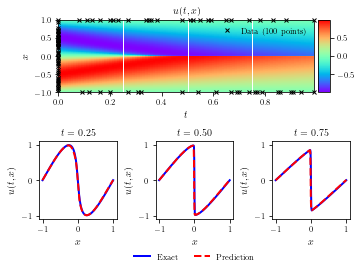

In [10]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

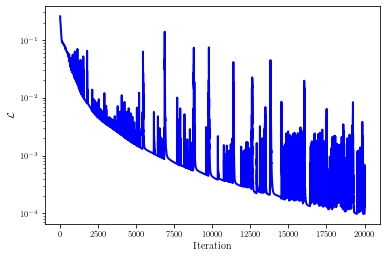

In [11]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

## PINN for Burger's Equation in JAX

In [7]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import scipy.io
from pyDOE import lhs
from jax.nn import tanh, relu
import sys
from jax.example_libraries import optimizers
from tqdm import trange
sys.path.insert(0, 'Utilities/')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


@jit
def predict(params, X, lb, ub):
    H =  2.0*(X - lb)/(ub - lb) - 1.0
    for w, b in params[:-1]:
        H = tanh(jnp.dot(H, w) + b)
        final_w, final_b = params[-1]
    H = jnp.dot(H, final_w) + final_b
    return H


@jit
def net_u(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred

@jit
def net_u_grad(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred[0]

def net_f(params, lb, ub):
    def u_t(x, t):
        ut = grad(net_u_grad, argnums=2)(params, x, t, lb, ub) 
        return ut

    def u_x(x, t):
        ux = grad(net_u_grad, argnums=1)(params, x, t, lb, ub) 
        return ux   
    return jit(u_t), jit(u_x)


def net_fxx(params, lb, ub):
    def u_xx(x, t):
        _, u_x = net_f(params, lb, ub) 
        ux = grad(u_x, argnums=0)(x, t) 
        return ux   
    return jit(u_xx)


@jit
def loss_data(params,x,t, lb, ub, u_train):
    u_pred = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    loss = jnp.mean((u_pred - u_train)**2 )
    return loss

@jit
def loss_f(params, x, t, lb, ub, nu):
    u = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    u_tf, u_xf = net_f(params, lb, ub)
    u_xxf = net_fxx(params, lb, ub)
    u_t = vmap(u_tf, (0, 0))(x, t)
    u_x = vmap(u_xf, (0, 0))(x, t)
    u_xx = vmap(u_xxf, (0, 0))(x, t)
    res = u_t + u.flatten() * u_x - nu * u_xx 
    loss_f = jnp.mean((res.flatten())**2)
    return loss_f

@jit
def predict_u(params, x_star, t_star, lb, ub):
    u_pred = vmap(net_u, (None, 0, 0, None, None))\
    (params, x_star, t_star, lb, ub)
    return u_pred

def loss_fn(params, x_f, t_f,x_d, t_d, lb, ub, nu, y_d):
    loss_res = loss_f(params, x_f, t_f, lb, ub, nu)
    data_loss = loss_data(params, x_d, t_d, lb, ub, y_d) 
    return loss_res + data_loss

@jit
def step(istep, opt_state, t_d, x_d, y_d, t_f, x_f, lb, ub):
    param = get_params(opt_state) 
    g = grad(loss_fn, argnums=0)(param, x_f, t_f,x_d, t_d, lb, ub, nu, y_d)
    return opt_update(istep, g, opt_state)

if __name__ == "__main__":
    nu = 0.01/np.pi
    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20,20, 20, 1]
    data = scipy.io.loadmat('Data/burgers_shock.mat')
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              
    lb = X_star.min(0)
    ub = X_star.max(0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    x_d = X_u_train[:, 0]
    t_d = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    x_star = X_star[:, 0]
    t_star = X_star[:, 1]
    params = init_network_params(layers, random.PRNGKey(1234))
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(params)
    nIter = 20000 + 1
    ld_list = []
    lf_list = []
    pbar = trange(nIter)
    
    for it in pbar:
        opt_state = step(it, opt_state, t_d, x_d, u_train, t_f, x_f, lb, ub)
        if it % 1 == 0:
            params = get_params(opt_state)
            l_d = loss_data(params, x_d, t_d, lb, ub, u_train)
            l_f = loss_f(params, x_f, t_f, lb, ub, nu)
            pbar.set_postfix({'Loss': l_d, 'loss_physics': l_f})
            ld_list.append(l_d)
            lf_list.append(l_f)


    u_pred = predict_u(params, x_star, t_star, lb, ub)
            
    error_u = jnp.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    np.save("ld_list.npy", np.array(ld_list), allow_pickle=True) 
    np.save("lf_list.npy", np.array(lf_list), allow_pickle=True)  
 
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)

    savefig("Burgers")
    


## PINN for a Boundary Layer Problem

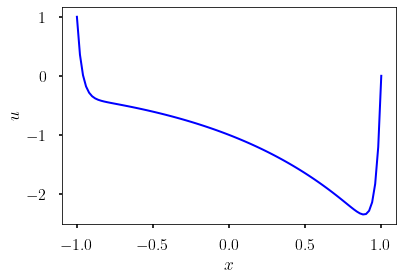

In [9]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()

In [10]:
#Using Vanilla PINN

import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0 and loss is: 36.536865234375
Iteration is: 1 and loss is: 32.31436538696289
Iteration is: 2 and loss is: 28.28046226501465
Iteration is: 3 and loss is: 24.432859420776367
Iteration is: 4 and loss is: 20.79062843322754
Iteration is: 5 and loss is: 17.39005470275879
Iteration is: 6 and loss is: 14.26872730255127
Iteration is: 7 and loss is: 11.459373474121094
Iteration is: 8 and loss is: 8.98551082611084
Iteration is: 9 and loss is: 6.85828161239624
Iteration is: 10 and loss is: 5.0749030113220215
Iteration is: 11 and loss is: 3.6195666790008545
Iteration is: 12 and loss is: 2.4678053855895996
Iteration is: 13 and loss is: 1.5934545993804932
Iteration is: 14 and loss is: 0.9745383262634277
Iteration is: 15 and loss is: 0.5949716567993164
Iteration is: 16 and loss is: 0.4408942461013794
Iteration is: 17 and loss is: 0.49178215861320496
Iteration is: 18 and loss is: 0.7089072465896606
Iteration is: 19 and loss is: 1.0280756950378418
Iteration is: 20 and loss is: 1.367208838

Iteration is: 283 and loss is: 0.019284872338175774
Iteration is: 284 and loss is: 0.019065100699663162
Iteration is: 285 and loss is: 0.018850218504667282
Iteration is: 286 and loss is: 0.018640078604221344
Iteration is: 287 and loss is: 0.018434565514326096
Iteration is: 288 and loss is: 0.018233580514788628
Iteration is: 289 and loss is: 0.018037037923932076
Iteration is: 290 and loss is: 0.017844881862401962
Iteration is: 291 and loss is: 0.01765695959329605
Iteration is: 292 and loss is: 0.017473243176937103
Iteration is: 293 and loss is: 0.017293574288487434
Iteration is: 294 and loss is: 0.017117885872721672
Iteration is: 295 and loss is: 0.016946084797382355
Iteration is: 296 and loss is: 0.016778098419308662
Iteration is: 297 and loss is: 0.016613798215985298
Iteration is: 298 and loss is: 0.016453156247735023
Iteration is: 299 and loss is: 0.016296042129397392
Iteration is: 300 and loss is: 0.01614237017929554
Iteration is: 301 and loss is: 0.015992101281881332
Iteration is: 

Iteration is: 462 and loss is: 0.007363429293036461
Iteration is: 463 and loss is: 0.007339745294302702
Iteration is: 464 and loss is: 0.007316171657294035
Iteration is: 465 and loss is: 0.007292736321687698
Iteration is: 466 and loss is: 0.007269436027854681
Iteration is: 467 and loss is: 0.007246246095746756
Iteration is: 468 and loss is: 0.007223182823508978
Iteration is: 469 and loss is: 0.007200264371931553
Iteration is: 470 and loss is: 0.007177455350756645
Iteration is: 471 and loss is: 0.007154756225645542
Iteration is: 472 and loss is: 0.00713220564648509
Iteration is: 473 and loss is: 0.0071097686886787415
Iteration is: 474 and loss is: 0.0070874448865652084
Iteration is: 475 and loss is: 0.007065249606966972
Iteration is: 476 and loss is: 0.007043154910206795
Iteration is: 477 and loss is: 0.007021194323897362
Iteration is: 478 and loss is: 0.006999339442700148
Iteration is: 479 and loss is: 0.006977606564760208
Iteration is: 480 and loss is: 0.006955974269658327
Iteration i

Iteration is: 643 and loss is: 0.0044951410964131355
Iteration is: 644 and loss is: 0.004484603647142649
Iteration is: 645 and loss is: 0.0044741141609847546
Iteration is: 646 and loss is: 0.004463654011487961
Iteration is: 647 and loss is: 0.004453232977539301
Iteration is: 648 and loss is: 0.004442851524800062
Iteration is: 649 and loss is: 0.004432507790625095
Iteration is: 650 and loss is: 0.004422204103320837
Iteration is: 651 and loss is: 0.004411939997226
Iteration is: 652 and loss is: 0.004401709418743849
Iteration is: 653 and loss is: 0.0043915193527936935
Iteration is: 654 and loss is: 0.004381365142762661
Iteration is: 655 and loss is: 0.00437125051394105
Iteration is: 656 and loss is: 0.004361160099506378
Iteration is: 657 and loss is: 0.004351125098764896
Iteration is: 658 and loss is: 0.004341116640716791
Iteration is: 659 and loss is: 0.004331147763878107
Iteration is: 660 and loss is: 0.0043212054297327995
Iteration is: 661 and loss is: 0.004311306867748499
Iteration is

Iteration is: 824 and loss is: 0.003067529294639826
Iteration is: 825 and loss is: 0.003061661496758461
Iteration is: 826 and loss is: 0.0030558116268366575
Iteration is: 827 and loss is: 0.0030499775893986225
Iteration is: 828 and loss is: 0.0030441628769040108
Iteration is: 829 and loss is: 0.0030383607372641563
Iteration is: 830 and loss is: 0.0030325809493660927
Iteration is: 831 and loss is: 0.0030268083792179823
Iteration is: 832 and loss is: 0.00302105862647295
Iteration is: 833 and loss is: 0.0030153270345181227
Iteration is: 834 and loss is: 0.003009603125974536
Iteration is: 835 and loss is: 0.003003898309543729
Iteration is: 836 and loss is: 0.0029982130508869886
Iteration is: 837 and loss is: 0.0029925380367785692
Iteration is: 838 and loss is: 0.002986886305734515
Iteration is: 839 and loss is: 0.00298124342225492
Iteration is: 840 and loss is: 0.002975620562210679
Iteration is: 841 and loss is: 0.00297002075240016
Iteration is: 842 and loss is: 0.0029644223395735025
Itera

Iteration is: 996 and loss is: 0.0022589880973100662
Iteration is: 997 and loss is: 0.0022552432492375374
Iteration is: 998 and loss is: 0.002251515630632639
Iteration is: 999 and loss is: 0.002247791038826108
Iteration is: 1000 and loss is: 0.0022440783213824034
Iteration is: 1001 and loss is: 0.0022403772454708815
Iteration is: 1002 and loss is: 0.00223668129183352
Iteration is: 1003 and loss is: 0.0022329906933009624
Iteration is: 1004 and loss is: 0.002229314064607024
Iteration is: 1005 and loss is: 0.0022256469819694757
Iteration is: 1006 and loss is: 0.0022219843231141567
Iteration is: 1007 and loss is: 0.002218330977484584
Iteration is: 1008 and loss is: 0.0022146895062178373
Iteration is: 1009 and loss is: 0.0022110557183623314
Iteration is: 1010 and loss is: 0.002207428915426135
Iteration is: 1011 and loss is: 0.0022038088645786047
Iteration is: 1012 and loss is: 0.0022002016194164753
Iteration is: 1013 and loss is: 0.0021966027561575174
Iteration is: 1014 and loss is: 0.00219

Iteration is: 1335 and loss is: 0.0013992649037390947
Iteration is: 1336 and loss is: 0.0013974686153233051
Iteration is: 1337 and loss is: 0.0013956441543996334
Iteration is: 1338 and loss is: 0.001393806654959917
Iteration is: 1339 and loss is: 0.0013919767225161195
Iteration is: 1340 and loss is: 0.0013901658821851015
Iteration is: 1341 and loss is: 0.001388378208503127
Iteration is: 1342 and loss is: 0.0013866156805306673
Iteration is: 1343 and loss is: 0.0013848571106791496
Iteration is: 1344 and loss is: 0.0013831069227308035
Iteration is: 1345 and loss is: 0.0013813514960929751
Iteration is: 1346 and loss is: 0.0013795942068099976
Iteration is: 1347 and loss is: 0.0013778266729786992
Iteration is: 1348 and loss is: 0.001376057625748217
Iteration is: 1349 and loss is: 0.001374292653053999
Iteration is: 1350 and loss is: 0.0013725294265896082
Iteration is: 1351 and loss is: 0.0013707715552300215
Iteration is: 1352 and loss is: 0.0013690198538824916
Iteration is: 1353 and loss is: 

Iteration is: 1534 and loss is: 0.0011187110794708133
Iteration is: 1535 and loss is: 0.0011174340033903718
Iteration is: 1536 and loss is: 0.0011161596048623323
Iteration is: 1537 and loss is: 0.0011148902121931314
Iteration is: 1538 and loss is: 0.0011136200046166778
Iteration is: 1539 and loss is: 0.0011123535223305225
Iteration is: 1540 and loss is: 0.0011110901832580566
Iteration is: 1541 and loss is: 0.001109828008338809
Iteration is: 1542 and loss is: 0.0011085697915405035
Iteration is: 1543 and loss is: 0.0011073099449276924
Iteration is: 1544 and loss is: 0.0011060547549277544
Iteration is: 1545 and loss is: 0.0011048036394640803
Iteration is: 1546 and loss is: 0.00110355275683105
Iteration is: 1547 and loss is: 0.0011023051338270307
Iteration is: 1548 and loss is: 0.001101059140637517
Iteration is: 1549 and loss is: 0.0010998162906616926
Iteration is: 1550 and loss is: 0.0010985761182382703
Iteration is: 1551 and loss is: 0.00109733990393579
Iteration is: 1552 and loss is: 0.

Iteration is: 1723 and loss is: 0.0009397318353876472
Iteration is: 1724 and loss is: 0.0009387630852870643
Iteration is: 1725 and loss is: 0.0009377985843457282
Iteration is: 1726 and loss is: 0.0009368364117108285
Iteration is: 1727 and loss is: 0.0009358745883218944
Iteration is: 1728 and loss is: 0.0009349136962555349
Iteration is: 1729 and loss is: 0.0009339530952274799
Iteration is: 1730 and loss is: 0.000932994531467557
Iteration is: 1731 and loss is: 0.0009320357930846512
Iteration is: 1732 and loss is: 0.0009310804307460785
Iteration is: 1733 and loss is: 0.0009301250684075058
Iteration is: 1734 and loss is: 0.0009291702299378812
Iteration is: 1735 and loss is: 0.0009282188839279115
Iteration is: 1736 and loss is: 0.0009272683528251946
Iteration is: 1737 and loss is: 0.0009263203828595579
Iteration is: 1738 and loss is: 0.0009253709577023983
Iteration is: 1739 and loss is: 0.0009244266548193991
Iteration is: 1740 and loss is: 0.0009234820026904345
Iteration is: 1741 and loss i

Iteration is: 1894 and loss is: 0.0008237091242335737
Iteration is: 1895 and loss is: 0.0008228324586525559
Iteration is: 1896 and loss is: 0.000821836234536022
Iteration is: 1897 and loss is: 0.0008208674844354391
Iteration is: 1898 and loss is: 0.0008200268493965268
Iteration is: 1899 and loss is: 0.000819312990643084
Iteration is: 1900 and loss is: 0.000818650412838906
Iteration is: 1901 and loss is: 0.0008179463911801577
Iteration is: 1902 and loss is: 0.0008171563968062401
Iteration is: 1903 and loss is: 0.0008162946323864162
Iteration is: 1904 and loss is: 0.0008154188981279731
Iteration is: 1905 and loss is: 0.0008145825122483075
Iteration is: 1906 and loss is: 0.0008138052653521299
Iteration is: 1907 and loss is: 0.0008130764472298324
Iteration is: 1908 and loss is: 0.0008123557199724019
Iteration is: 1909 and loss is: 0.000811613688711077
Iteration is: 1910 and loss is: 0.0008108330075629056
Iteration is: 1911 and loss is: 0.0008100247941911221
Iteration is: 1912 and loss is: 

Iteration is: 2053 and loss is: 0.000791605853009969
Iteration is: 2054 and loss is: 0.0007615083013661206
Iteration is: 2055 and loss is: 0.0007458399632014334
Iteration is: 2056 and loss is: 0.0007564669358544052
Iteration is: 2057 and loss is: 0.0007733082165941596
Iteration is: 2058 and loss is: 0.0007734710816293955
Iteration is: 2059 and loss is: 0.0007573561160825193
Iteration is: 2060 and loss is: 0.0007436022278852761
Iteration is: 2061 and loss is: 0.0007446871604770422
Iteration is: 2062 and loss is: 0.000754549284465611
Iteration is: 2063 and loss is: 0.0007589609012939036
Iteration is: 2064 and loss is: 0.0007524467655457556
Iteration is: 2065 and loss is: 0.0007423895294778049
Iteration is: 2066 and loss is: 0.0007385265198536217
Iteration is: 2067 and loss is: 0.000742242846172303
Iteration is: 2068 and loss is: 0.0007468684925697744
Iteration is: 2069 and loss is: 0.0007461791974492371
Iteration is: 2070 and loss is: 0.0007406793884001672
Iteration is: 2071 and loss is:

Iteration is: 2249 and loss is: 0.0010217332746833563
Iteration is: 2250 and loss is: 0.0006942761829122901
Iteration is: 2251 and loss is: 0.0007763566100038588
Iteration is: 2252 and loss is: 0.0010341060115024447
Iteration is: 2253 and loss is: 0.001026920392177999
Iteration is: 2254 and loss is: 0.000785927870310843
Iteration is: 2255 and loss is: 0.0006732501788064837
Iteration is: 2256 and loss is: 0.0008013575570657849
Iteration is: 2257 and loss is: 0.0009204222005791962
Iteration is: 2258 and loss is: 0.0008428841829299927
Iteration is: 2259 and loss is: 0.0006977807497605681
Iteration is: 2260 and loss is: 0.0006850806530565023
Iteration is: 2261 and loss is: 0.0007827028748579323
Iteration is: 2262 and loss is: 0.0008208518847823143
Iteration is: 2263 and loss is: 0.0007457428728230298
Iteration is: 2264 and loss is: 0.0006715537747368217
Iteration is: 2265 and loss is: 0.0006897306302562356
Iteration is: 2266 and loss is: 0.0007490417920053005
Iteration is: 2267 and loss is

Iteration is: 2418 and loss is: 0.0005859656375832856
Iteration is: 2419 and loss is: 0.0005854889750480652
Iteration is: 2420 and loss is: 0.0005850141169503331
Iteration is: 2421 and loss is: 0.0005845414125360548
Iteration is: 2422 and loss is: 0.0005840698140673339
Iteration is: 2423 and loss is: 0.0005836007185280323
Iteration is: 2424 and loss is: 0.000583138782531023
Iteration is: 2425 and loss is: 0.0005826830165460706
Iteration is: 2426 and loss is: 0.0005822365637868643
Iteration is: 2427 and loss is: 0.0005818011704832315
Iteration is: 2428 and loss is: 0.0005813876632601023
Iteration is: 2429 and loss is: 0.0005810025613754988
Iteration is: 2430 and loss is: 0.0005806612898595631
Iteration is: 2431 and loss is: 0.0005803898675367236
Iteration is: 2432 and loss is: 0.0005802233354188502
Iteration is: 2433 and loss is: 0.0005802236264571548
Iteration is: 2434 and loss is: 0.0005804935353808105
Iteration is: 2435 and loss is: 0.0005811955779790878
Iteration is: 2436 and loss i

Iteration is: 2580 and loss is: 0.000558720959816128
Iteration is: 2581 and loss is: 0.000558289757464081
Iteration is: 2582 and loss is: 0.0005578559939749539
Iteration is: 2583 and loss is: 0.0005574029055424035
Iteration is: 2584 and loss is: 0.0005569364293478429
Iteration is: 2585 and loss is: 0.0005564659368246794
Iteration is: 2586 and loss is: 0.000556008133571595
Iteration is: 2587 and loss is: 0.0005555627285502851
Iteration is: 2588 and loss is: 0.0005551245994865894
Iteration is: 2589 and loss is: 0.0005546854226849973
Iteration is: 2590 and loss is: 0.0005542404833249748
Iteration is: 2591 and loss is: 0.0005537873948924243
Iteration is: 2592 and loss is: 0.0005533319199457765
Iteration is: 2593 and loss is: 0.0005528781330212951
Iteration is: 2594 and loss is: 0.0005524317384697497
Iteration is: 2595 and loss is: 0.0005519906990230083
Iteration is: 2596 and loss is: 0.0005515536176972091
Iteration is: 2597 and loss is: 0.0005511139170266688
Iteration is: 2598 and loss is:

Iteration is: 2743 and loss is: 0.0007958011701703072
Iteration is: 2744 and loss is: 0.0006931059760972857
Iteration is: 2745 and loss is: 0.0005596644477918744
Iteration is: 2746 and loss is: 0.0005862966645509005
Iteration is: 2747 and loss is: 0.0006871561636216938
Iteration is: 2748 and loss is: 0.0006829785997979343
Iteration is: 2749 and loss is: 0.0005871744942851365
Iteration is: 2750 and loss is: 0.0005487609887495637
Iteration is: 2751 and loss is: 0.0006035921396687627
Iteration is: 2752 and loss is: 0.0006436884286813438
Iteration is: 2753 and loss is: 0.0006046071066521108
Iteration is: 2754 and loss is: 0.0005508401081897318
Iteration is: 2755 and loss is: 0.0005566509789787233
Iteration is: 2756 and loss is: 0.0005960811395198107
Iteration is: 2757 and loss is: 0.0006002042209729552
Iteration is: 2758 and loss is: 0.0005646687350235879
Iteration is: 2759 and loss is: 0.000542943540494889
Iteration is: 2760 and loss is: 0.0005589724169112742
Iteration is: 2761 and loss i

Iteration is: 2899 and loss is: 0.00048475907533429563
Iteration is: 2900 and loss is: 0.0004843815404456109
Iteration is: 2901 and loss is: 0.0004840028996113688
Iteration is: 2902 and loss is: 0.000483624724438414
Iteration is: 2903 and loss is: 0.00048324844101443887
Iteration is: 2904 and loss is: 0.0004828707023989409
Iteration is: 2905 and loss is: 0.0004824943607673049
Iteration is: 2906 and loss is: 0.0004821195325348526
Iteration is: 2907 and loss is: 0.00048174330731853843
Iteration is: 2908 and loss is: 0.0004813677223864943
Iteration is: 2909 and loss is: 0.0004809931560885161
Iteration is: 2910 and loss is: 0.0004806185606867075
Iteration is: 2911 and loss is: 0.00048024384886957705
Iteration is: 2912 and loss is: 0.00047986983554437757
Iteration is: 2913 and loss is: 0.00047949596773833036
Iteration is: 2914 and loss is: 0.00047912224545143545
Iteration is: 2915 and loss is: 0.0004787506186403334
Iteration is: 2916 and loss is: 0.00047837907914072275
Iteration is: 2917 an

Error u: 1.933103e+01


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


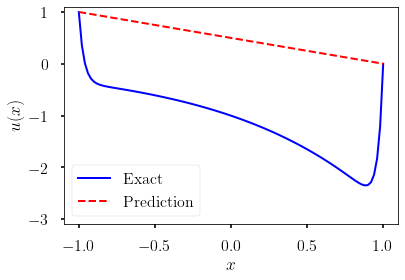

No handles with labels found to put in legend.


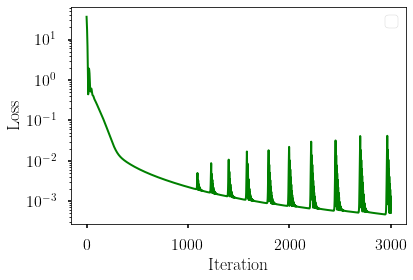

In [11]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





In [12]:
##Self Adaptive for residual minimzation
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_fd(x, W, b, nu):
    h=0.1
    u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 3000
N_f = 500
N_b = 2

layers = [1, 8, 8,8,8,8,8,1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Iteration is: 0 and loss is: 2177501.0
Iteration is: 1 and loss is: 2144915.75
Iteration is: 2 and loss is: 2120281.5
Iteration is: 3 and loss is: 2095652.125
Iteration is: 4 and loss is: 2070088.375
Iteration is: 5 and loss is: 2043338.75
Iteration is: 6 and loss is: 2015364.0
Iteration is: 7 and loss is: 1986224.375
Iteration is: 8 and loss is: 1956035.5
Iteration is: 9 and loss is: 1924947.0
Iteration is: 10 and loss is: 1893129.125
Iteration is: 11 and loss is: 1860765.375
Iteration is: 12 and loss is: 1828046.75
Iteration is: 13 and loss is: 1795166.25
Iteration is: 14 and loss is: 1762318.875
Iteration is: 15 and loss is: 1729697.625
Iteration is: 16 and loss is: 1697492.625
Iteration is: 17 and loss is: 1665889.125
Iteration is: 18 and loss is: 1635065.25
Iteration is: 19 and loss is: 1605189.625
Iteration is: 20 and loss is: 1576418.625
Iteration is: 21 and loss is: 1548894.375
Iteration is: 22 and loss is: 1522740.625
Iteration is: 23 and loss is: 1498060.25
Iteration is: 24 a

Iteration is: 244 and loss is: 1233773.75
Iteration is: 245 and loss is: 1235036.25
Iteration is: 246 and loss is: 1235440.75
Iteration is: 247 and loss is: 1235715.25
Iteration is: 248 and loss is: 1236864.375
Iteration is: 249 and loss is: 1237084.75
Iteration is: 250 and loss is: 1237716.25
Iteration is: 251 and loss is: 1238602.75
Iteration is: 252 and loss is: 1238826.5
Iteration is: 253 and loss is: 1239671.875
Iteration is: 254 and loss is: 1240280.75
Iteration is: 255 and loss is: 1240665.875
Iteration is: 256 and loss is: 1241518.0
Iteration is: 257 and loss is: 1241988.375
Iteration is: 258 and loss is: 1242512.75
Iteration is: 259 and loss is: 1243288.5
Iteration is: 260 and loss is: 1243736.625
Iteration is: 261 and loss is: 1244310.25
Iteration is: 262 and loss is: 1245026.75
Iteration is: 263 and loss is: 1245497.5
Iteration is: 264 and loss is: 1246053.75
Iteration is: 265 and loss is: 1246739.125
Iteration is: 266 and loss is: 1247255.625
Iteration is: 267 and loss is: 

Iteration is: 511 and loss is: 1410900.125
Iteration is: 512 and loss is: 1411029.125
Iteration is: 513 and loss is: 1411169.625
Iteration is: 514 and loss is: 1411375.25
Iteration is: 515 and loss is: 1411632.875
Iteration is: 516 and loss is: 1411899.25
Iteration is: 517 and loss is: 1412142.25
Iteration is: 518 and loss is: 1412302.75
Iteration is: 519 and loss is: 1412414.875
Iteration is: 520 and loss is: 1412459.0
Iteration is: 521 and loss is: 1412488.75
Iteration is: 522 and loss is: 1412513.75
Iteration is: 523 and loss is: 1412547.25
Iteration is: 524 and loss is: 1412583.5
Iteration is: 525 and loss is: 1412606.875
Iteration is: 526 and loss is: 1412606.125
Iteration is: 527 and loss is: 1412562.75
Iteration is: 528 and loss is: 1412483.0
Iteration is: 529 and loss is: 1412357.0
Iteration is: 530 and loss is: 1412201.75
Iteration is: 531 and loss is: 1412015.375
Iteration is: 532 and loss is: 1411808.5
Iteration is: 533 and loss is: 1411580.25
Iteration is: 534 and loss is: 

Iteration is: 741 and loss is: 375758.5625
Iteration is: 742 and loss is: 370189.6875
Iteration is: 743 and loss is: 366283.75
Iteration is: 744 and loss is: 364322.0625
Iteration is: 745 and loss is: 363525.375
Iteration is: 746 and loss is: 363015.71875
Iteration is: 747 and loss is: 361599.78125
Iteration is: 748 and loss is: 358928.96875
Iteration is: 749 and loss is: 354405.65625
Iteration is: 750 and loss is: 349464.21875
Iteration is: 751 and loss is: 345250.53125
Iteration is: 752 and loss is: 342471.1875
Iteration is: 753 and loss is: 340856.15625
Iteration is: 754 and loss is: 339777.5625
Iteration is: 755 and loss is: 338961.375
Iteration is: 756 and loss is: 337748.9375
Iteration is: 757 and loss is: 336213.5625
Iteration is: 758 and loss is: 333340.65625
Iteration is: 759 and loss is: 329715.96875
Iteration is: 760 and loss is: 325305.5
Iteration is: 761 and loss is: 321403.0
Iteration is: 762 and loss is: 318575.375
Iteration is: 763 and loss is: 316401.96875
Iteration is

Iteration is: 998 and loss is: 22549.646484375
Iteration is: 999 and loss is: 23221.125
Iteration is: 1000 and loss is: 23345.8125
Iteration is: 1001 and loss is: 23074.1953125
Iteration is: 1002 and loss is: 22196.8671875
Iteration is: 1003 and loss is: 21460.650390625
Iteration is: 1004 and loss is: 21091.91015625
Iteration is: 1005 and loss is: 21141.72265625
Iteration is: 1006 and loss is: 21391.486328125
Iteration is: 1007 and loss is: 21480.80859375
Iteration is: 1008 and loss is: 21367.2890625
Iteration is: 1009 and loss is: 20935.638671875
Iteration is: 1010 and loss is: 20496.51171875
Iteration is: 1011 and loss is: 20173.3046875
Iteration is: 1012 and loss is: 20055.537109375
Iteration is: 1013 and loss is: 20080.669921875
Iteration is: 1014 and loss is: 20111.5703125
Iteration is: 1015 and loss is: 20072.052734375
Iteration is: 1016 and loss is: 19882.009765625
Iteration is: 1017 and loss is: 19636.373046875
Iteration is: 1018 and loss is: 19383.392578125
Iteration is: 1019 

Iteration is: 1266 and loss is: 7042.2001953125
Iteration is: 1267 and loss is: 7018.74853515625
Iteration is: 1268 and loss is: 6995.47265625
Iteration is: 1269 and loss is: 6972.34765625
Iteration is: 1270 and loss is: 6949.625
Iteration is: 1271 and loss is: 6927.1435546875
Iteration is: 1272 and loss is: 6904.52978515625
Iteration is: 1273 and loss is: 6882.37841796875
Iteration is: 1274 and loss is: 6860.49267578125
Iteration is: 1275 and loss is: 6838.5283203125
Iteration is: 1276 and loss is: 6817.06982421875
Iteration is: 1277 and loss is: 6796.27294921875
Iteration is: 1278 and loss is: 6776.07666015625
Iteration is: 1279 and loss is: 6756.8447265625
Iteration is: 1280 and loss is: 6738.68359375
Iteration is: 1281 and loss is: 6722.0537109375
Iteration is: 1282 and loss is: 6707.2216796875
Iteration is: 1283 and loss is: 6696.2412109375
Iteration is: 1284 and loss is: 6688.8193359375
Iteration is: 1285 and loss is: 6688.82763671875
Iteration is: 1286 and loss is: 6695.21533203

Iteration is: 1539 and loss is: 3533.1962890625
Iteration is: 1540 and loss is: 3494.6328125
Iteration is: 1541 and loss is: 3435.446533203125
Iteration is: 1542 and loss is: 3389.019287109375
Iteration is: 1543 and loss is: 3336.365234375
Iteration is: 1544 and loss is: 3294.720703125
Iteration is: 1545 and loss is: 3255.38427734375
Iteration is: 1546 and loss is: 3224.659423828125
Iteration is: 1547 and loss is: 3199.22802734375
Iteration is: 1548 and loss is: 3180.42724609375
Iteration is: 1549 and loss is: 3166.098388671875
Iteration is: 1550 and loss is: 3155.9580078125
Iteration is: 1551 and loss is: 3148.582763671875
Iteration is: 1552 and loss is: 3143.437744140625
Iteration is: 1553 and loss is: 3139.787841796875
Iteration is: 1554 and loss is: 3137.05029296875
Iteration is: 1555 and loss is: 3134.883544921875
Iteration is: 1556 and loss is: 3132.864990234375
Iteration is: 1557 and loss is: 3131.1337890625
Iteration is: 1558 and loss is: 3129.12744140625
Iteration is: 1559 and

Iteration is: 1805 and loss is: 2331.833740234375
Iteration is: 1806 and loss is: 2128.310791015625
Iteration is: 1807 and loss is: 2119.40869140625
Iteration is: 1808 and loss is: 2225.017822265625
Iteration is: 1809 and loss is: 2417.01953125
Iteration is: 1810 and loss is: 2576.514892578125
Iteration is: 1811 and loss is: 2753.3017578125
Iteration is: 1812 and loss is: 2764.05322265625
Iteration is: 1813 and loss is: 2787.14794921875
Iteration is: 1814 and loss is: 2634.6298828125
Iteration is: 1815 and loss is: 2510.57861328125
Iteration is: 1816 and loss is: 2314.106689453125
Iteration is: 1817 and loss is: 2163.08935546875
Iteration is: 1818 and loss is: 2038.795654296875
Iteration is: 1819 and loss is: 1967.7381591796875
Iteration is: 1820 and loss is: 1947.9044189453125
Iteration is: 1821 and loss is: 1966.2513427734375
Iteration is: 1822 and loss is: 2010.957275390625
Iteration is: 1823 and loss is: 2059.535888671875
Iteration is: 1824 and loss is: 2108.586181640625
Iteration 

Iteration is: 2063 and loss is: 6278.625
Iteration is: 2064 and loss is: 4847.419921875
Iteration is: 2065 and loss is: 4049.181640625
Iteration is: 2066 and loss is: 2724.62353515625
Iteration is: 2067 and loss is: 1929.650634765625
Iteration is: 2068 and loss is: 1525.1072998046875
Iteration is: 2069 and loss is: 1567.1064453125
Iteration is: 2070 and loss is: 1912.759033203125
Iteration is: 2071 and loss is: 2343.596435546875
Iteration is: 2072 and loss is: 2793.0244140625
Iteration is: 2073 and loss is: 2863.3525390625
Iteration is: 2074 and loss is: 2890.68994140625
Iteration is: 2075 and loss is: 2498.328857421875
Iteration is: 2076 and loss is: 2164.67626953125
Iteration is: 2077 and loss is: 1776.19189453125
Iteration is: 2078 and loss is: 1547.92333984375
Iteration is: 2079 and loss is: 1470.5146484375
Iteration is: 2080 and loss is: 1533.6048583984375
Iteration is: 2081 and loss is: 1667.4327392578125
Iteration is: 2082 and loss is: 1810.2850341796875
Iteration is: 2083 and l

Iteration is: 2324 and loss is: 1141.31640625
Iteration is: 2325 and loss is: 1133.7216796875
Iteration is: 2326 and loss is: 1129.26611328125
Iteration is: 2327 and loss is: 1127.6866455078125
Iteration is: 2328 and loss is: 1128.2745361328125
Iteration is: 2329 and loss is: 1130.225341796875
Iteration is: 2330 and loss is: 1132.95458984375
Iteration is: 2331 and loss is: 1135.5810546875
Iteration is: 2332 and loss is: 1137.97265625
Iteration is: 2333 and loss is: 1139.4176025390625
Iteration is: 2334 and loss is: 1140.3482666015625
Iteration is: 2335 and loss is: 1140.090087890625
Iteration is: 2336 and loss is: 1139.4071044921875
Iteration is: 2337 and loss is: 1137.740966796875
Iteration is: 2338 and loss is: 1135.8255615234375
Iteration is: 2339 and loss is: 1133.275634765625
Iteration is: 2340 and loss is: 1130.818359375
Iteration is: 2341 and loss is: 1128.1339111328125
Iteration is: 2342 and loss is: 1125.7420654296875
Iteration is: 2343 and loss is: 1123.3016357421875
Iteratio

Iteration is: 2598 and loss is: 1048.7545166015625
Iteration is: 2599 and loss is: 1035.1031494140625
Iteration is: 2600 and loss is: 1013.0579223632812
Iteration is: 2601 and loss is: 998.007080078125
Iteration is: 2602 and loss is: 979.721435546875
Iteration is: 2603 and loss is: 966.9739379882812
Iteration is: 2604 and loss is: 954.3467407226562
Iteration is: 2605 and loss is: 945.8030395507812
Iteration is: 2606 and loss is: 938.7850952148438
Iteration is: 2607 and loss is: 934.8121948242188
Iteration is: 2608 and loss is: 932.745361328125
Iteration is: 2609 and loss is: 933.1883544921875
Iteration is: 2610 and loss is: 935.7435913085938
Iteration is: 2611 and loss is: 941.2268676757812
Iteration is: 2612 and loss is: 949.530517578125
Iteration is: 2613 and loss is: 962.847900390625
Iteration is: 2614 and loss is: 980.7064208984375
Iteration is: 2615 and loss is: 1008.714599609375
Iteration is: 2616 and loss is: 1045.1368408203125
Iteration is: 2617 and loss is: 1105.4034423828125


Iteration is: 2869 and loss is: 1461.093505859375
Iteration is: 2870 and loss is: 862.772216796875
Iteration is: 2871 and loss is: 896.788330078125
Iteration is: 2872 and loss is: 1382.2991943359375
Iteration is: 2873 and loss is: 1958.293701171875
Iteration is: 2874 and loss is: 2590.192138671875
Iteration is: 2875 and loss is: 2616.4111328125
Iteration is: 2876 and loss is: 2592.654541015625
Iteration is: 2877 and loss is: 1999.693115234375
Iteration is: 2878 and loss is: 1495.108642578125
Iteration is: 2879 and loss is: 1021.2243041992188
Iteration is: 2880 and loss is: 799.9086303710938
Iteration is: 2881 and loss is: 821.3671264648438
Iteration is: 2882 and loss is: 1009.450927734375
Iteration is: 2883 and loss is: 1269.30126953125
Iteration is: 2884 and loss is: 1428.7679443359375
Iteration is: 2885 and loss is: 1530.1202392578125
Iteration is: 2886 and loss is: 1413.26806640625
Iteration is: 2887 and loss is: 1261.8626708984375
Iteration is: 2888 and loss is: 1038.8192138671875


Error u: 7.361192e+00


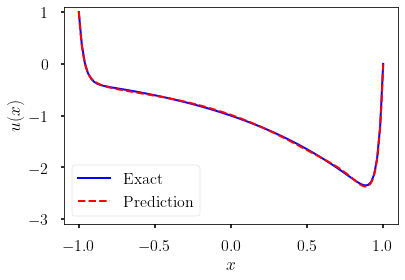

No handles with labels found to put in legend.


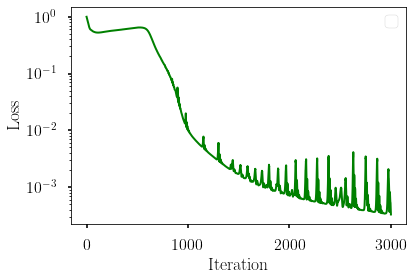

In [13]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(layers, W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_b, beta):
    x_u = X_u_train_tf[:,0:1]
    x_f = X_f_train_tf[:,0:1]
    adpative_constant_bcs_list = []
    lambda_b_list = []
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u,W, b) 
        f_nn = net_f(x_f,W, b, nu)
        bc_loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf))
        phys_loss = tf.reduce_mean(tf.square(f_nn)) 
        loss = lambda_b[-1]*bc_loss  + phys_loss
        loss = loss / (1 + lambda_b[-1])
        p_loss = phys_loss/(1 + lambda_b[-1])
        b_loss = lambda_b[-1]*bc_loss/(1 + lambda_b[-1])
    grad_loss = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grad_loss, train_vars(W,b)))
    grads_bc = tape.gradient(bc_loss, train_vars(W,b))
    grads_phys = tape.gradient(phys_loss, train_vars(W,b))
    for i in range(len(layers) - 1):
        adpative_constant_bcs_list.append(
                tf.reduce_mean(tf.abs(grads_phys[i])) / tf.reduce_mean(tf.abs(grads_bc[i])))
        
    lambda_b_new = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
    lambda_b_new = (1-beta)*lambda_b[-1] + beta*lambda_b_new
    lambda_b_list.append(lambda_b_new)
                                      
    return loss, lambda_b_list, p_loss, b_loss


def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
noise = 0.0        
N_f = 500
Nmax=50000

layers = [1, 8,8,8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])
X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))
X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)
lam_b = np.array([1.0])
lam_b_tf= tf.convert_to_tensor(lam_b, dtype=tf.float32)                                
lambda_b_list = [lam_b_tf]                               
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)
start_time = time.time()
n=0
loss = []
bc_loss = []
phys_loss = []
beta = 0.1

while n <= Nmax:
    loss_, lambda_b_out, phys_loss_, bc_loss_ = train_step(layers, W, b, X_u_train_tf,\
                                                u_train_tf, X_f_train_tf, optimizer, nu,lambda_b_list, beta)
    lambda_b_list = lambda_b_out
    loss.append(loss_) 
    bc_loss.append(bc_loss_)
    phys_loss.append(phys_loss_)
    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))               
print('Training time: %.4f' % (elapsed))


def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()


Iteration is: 0 and loss is: [871706.6]
Iteration is: 1 and loss is: [18.274786]
Iteration is: 2 and loss is: [9.62311]
Iteration is: 3 and loss is: [6.764636]
Iteration is: 4 and loss is: [5.348354]
Iteration is: 5 and loss is: [4.5067835]
Iteration is: 6 and loss is: [3.9515827]
Iteration is: 7 and loss is: [3.559522]
Iteration is: 8 and loss is: [3.2690904]
Iteration is: 9 and loss is: [3.0461984]
Iteration is: 10 and loss is: [2.870465]
Iteration is: 11 and loss is: [2.7289348]
Iteration is: 12 and loss is: [2.6129756]
Iteration is: 13 and loss is: [2.5166261]
Iteration is: 14 and loss is: [2.4356334]
Iteration is: 15 and loss is: [2.3668954]
Iteration is: 16 and loss is: [2.3080738]
Iteration is: 17 and loss is: [2.257378]
Iteration is: 18 and loss is: [2.2134166]
Iteration is: 19 and loss is: [2.1750846]
Iteration is: 20 and loss is: [2.141502]
Iteration is: 21 and loss is: [2.1119604]
Iteration is: 22 and loss is: [2.0858803]
Iteration is: 23 and loss is: [2.0627725]
Iteration i

Iteration is: 218 and loss is: [1.8567866]
Iteration is: 219 and loss is: [1.8567827]
Iteration is: 220 and loss is: [1.8567786]
Iteration is: 221 and loss is: [1.8567747]
Iteration is: 222 and loss is: [1.8567708]
Iteration is: 223 and loss is: [1.8567666]
Iteration is: 224 and loss is: [1.8567626]
Iteration is: 225 and loss is: [1.8567586]
Iteration is: 226 and loss is: [1.8567544]
Iteration is: 227 and loss is: [1.8567502]
Iteration is: 228 and loss is: [1.8567463]
Iteration is: 229 and loss is: [1.8567423]
Iteration is: 230 and loss is: [1.8567384]
Iteration is: 231 and loss is: [1.8567343]
Iteration is: 232 and loss is: [1.85673]
Iteration is: 233 and loss is: [1.8567257]
Iteration is: 234 and loss is: [1.8567215]
Iteration is: 235 and loss is: [1.8567175]
Iteration is: 236 and loss is: [1.8567133]
Iteration is: 237 and loss is: [1.8567092]
Iteration is: 238 and loss is: [1.856705]
Iteration is: 239 and loss is: [1.8567009]
Iteration is: 240 and loss is: [1.8566966]
Iteration is: 

Iteration is: 422 and loss is: [1.855809]
Iteration is: 423 and loss is: [1.8558037]
Iteration is: 424 and loss is: [1.8557984]
Iteration is: 425 and loss is: [1.8557925]
Iteration is: 426 and loss is: [1.8557873]
Iteration is: 427 and loss is: [1.8557817]
Iteration is: 428 and loss is: [1.8557762]
Iteration is: 429 and loss is: [1.8557705]
Iteration is: 430 and loss is: [1.8557649]
Iteration is: 431 and loss is: [1.8557591]
Iteration is: 432 and loss is: [1.8557538]
Iteration is: 433 and loss is: [1.8557482]
Iteration is: 434 and loss is: [1.8557425]
Iteration is: 435 and loss is: [1.8557367]
Iteration is: 436 and loss is: [1.8557311]
Iteration is: 437 and loss is: [1.8557254]
Iteration is: 438 and loss is: [1.85572]
Iteration is: 439 and loss is: [1.8557144]
Iteration is: 440 and loss is: [1.8557085]
Iteration is: 441 and loss is: [1.8557029]
Iteration is: 442 and loss is: [1.8556973]
Iteration is: 443 and loss is: [1.8556916]
Iteration is: 444 and loss is: [1.855686]
Iteration is: 4

Iteration is: 640 and loss is: [1.8544191]
Iteration is: 641 and loss is: [1.854412]
Iteration is: 642 and loss is: [1.8544049]
Iteration is: 643 and loss is: [1.8543977]
Iteration is: 644 and loss is: [1.8543905]
Iteration is: 645 and loss is: [1.854383]
Iteration is: 646 and loss is: [1.854376]
Iteration is: 647 and loss is: [1.8543686]
Iteration is: 648 and loss is: [1.8543614]
Iteration is: 649 and loss is: [1.854354]
Iteration is: 650 and loss is: [1.854347]
Iteration is: 651 and loss is: [1.8543396]
Iteration is: 652 and loss is: [1.8543324]
Iteration is: 653 and loss is: [1.8543248]
Iteration is: 654 and loss is: [1.8543177]
Iteration is: 655 and loss is: [1.8543105]
Iteration is: 656 and loss is: [1.8543029]
Iteration is: 657 and loss is: [1.8542958]
Iteration is: 658 and loss is: [1.8542883]
Iteration is: 659 and loss is: [1.8542812]
Iteration is: 660 and loss is: [1.8542739]
Iteration is: 661 and loss is: [1.8542665]
Iteration is: 662 and loss is: [1.8542589]
Iteration is: 66

Iteration is: 845 and loss is: [1.8527704]
Iteration is: 846 and loss is: [1.8527617]
Iteration is: 847 and loss is: [1.8527529]
Iteration is: 848 and loss is: [1.8527441]
Iteration is: 849 and loss is: [1.8527352]
Iteration is: 850 and loss is: [1.8527265]
Iteration is: 851 and loss is: [1.8527176]
Iteration is: 852 and loss is: [1.8527086]
Iteration is: 853 and loss is: [1.8526998]
Iteration is: 854 and loss is: [1.8526912]
Iteration is: 855 and loss is: [1.852682]
Iteration is: 856 and loss is: [1.8526732]
Iteration is: 857 and loss is: [1.8526642]
Iteration is: 858 and loss is: [1.8526554]
Iteration is: 859 and loss is: [1.8526465]
Iteration is: 860 and loss is: [1.8526376]
Iteration is: 861 and loss is: [1.8526288]
Iteration is: 862 and loss is: [1.8526196]
Iteration is: 863 and loss is: [1.852611]
Iteration is: 864 and loss is: [1.852602]
Iteration is: 865 and loss is: [1.8525932]
Iteration is: 866 and loss is: [1.8525841]
Iteration is: 867 and loss is: [1.8525752]
Iteration is: 

Iteration is: 1054 and loss is: [1.8507686]
Iteration is: 1055 and loss is: [1.8507583]
Iteration is: 1056 and loss is: [1.8507476]
Iteration is: 1057 and loss is: [1.8507372]
Iteration is: 1058 and loss is: [1.8507267]
Iteration is: 1059 and loss is: [1.8507162]
Iteration is: 1060 and loss is: [1.8507057]
Iteration is: 1061 and loss is: [1.8506954]
Iteration is: 1062 and loss is: [1.8506846]
Iteration is: 1063 and loss is: [1.8506742]
Iteration is: 1064 and loss is: [1.8506638]
Iteration is: 1065 and loss is: [1.8506535]
Iteration is: 1066 and loss is: [1.850643]
Iteration is: 1067 and loss is: [1.8506325]
Iteration is: 1068 and loss is: [1.8506218]
Iteration is: 1069 and loss is: [1.8506113]
Iteration is: 1070 and loss is: [1.8506006]
Iteration is: 1071 and loss is: [1.8505901]
Iteration is: 1072 and loss is: [1.8505796]
Iteration is: 1073 and loss is: [1.850569]
Iteration is: 1074 and loss is: [1.8505586]
Iteration is: 1075 and loss is: [1.8505481]
Iteration is: 1076 and loss is: [1

Iteration is: 1254 and loss is: [1.8485217]
Iteration is: 1255 and loss is: [1.8485096]
Iteration is: 1256 and loss is: [1.8484977]
Iteration is: 1257 and loss is: [1.8484855]
Iteration is: 1258 and loss is: [1.8484734]
Iteration is: 1259 and loss is: [1.8484616]
Iteration is: 1260 and loss is: [1.8484493]
Iteration is: 1261 and loss is: [1.8484375]
Iteration is: 1262 and loss is: [1.8484253]
Iteration is: 1263 and loss is: [1.8484132]
Iteration is: 1264 and loss is: [1.8484011]
Iteration is: 1265 and loss is: [1.8483889]
Iteration is: 1266 and loss is: [1.848377]
Iteration is: 1267 and loss is: [1.8483648]
Iteration is: 1268 and loss is: [1.8483527]
Iteration is: 1269 and loss is: [1.8483405]
Iteration is: 1270 and loss is: [1.8483282]
Iteration is: 1271 and loss is: [1.8483157]
Iteration is: 1272 and loss is: [1.8483036]
Iteration is: 1273 and loss is: [1.8482913]
Iteration is: 1274 and loss is: [1.8482791]
Iteration is: 1275 and loss is: [1.848267]
Iteration is: 1276 and loss is: [1

Iteration is: 1458 and loss is: [1.8458749]
Iteration is: 1459 and loss is: [1.8458613]
Iteration is: 1460 and loss is: [1.8458475]
Iteration is: 1461 and loss is: [1.8458335]
Iteration is: 1462 and loss is: [1.8458197]
Iteration is: 1463 and loss is: [1.8458059]
Iteration is: 1464 and loss is: [1.8457918]
Iteration is: 1465 and loss is: [1.845778]
Iteration is: 1466 and loss is: [1.845764]
Iteration is: 1467 and loss is: [1.8457502]
Iteration is: 1468 and loss is: [1.8457361]
Iteration is: 1469 and loss is: [1.8457224]
Iteration is: 1470 and loss is: [1.8457084]
Iteration is: 1471 and loss is: [1.8456947]
Iteration is: 1472 and loss is: [1.8456806]
Iteration is: 1473 and loss is: [1.8456665]
Iteration is: 1474 and loss is: [1.8456526]
Iteration is: 1475 and loss is: [1.8456385]
Iteration is: 1476 and loss is: [1.8456246]
Iteration is: 1477 and loss is: [1.8456105]
Iteration is: 1478 and loss is: [1.8455963]
Iteration is: 1479 and loss is: [1.8455822]
Iteration is: 1480 and loss is: [1

Iteration is: 1665 and loss is: [1.8428006]
Iteration is: 1666 and loss is: [1.8427846]
Iteration is: 1667 and loss is: [1.8427689]
Iteration is: 1668 and loss is: [1.842753]
Iteration is: 1669 and loss is: [1.8427372]
Iteration is: 1670 and loss is: [1.8427213]
Iteration is: 1671 and loss is: [1.8427054]
Iteration is: 1672 and loss is: [1.8426896]
Iteration is: 1673 and loss is: [1.8426737]
Iteration is: 1674 and loss is: [1.8426578]
Iteration is: 1675 and loss is: [1.8426418]
Iteration is: 1676 and loss is: [1.8426259]
Iteration is: 1677 and loss is: [1.8426099]
Iteration is: 1678 and loss is: [1.842594]
Iteration is: 1679 and loss is: [1.8425782]
Iteration is: 1680 and loss is: [1.8425621]
Iteration is: 1681 and loss is: [1.8425463]
Iteration is: 1682 and loss is: [1.8425304]
Iteration is: 1683 and loss is: [1.8425146]
Iteration is: 1684 and loss is: [1.8424985]
Iteration is: 1685 and loss is: [1.8424826]
Iteration is: 1686 and loss is: [1.8424665]
Iteration is: 1687 and loss is: [1

Iteration is: 1872 and loss is: [1.8393127]
Iteration is: 1873 and loss is: [1.8392947]
Iteration is: 1874 and loss is: [1.8392768]
Iteration is: 1875 and loss is: [1.8392588]
Iteration is: 1876 and loss is: [1.8392409]
Iteration is: 1877 and loss is: [1.8392229]
Iteration is: 1878 and loss is: [1.8392051]
Iteration is: 1879 and loss is: [1.839187]
Iteration is: 1880 and loss is: [1.8391691]
Iteration is: 1881 and loss is: [1.8391513]
Iteration is: 1882 and loss is: [1.8391331]
Iteration is: 1883 and loss is: [1.8391151]
Iteration is: 1884 and loss is: [1.8390971]
Iteration is: 1885 and loss is: [1.8390791]
Iteration is: 1886 and loss is: [1.8390608]
Iteration is: 1887 and loss is: [1.8390429]
Iteration is: 1888 and loss is: [1.8390248]
Iteration is: 1889 and loss is: [1.8390068]
Iteration is: 1890 and loss is: [1.8389885]
Iteration is: 1891 and loss is: [1.8389705]
Iteration is: 1892 and loss is: [1.8389523]
Iteration is: 1893 and loss is: [1.8389341]
Iteration is: 1894 and loss is: [

Iteration is: 2081 and loss is: [1.8353231]
Iteration is: 2082 and loss is: [1.8353028]
Iteration is: 2083 and loss is: [1.8352824]
Iteration is: 2084 and loss is: [1.8352622]
Iteration is: 2085 and loss is: [1.8352416]
Iteration is: 2086 and loss is: [1.8352214]
Iteration is: 2087 and loss is: [1.835201]
Iteration is: 2088 and loss is: [1.8351808]
Iteration is: 2089 and loss is: [1.8351603]
Iteration is: 2090 and loss is: [1.8351398]
Iteration is: 2091 and loss is: [1.8351194]
Iteration is: 2092 and loss is: [1.835099]
Iteration is: 2093 and loss is: [1.8350785]
Iteration is: 2094 and loss is: [1.8350581]
Iteration is: 2095 and loss is: [1.8350377]
Iteration is: 2096 and loss is: [1.835017]
Iteration is: 2097 and loss is: [1.8349965]
Iteration is: 2098 and loss is: [1.8349761]
Iteration is: 2099 and loss is: [1.8349555]
Iteration is: 2100 and loss is: [1.8349351]
Iteration is: 2101 and loss is: [1.8349147]
Iteration is: 2102 and loss is: [1.8348941]
Iteration is: 2103 and loss is: [1.

Iteration is: 2279 and loss is: [1.8310735]
Iteration is: 2280 and loss is: [1.831051]
Iteration is: 2281 and loss is: [1.831028]
Iteration is: 2282 and loss is: [1.8310056]
Iteration is: 2283 and loss is: [1.8309828]
Iteration is: 2284 and loss is: [1.83096]
Iteration is: 2285 and loss is: [1.8309375]
Iteration is: 2286 and loss is: [1.8309147]
Iteration is: 2287 and loss is: [1.830892]
Iteration is: 2288 and loss is: [1.8308691]
Iteration is: 2289 and loss is: [1.8308464]
Iteration is: 2290 and loss is: [1.8308234]
Iteration is: 2291 and loss is: [1.8308011]
Iteration is: 2292 and loss is: [1.8307784]
Iteration is: 2293 and loss is: [1.8307555]
Iteration is: 2294 and loss is: [1.8307326]
Iteration is: 2295 and loss is: [1.8307096]
Iteration is: 2296 and loss is: [1.8306868]
Iteration is: 2297 and loss is: [1.8306638]
Iteration is: 2298 and loss is: [1.8306409]
Iteration is: 2299 and loss is: [1.8306181]
Iteration is: 2300 and loss is: [1.8305955]
Iteration is: 2301 and loss is: [1.83

Iteration is: 2484 and loss is: [1.8261498]
Iteration is: 2485 and loss is: [1.8261244]
Iteration is: 2486 and loss is: [1.826099]
Iteration is: 2487 and loss is: [1.8260736]
Iteration is: 2488 and loss is: [1.8260481]
Iteration is: 2489 and loss is: [1.8260227]
Iteration is: 2490 and loss is: [1.8259972]
Iteration is: 2491 and loss is: [1.8259717]
Iteration is: 2492 and loss is: [1.825946]
Iteration is: 2493 and loss is: [1.8259203]
Iteration is: 2494 and loss is: [1.825895]
Iteration is: 2495 and loss is: [1.8258692]
Iteration is: 2496 and loss is: [1.8258437]
Iteration is: 2497 and loss is: [1.8258181]
Iteration is: 2498 and loss is: [1.8257922]
Iteration is: 2499 and loss is: [1.8257667]
Iteration is: 2500 and loss is: [1.8257409]
Iteration is: 2501 and loss is: [1.8257155]
Iteration is: 2502 and loss is: [1.8256898]
Iteration is: 2503 and loss is: [1.825664]
Iteration is: 2504 and loss is: [1.8256385]
Iteration is: 2505 and loss is: [1.8256127]
Iteration is: 2506 and loss is: [1.8

Iteration is: 2693 and loss is: [1.820523]
Iteration is: 2694 and loss is: [1.8204947]
Iteration is: 2695 and loss is: [1.8204662]
Iteration is: 2696 and loss is: [1.8204377]
Iteration is: 2697 and loss is: [1.8204089]
Iteration is: 2698 and loss is: [1.8203806]
Iteration is: 2699 and loss is: [1.8203521]
Iteration is: 2700 and loss is: [1.8203235]
Iteration is: 2701 and loss is: [1.8202949]
Iteration is: 2702 and loss is: [1.8202662]
Iteration is: 2703 and loss is: [1.8202379]
Iteration is: 2704 and loss is: [1.8202091]
Iteration is: 2705 and loss is: [1.8201807]
Iteration is: 2706 and loss is: [1.8201518]
Iteration is: 2707 and loss is: [1.8201231]
Iteration is: 2708 and loss is: [1.8200943]
Iteration is: 2709 and loss is: [1.8200655]
Iteration is: 2710 and loss is: [1.8200368]
Iteration is: 2711 and loss is: [1.820008]
Iteration is: 2712 and loss is: [1.8199793]
Iteration is: 2713 and loss is: [1.8199506]
Iteration is: 2714 and loss is: [1.8199219]
Iteration is: 2715 and loss is: [1

Iteration is: 2897 and loss is: [1.8143748]
Iteration is: 2898 and loss is: [1.814343]
Iteration is: 2899 and loss is: [1.8143114]
Iteration is: 2900 and loss is: [1.8142796]
Iteration is: 2901 and loss is: [1.8142477]
Iteration is: 2902 and loss is: [1.8142157]
Iteration is: 2903 and loss is: [1.8141837]
Iteration is: 2904 and loss is: [1.8141516]
Iteration is: 2905 and loss is: [1.8141197]
Iteration is: 2906 and loss is: [1.8140875]
Iteration is: 2907 and loss is: [1.8140554]
Iteration is: 2908 and loss is: [1.8140234]
Iteration is: 2909 and loss is: [1.8139914]
Iteration is: 2910 and loss is: [1.8139596]
Iteration is: 2911 and loss is: [1.8139275]
Iteration is: 2912 and loss is: [1.8138955]
Iteration is: 2913 and loss is: [1.8138633]
Iteration is: 2914 and loss is: [1.8138312]
Iteration is: 2915 and loss is: [1.813799]
Iteration is: 2916 and loss is: [1.813767]
Iteration is: 2917 and loss is: [1.8137344]
Iteration is: 2918 and loss is: [1.8137022]
Iteration is: 2919 and loss is: [1.

Iteration is: 3098 and loss is: [1.8076141]
Iteration is: 3099 and loss is: [1.8075783]
Iteration is: 3100 and loss is: [1.807543]
Iteration is: 3101 and loss is: [1.8075078]
Iteration is: 3102 and loss is: [1.8074718]
Iteration is: 3103 and loss is: [1.8074363]
Iteration is: 3104 and loss is: [1.8074008]
Iteration is: 3105 and loss is: [1.8073651]
Iteration is: 3106 and loss is: [1.8073295]
Iteration is: 3107 and loss is: [1.8072938]
Iteration is: 3108 and loss is: [1.807258]
Iteration is: 3109 and loss is: [1.8072222]
Iteration is: 3110 and loss is: [1.8071866]
Iteration is: 3111 and loss is: [1.8071511]
Iteration is: 3112 and loss is: [1.8071151]
Iteration is: 3113 and loss is: [1.8070794]
Iteration is: 3114 and loss is: [1.8070437]
Iteration is: 3115 and loss is: [1.8070079]
Iteration is: 3116 and loss is: [1.8069719]
Iteration is: 3117 and loss is: [1.8069361]
Iteration is: 3118 and loss is: [1.8069003]
Iteration is: 3119 and loss is: [1.8068643]
Iteration is: 3120 and loss is: [1

Iteration is: 3305 and loss is: [1.799854]
Iteration is: 3306 and loss is: [1.7998145]
Iteration is: 3307 and loss is: [1.7997749]
Iteration is: 3308 and loss is: [1.7997352]
Iteration is: 3309 and loss is: [1.7996955]
Iteration is: 3310 and loss is: [1.7996557]
Iteration is: 3311 and loss is: [1.7996159]
Iteration is: 3312 and loss is: [1.7995763]
Iteration is: 3313 and loss is: [1.7995363]
Iteration is: 3314 and loss is: [1.7994967]
Iteration is: 3315 and loss is: [1.7994567]
Iteration is: 3316 and loss is: [1.7994169]
Iteration is: 3317 and loss is: [1.7993771]
Iteration is: 3318 and loss is: [1.7993371]
Iteration is: 3319 and loss is: [1.7992971]
Iteration is: 3320 and loss is: [1.7992574]
Iteration is: 3321 and loss is: [1.7992172]
Iteration is: 3322 and loss is: [1.7991773]
Iteration is: 3323 and loss is: [1.7991372]
Iteration is: 3324 and loss is: [1.7990973]
Iteration is: 3325 and loss is: [1.7990574]
Iteration is: 3326 and loss is: [1.7990173]
Iteration is: 3327 and loss is: [

Iteration is: 3508 and loss is: [1.791377]
Iteration is: 3509 and loss is: [1.7913331]
Iteration is: 3510 and loss is: [1.7912887]
Iteration is: 3511 and loss is: [1.7912446]
Iteration is: 3512 and loss is: [1.7912004]
Iteration is: 3513 and loss is: [1.7911563]
Iteration is: 3514 and loss is: [1.791112]
Iteration is: 3515 and loss is: [1.7910676]
Iteration is: 3516 and loss is: [1.7910235]
Iteration is: 3517 and loss is: [1.7909793]
Iteration is: 3518 and loss is: [1.790935]
Iteration is: 3519 and loss is: [1.7908907]
Iteration is: 3520 and loss is: [1.7908466]
Iteration is: 3521 and loss is: [1.790802]
Iteration is: 3522 and loss is: [1.7907578]
Iteration is: 3523 and loss is: [1.7907135]
Iteration is: 3524 and loss is: [1.7906691]
Iteration is: 3525 and loss is: [1.7906246]
Iteration is: 3526 and loss is: [1.79058]
Iteration is: 3527 and loss is: [1.7905358]
Iteration is: 3528 and loss is: [1.790491]
Iteration is: 3529 and loss is: [1.7904465]
Iteration is: 3530 and loss is: [1.7904

Iteration is: 3721 and loss is: [1.7814536]
Iteration is: 3722 and loss is: [1.7814041]
Iteration is: 3723 and loss is: [1.7813549]
Iteration is: 3724 and loss is: [1.7813054]
Iteration is: 3725 and loss is: [1.7812561]
Iteration is: 3726 and loss is: [1.7812068]
Iteration is: 3727 and loss is: [1.7811575]
Iteration is: 3728 and loss is: [1.7811081]
Iteration is: 3729 and loss is: [1.7810587]
Iteration is: 3730 and loss is: [1.7810091]
Iteration is: 3731 and loss is: [1.7809597]
Iteration is: 3732 and loss is: [1.78091]
Iteration is: 3733 and loss is: [1.7808603]
Iteration is: 3734 and loss is: [1.7808107]
Iteration is: 3735 and loss is: [1.780761]
Iteration is: 3736 and loss is: [1.7807115]
Iteration is: 3737 and loss is: [1.780662]
Iteration is: 3738 and loss is: [1.7806121]
Iteration is: 3739 and loss is: [1.7805624]
Iteration is: 3740 and loss is: [1.7805128]
Iteration is: 3741 and loss is: [1.7804629]
Iteration is: 3742 and loss is: [1.7804132]
Iteration is: 3743 and loss is: [1.7

Iteration is: 3932 and loss is: [1.7704703]
Iteration is: 3933 and loss is: [1.7704154]
Iteration is: 3934 and loss is: [1.7703601]
Iteration is: 3935 and loss is: [1.7703053]
Iteration is: 3936 and loss is: [1.7702503]
Iteration is: 3937 and loss is: [1.7701951]
Iteration is: 3938 and loss is: [1.7701398]
Iteration is: 3939 and loss is: [1.770085]
Iteration is: 3940 and loss is: [1.7700295]
Iteration is: 3941 and loss is: [1.7699744]
Iteration is: 3942 and loss is: [1.769919]
Iteration is: 3943 and loss is: [1.7698638]
Iteration is: 3944 and loss is: [1.7698087]
Iteration is: 3945 and loss is: [1.7697532]
Iteration is: 3946 and loss is: [1.769698]
Iteration is: 3947 and loss is: [1.7696424]
Iteration is: 3948 and loss is: [1.7695869]
Iteration is: 3949 and loss is: [1.7695316]
Iteration is: 3950 and loss is: [1.7694762]
Iteration is: 3951 and loss is: [1.7694206]
Iteration is: 3952 and loss is: [1.7693651]
Iteration is: 3953 and loss is: [1.7693096]
Iteration is: 3954 and loss is: [1.

Iteration is: 4138 and loss is: [1.758516]
Iteration is: 4139 and loss is: [1.7584547]
Iteration is: 4140 and loss is: [1.7583934]
Iteration is: 4141 and loss is: [1.7583321]
Iteration is: 4142 and loss is: [1.7582709]
Iteration is: 4143 and loss is: [1.7582092]
Iteration is: 4144 and loss is: [1.7581481]
Iteration is: 4145 and loss is: [1.7580866]
Iteration is: 4146 and loss is: [1.7580249]
Iteration is: 4147 and loss is: [1.7579635]
Iteration is: 4148 and loss is: [1.7579019]
Iteration is: 4149 and loss is: [1.7578403]
Iteration is: 4150 and loss is: [1.7577788]
Iteration is: 4151 and loss is: [1.7577171]
Iteration is: 4152 and loss is: [1.7576556]
Iteration is: 4153 and loss is: [1.7575939]
Iteration is: 4154 and loss is: [1.7575322]
Iteration is: 4155 and loss is: [1.7574706]
Iteration is: 4156 and loss is: [1.7574087]
Iteration is: 4157 and loss is: [1.757347]
Iteration is: 4158 and loss is: [1.7572854]
Iteration is: 4159 and loss is: [1.7572232]
Iteration is: 4160 and loss is: [1

Iteration is: 4331 and loss is: [1.7460864]
Iteration is: 4332 and loss is: [1.7460186]
Iteration is: 4333 and loss is: [1.7459508]
Iteration is: 4334 and loss is: [1.7458831]
Iteration is: 4335 and loss is: [1.7458154]
Iteration is: 4336 and loss is: [1.7457473]
Iteration is: 4337 and loss is: [1.7456794]
Iteration is: 4338 and loss is: [1.7456114]
Iteration is: 4339 and loss is: [1.7455434]
Iteration is: 4340 and loss is: [1.7454755]
Iteration is: 4341 and loss is: [1.7454073]
Iteration is: 4342 and loss is: [1.7453393]
Iteration is: 4343 and loss is: [1.7452711]
Iteration is: 4344 and loss is: [1.7452031]
Iteration is: 4345 and loss is: [1.7451348]
Iteration is: 4346 and loss is: [1.7450665]
Iteration is: 4347 and loss is: [1.7449983]
Iteration is: 4348 and loss is: [1.74493]
Iteration is: 4349 and loss is: [1.7448616]
Iteration is: 4350 and loss is: [1.7447932]
Iteration is: 4351 and loss is: [1.7447248]
Iteration is: 4352 and loss is: [1.7446562]
Iteration is: 4353 and loss is: [1

Iteration is: 4541 and loss is: [1.7312661]
Iteration is: 4542 and loss is: [1.7311935]
Iteration is: 4543 and loss is: [1.7311203]
Iteration is: 4544 and loss is: [1.7310473]
Iteration is: 4545 and loss is: [1.7309742]
Iteration is: 4546 and loss is: [1.7309011]
Iteration is: 4547 and loss is: [1.7308279]
Iteration is: 4548 and loss is: [1.7307547]
Iteration is: 4549 and loss is: [1.7306814]
Iteration is: 4550 and loss is: [1.7306082]
Iteration is: 4551 and loss is: [1.730535]
Iteration is: 4552 and loss is: [1.7304618]
Iteration is: 4553 and loss is: [1.7303882]
Iteration is: 4554 and loss is: [1.7303149]
Iteration is: 4555 and loss is: [1.7302417]
Iteration is: 4556 and loss is: [1.730168]
Iteration is: 4557 and loss is: [1.7300944]
Iteration is: 4558 and loss is: [1.730021]
Iteration is: 4559 and loss is: [1.7299473]
Iteration is: 4560 and loss is: [1.7298737]
Iteration is: 4561 and loss is: [1.7298]
Iteration is: 4562 and loss is: [1.7297264]
Iteration is: 4563 and loss is: [1.729

Iteration is: 4749 and loss is: [1.7152325]
Iteration is: 4750 and loss is: [1.7151508]
Iteration is: 4751 and loss is: [1.7150693]
Iteration is: 4752 and loss is: [1.7149876]
Iteration is: 4753 and loss is: [1.714906]
Iteration is: 4754 and loss is: [1.7148242]
Iteration is: 4755 and loss is: [1.7147425]
Iteration is: 4756 and loss is: [1.7146608]
Iteration is: 4757 and loss is: [1.7145789]
Iteration is: 4758 and loss is: [1.714497]
Iteration is: 4759 and loss is: [1.714415]
Iteration is: 4760 and loss is: [1.714333]
Iteration is: 4761 and loss is: [1.7142512]
Iteration is: 4762 and loss is: [1.7141691]
Iteration is: 4763 and loss is: [1.7140869]
Iteration is: 4764 and loss is: [1.7140046]
Iteration is: 4765 and loss is: [1.7139225]
Iteration is: 4766 and loss is: [1.7138404]
Iteration is: 4767 and loss is: [1.7137583]
Iteration is: 4768 and loss is: [1.7136761]
Iteration is: 4769 and loss is: [1.7135936]
Iteration is: 4770 and loss is: [1.7135113]
Iteration is: 4771 and loss is: [1.7

Iteration is: 4950 and loss is: [1.6979486]
Iteration is: 4951 and loss is: [1.697858]
Iteration is: 4952 and loss is: [1.6977674]
Iteration is: 4953 and loss is: [1.6976764]
Iteration is: 4954 and loss is: [1.6975858]
Iteration is: 4955 and loss is: [1.6974949]
Iteration is: 4956 and loss is: [1.6974039]
Iteration is: 4957 and loss is: [1.6973131]
Iteration is: 4958 and loss is: [1.6972216]
Iteration is: 4959 and loss is: [1.6971307]
Iteration is: 4960 and loss is: [1.6970397]
Iteration is: 4961 and loss is: [1.6969484]
Iteration is: 4962 and loss is: [1.6968572]
Iteration is: 4963 and loss is: [1.6967659]
Iteration is: 4964 and loss is: [1.6966747]
Iteration is: 4965 and loss is: [1.6965833]
Iteration is: 4966 and loss is: [1.6964917]
Iteration is: 4967 and loss is: [1.6964002]
Iteration is: 4968 and loss is: [1.6963089]
Iteration is: 4969 and loss is: [1.6962171]
Iteration is: 4970 and loss is: [1.6961256]
Iteration is: 4971 and loss is: [1.696034]
Iteration is: 4972 and loss is: [1

Iteration is: 5155 and loss is: [1.6782887]
Iteration is: 5156 and loss is: [1.6781873]
Iteration is: 5157 and loss is: [1.6780859]
Iteration is: 5158 and loss is: [1.6779845]
Iteration is: 5159 and loss is: [1.6778831]
Iteration is: 5160 and loss is: [1.6777815]
Iteration is: 5161 and loss is: [1.67768]
Iteration is: 5162 and loss is: [1.6775783]
Iteration is: 5163 and loss is: [1.6774765]
Iteration is: 5164 and loss is: [1.6773748]
Iteration is: 5165 and loss is: [1.6772734]
Iteration is: 5166 and loss is: [1.6771715]
Iteration is: 5167 and loss is: [1.6770694]
Iteration is: 5168 and loss is: [1.6769675]
Iteration is: 5169 and loss is: [1.6768657]
Iteration is: 5170 and loss is: [1.6767635]
Iteration is: 5171 and loss is: [1.6766613]
Iteration is: 5172 and loss is: [1.6765592]
Iteration is: 5173 and loss is: [1.676457]
Iteration is: 5174 and loss is: [1.6763545]
Iteration is: 5175 and loss is: [1.6762522]
Iteration is: 5176 and loss is: [1.6761498]
Iteration is: 5177 and loss is: [1.

Iteration is: 5360 and loss is: [1.6563212]
Iteration is: 5361 and loss is: [1.6562078]
Iteration is: 5362 and loss is: [1.6560946]
Iteration is: 5363 and loss is: [1.6559812]
Iteration is: 5364 and loss is: [1.6558676]
Iteration is: 5365 and loss is: [1.655754]
Iteration is: 5366 and loss is: [1.6556405]
Iteration is: 5367 and loss is: [1.6555268]
Iteration is: 5368 and loss is: [1.655413]
Iteration is: 5369 and loss is: [1.6552993]
Iteration is: 5370 and loss is: [1.6551857]
Iteration is: 5371 and loss is: [1.6550719]
Iteration is: 5372 and loss is: [1.6549577]
Iteration is: 5373 and loss is: [1.6548437]
Iteration is: 5374 and loss is: [1.65473]
Iteration is: 5375 and loss is: [1.6546158]
Iteration is: 5376 and loss is: [1.6545016]
Iteration is: 5377 and loss is: [1.6543871]
Iteration is: 5378 and loss is: [1.654273]
Iteration is: 5379 and loss is: [1.6541585]
Iteration is: 5380 and loss is: [1.6540442]
Iteration is: 5381 and loss is: [1.6539296]
Iteration is: 5382 and loss is: [1.65

Iteration is: 5571 and loss is: [1.6309158]
Iteration is: 5572 and loss is: [1.6307869]
Iteration is: 5573 and loss is: [1.6306578]
Iteration is: 5574 and loss is: [1.6305288]
Iteration is: 5575 and loss is: [1.6303998]
Iteration is: 5576 and loss is: [1.6302706]
Iteration is: 5577 and loss is: [1.6301414]
Iteration is: 5578 and loss is: [1.6300119]
Iteration is: 5579 and loss is: [1.6298827]
Iteration is: 5580 and loss is: [1.6297532]
Iteration is: 5581 and loss is: [1.6296234]
Iteration is: 5582 and loss is: [1.629494]
Iteration is: 5583 and loss is: [1.629364]
Iteration is: 5584 and loss is: [1.6292343]
Iteration is: 5585 and loss is: [1.6291045]
Iteration is: 5586 and loss is: [1.6289744]
Iteration is: 5587 and loss is: [1.6288444]
Iteration is: 5588 and loss is: [1.6287143]
Iteration is: 5589 and loss is: [1.6285843]
Iteration is: 5590 and loss is: [1.6284541]
Iteration is: 5591 and loss is: [1.6283237]
Iteration is: 5592 and loss is: [1.6281934]
Iteration is: 5593 and loss is: [1

Iteration is: 5781 and loss is: [1.6021678]
Iteration is: 5782 and loss is: [1.6020217]
Iteration is: 5783 and loss is: [1.6018755]
Iteration is: 5784 and loss is: [1.6017289]
Iteration is: 5785 and loss is: [1.6015822]
Iteration is: 5786 and loss is: [1.6014355]
Iteration is: 5787 and loss is: [1.6012887]
Iteration is: 5788 and loss is: [1.6011419]
Iteration is: 5789 and loss is: [1.6009948]
Iteration is: 5790 and loss is: [1.6008476]
Iteration is: 5791 and loss is: [1.6007003]
Iteration is: 5792 and loss is: [1.6005528]
Iteration is: 5793 and loss is: [1.6004052]
Iteration is: 5794 and loss is: [1.6002576]
Iteration is: 5795 and loss is: [1.6001099]
Iteration is: 5796 and loss is: [1.5999621]
Iteration is: 5797 and loss is: [1.5998142]
Iteration is: 5798 and loss is: [1.5996662]
Iteration is: 5799 and loss is: [1.599518]
Iteration is: 5800 and loss is: [1.5993698]
Iteration is: 5801 and loss is: [1.5992211]
Iteration is: 5802 and loss is: [1.5990726]
Iteration is: 5803 and loss is: [

Iteration is: 5988 and loss is: [1.5695275]
Iteration is: 5989 and loss is: [1.5693595]
Iteration is: 5990 and loss is: [1.5691916]
Iteration is: 5991 and loss is: [1.5690235]
Iteration is: 5992 and loss is: [1.5688555]
Iteration is: 5993 and loss is: [1.5686872]
Iteration is: 5994 and loss is: [1.5685191]
Iteration is: 5995 and loss is: [1.5683506]
Iteration is: 5996 and loss is: [1.5681821]
Iteration is: 5997 and loss is: [1.5680135]
Iteration is: 5998 and loss is: [1.567845]
Iteration is: 5999 and loss is: [1.5676764]
Iteration is: 6000 and loss is: [1.5675075]
Iteration is: 6001 and loss is: [1.5673388]
Iteration is: 6002 and loss is: [1.5671697]
Iteration is: 6003 and loss is: [1.5670004]
Iteration is: 6004 and loss is: [1.5668314]
Iteration is: 6005 and loss is: [1.5666621]
Iteration is: 6006 and loss is: [1.5664926]
Iteration is: 6007 and loss is: [1.566323]
Iteration is: 6008 and loss is: [1.5661536]
Iteration is: 6009 and loss is: [1.565984]
Iteration is: 6010 and loss is: [1.

Iteration is: 6192 and loss is: [1.5338416]
Iteration is: 6193 and loss is: [1.5336584]
Iteration is: 6194 and loss is: [1.533475]
Iteration is: 6195 and loss is: [1.5332917]
Iteration is: 6196 and loss is: [1.5331081]
Iteration is: 6197 and loss is: [1.5329242]
Iteration is: 6198 and loss is: [1.5327406]
Iteration is: 6199 and loss is: [1.5325567]
Iteration is: 6200 and loss is: [1.5323725]
Iteration is: 6201 and loss is: [1.5321885]
Iteration is: 6202 and loss is: [1.5320042]
Iteration is: 6203 and loss is: [1.5318198]
Iteration is: 6204 and loss is: [1.5316355]
Iteration is: 6205 and loss is: [1.5314511]
Iteration is: 6206 and loss is: [1.5312663]
Iteration is: 6207 and loss is: [1.5310816]
Iteration is: 6208 and loss is: [1.5308967]
Iteration is: 6209 and loss is: [1.5307118]
Iteration is: 6210 and loss is: [1.5305266]
Iteration is: 6211 and loss is: [1.5303414]
Iteration is: 6212 and loss is: [1.5301563]
Iteration is: 6213 and loss is: [1.5299709]
Iteration is: 6214 and loss is: [

Iteration is: 6409 and loss is: [1.4913687]
Iteration is: 6410 and loss is: [1.4911597]
Iteration is: 6411 and loss is: [1.4909508]
Iteration is: 6412 and loss is: [1.4907415]
Iteration is: 6413 and loss is: [1.4905323]
Iteration is: 6414 and loss is: [1.4903228]
Iteration is: 6415 and loss is: [1.490113]
Iteration is: 6416 and loss is: [1.4899035]
Iteration is: 6417 and loss is: [1.4896935]
Iteration is: 6418 and loss is: [1.4894836]
Iteration is: 6419 and loss is: [1.4892734]
Iteration is: 6420 and loss is: [1.4890633]
Iteration is: 6421 and loss is: [1.488853]
Iteration is: 6422 and loss is: [1.4886423]
Iteration is: 6423 and loss is: [1.4884317]
Iteration is: 6424 and loss is: [1.488221]
Iteration is: 6425 and loss is: [1.4880103]
Iteration is: 6426 and loss is: [1.487799]
Iteration is: 6427 and loss is: [1.4875879]
Iteration is: 6428 and loss is: [1.4873766]
Iteration is: 6429 and loss is: [1.4871652]
Iteration is: 6430 and loss is: [1.4869536]
Iteration is: 6431 and loss is: [1.4

Iteration is: 6619 and loss is: [1.4446775]
Iteration is: 6620 and loss is: [1.4444412]
Iteration is: 6621 and loss is: [1.4442048]
Iteration is: 6622 and loss is: [1.4439682]
Iteration is: 6623 and loss is: [1.4437315]
Iteration is: 6624 and loss is: [1.4434948]
Iteration is: 6625 and loss is: [1.4432577]
Iteration is: 6626 and loss is: [1.4430206]
Iteration is: 6627 and loss is: [1.4427832]
Iteration is: 6628 and loss is: [1.442546]
Iteration is: 6629 and loss is: [1.4423084]
Iteration is: 6630 and loss is: [1.4420708]
Iteration is: 6631 and loss is: [1.4418331]
Iteration is: 6632 and loss is: [1.4415951]
Iteration is: 6633 and loss is: [1.4413571]
Iteration is: 6634 and loss is: [1.441119]
Iteration is: 6635 and loss is: [1.4408809]
Iteration is: 6636 and loss is: [1.4406424]
Iteration is: 6637 and loss is: [1.4404039]
Iteration is: 6638 and loss is: [1.4401654]
Iteration is: 6639 and loss is: [1.4399267]
Iteration is: 6640 and loss is: [1.4396877]
Iteration is: 6641 and loss is: [1

Iteration is: 6814 and loss is: [1.3959377]
Iteration is: 6815 and loss is: [1.3956734]
Iteration is: 6816 and loss is: [1.3954087]
Iteration is: 6817 and loss is: [1.3951437]
Iteration is: 6818 and loss is: [1.3948787]
Iteration is: 6819 and loss is: [1.3946135]
Iteration is: 6820 and loss is: [1.3943483]
Iteration is: 6821 and loss is: [1.3940829]
Iteration is: 6822 and loss is: [1.3938172]
Iteration is: 6823 and loss is: [1.3935516]
Iteration is: 6824 and loss is: [1.3932858]
Iteration is: 6825 and loss is: [1.3930199]
Iteration is: 6826 and loss is: [1.3927538]
Iteration is: 6827 and loss is: [1.3924876]
Iteration is: 6828 and loss is: [1.3922215]
Iteration is: 6829 and loss is: [1.391955]
Iteration is: 6830 and loss is: [1.3916882]
Iteration is: 6831 and loss is: [1.3914216]
Iteration is: 6832 and loss is: [1.3911548]
Iteration is: 6833 and loss is: [1.3908876]
Iteration is: 6834 and loss is: [1.3906206]
Iteration is: 6835 and loss is: [1.3903536]
Iteration is: 6836 and loss is: [

Iteration is: 7006 and loss is: [1.3432747]
Iteration is: 7007 and loss is: [1.3429943]
Iteration is: 7008 and loss is: [1.3427134]
Iteration is: 7009 and loss is: [1.3424324]
Iteration is: 7010 and loss is: [1.3421514]
Iteration is: 7011 and loss is: [1.3418701]
Iteration is: 7012 and loss is: [1.3415886]
Iteration is: 7013 and loss is: [1.3413069]
Iteration is: 7014 and loss is: [1.3410252]
Iteration is: 7015 and loss is: [1.3407433]
Iteration is: 7016 and loss is: [1.3404611]
Iteration is: 7017 and loss is: [1.340179]
Iteration is: 7018 and loss is: [1.3398966]
Iteration is: 7019 and loss is: [1.3396139]
Iteration is: 7020 and loss is: [1.3393312]
Iteration is: 7021 and loss is: [1.3390481]
Iteration is: 7022 and loss is: [1.3387649]
Iteration is: 7023 and loss is: [1.3384817]
Iteration is: 7024 and loss is: [1.3381981]
Iteration is: 7025 and loss is: [1.3379142]
Iteration is: 7026 and loss is: [1.3376304]
Iteration is: 7027 and loss is: [1.3373464]
Iteration is: 7028 and loss is: [

Iteration is: 7212 and loss is: [1.2807101]
Iteration is: 7213 and loss is: [1.2803825]
Iteration is: 7214 and loss is: [1.2800547]
Iteration is: 7215 and loss is: [1.2797267]
Iteration is: 7216 and loss is: [1.2793986]
Iteration is: 7217 and loss is: [1.2790701]
Iteration is: 7218 and loss is: [1.2787415]
Iteration is: 7219 and loss is: [1.2784128]
Iteration is: 7220 and loss is: [1.2780839]
Iteration is: 7221 and loss is: [1.2777548]
Iteration is: 7222 and loss is: [1.2774255]
Iteration is: 7223 and loss is: [1.2770959]
Iteration is: 7224 and loss is: [1.2767661]
Iteration is: 7225 and loss is: [1.276436]
Iteration is: 7226 and loss is: [1.2761056]
Iteration is: 7227 and loss is: [1.2757748]
Iteration is: 7228 and loss is: [1.2754439]
Iteration is: 7229 and loss is: [1.2751127]
Iteration is: 7230 and loss is: [1.2747812]
Iteration is: 7231 and loss is: [1.2744493]
Iteration is: 7232 and loss is: [1.2741172]
Iteration is: 7233 and loss is: [1.2737848]
Iteration is: 7234 and loss is: [

Iteration is: 7411 and loss is: [1.2117125]
Iteration is: 7412 and loss is: [1.2113546]
Iteration is: 7413 and loss is: [1.2109966]
Iteration is: 7414 and loss is: [1.2106385]
Iteration is: 7415 and loss is: [1.2102801]
Iteration is: 7416 and loss is: [1.2099216]
Iteration is: 7417 and loss is: [1.2095627]
Iteration is: 7418 and loss is: [1.2092037]
Iteration is: 7419 and loss is: [1.2088449]
Iteration is: 7420 and loss is: [1.2084855]
Iteration is: 7421 and loss is: [1.2081261]
Iteration is: 7422 and loss is: [1.2077664]
Iteration is: 7423 and loss is: [1.2074065]
Iteration is: 7424 and loss is: [1.2070465]
Iteration is: 7425 and loss is: [1.2066865]
Iteration is: 7426 and loss is: [1.2063259]
Iteration is: 7427 and loss is: [1.2059653]
Iteration is: 7428 and loss is: [1.2056044]
Iteration is: 7429 and loss is: [1.2052433]
Iteration is: 7430 and loss is: [1.2048821]
Iteration is: 7431 and loss is: [1.2045206]
Iteration is: 7432 and loss is: [1.204159]
Iteration is: 7433 and loss is: [

Iteration is: 7703 and loss is: [1.0994495]
Iteration is: 7704 and loss is: [1.0990427]
Iteration is: 7705 and loss is: [1.0986356]
Iteration is: 7706 and loss is: [1.098228]
Iteration is: 7707 and loss is: [1.0978204]
Iteration is: 7708 and loss is: [1.0974127]
Iteration is: 7709 and loss is: [1.0970045]
Iteration is: 7710 and loss is: [1.0965964]
Iteration is: 7711 and loss is: [1.0961882]
Iteration is: 7712 and loss is: [1.0957794]
Iteration is: 7713 and loss is: [1.0953708]
Iteration is: 7714 and loss is: [1.0949618]
Iteration is: 7715 and loss is: [1.0945529]
Iteration is: 7716 and loss is: [1.0941434]
Iteration is: 7717 and loss is: [1.0937337]
Iteration is: 7718 and loss is: [1.0933237]
Iteration is: 7719 and loss is: [1.0929134]
Iteration is: 7720 and loss is: [1.0925028]
Iteration is: 7721 and loss is: [1.092092]
Iteration is: 7722 and loss is: [1.0916809]
Iteration is: 7723 and loss is: [1.0912697]
Iteration is: 7724 and loss is: [1.090858]
Iteration is: 7725 and loss is: [1.

Iteration is: 7898 and loss is: [1.0152439]
Iteration is: 7899 and loss is: [1.0147765]
Iteration is: 7900 and loss is: [1.0143088]
Iteration is: 7901 and loss is: [1.0138408]
Iteration is: 7902 and loss is: [1.0133728]
Iteration is: 7903 and loss is: [1.0129045]
Iteration is: 7904 and loss is: [1.0124359]
Iteration is: 7905 and loss is: [1.0119672]
Iteration is: 7906 and loss is: [1.0114982]
Iteration is: 7907 and loss is: [1.0110291]
Iteration is: 7908 and loss is: [1.0105598]
Iteration is: 7909 and loss is: [1.0100901]
Iteration is: 7910 and loss is: [1.0096204]
Iteration is: 7911 and loss is: [1.0091504]
Iteration is: 7912 and loss is: [1.0086802]
Iteration is: 7913 and loss is: [1.0082098]
Iteration is: 7914 and loss is: [1.0077395]
Iteration is: 7915 and loss is: [1.0072693]
Iteration is: 7916 and loss is: [1.006799]
Iteration is: 7917 and loss is: [1.0063288]
Iteration is: 7918 and loss is: [1.0058588]
Iteration is: 7919 and loss is: [1.0053886]
Iteration is: 7920 and loss is: [

Iteration is: 8111 and loss is: [0.9161281]
Iteration is: 8112 and loss is: [0.9156559]
Iteration is: 8113 and loss is: [0.91518366]
Iteration is: 8114 and loss is: [0.9147113]
Iteration is: 8115 and loss is: [0.91423875]
Iteration is: 8116 and loss is: [0.9137659]
Iteration is: 8117 and loss is: [0.913293]
Iteration is: 8118 and loss is: [0.91282]
Iteration is: 8119 and loss is: [0.9123468]
Iteration is: 8120 and loss is: [0.9118734]
Iteration is: 8121 and loss is: [0.9113999]
Iteration is: 8122 and loss is: [0.9109262]
Iteration is: 8123 and loss is: [0.9104525]
Iteration is: 8124 and loss is: [0.90997857]
Iteration is: 8125 and loss is: [0.90950453]
Iteration is: 8126 and loss is: [0.90903044]
Iteration is: 8127 and loss is: [0.9085561]
Iteration is: 8128 and loss is: [0.90808165]
Iteration is: 8129 and loss is: [0.90760696]
Iteration is: 8130 and loss is: [0.90713215]
Iteration is: 8131 and loss is: [0.90665716]
Iteration is: 8132 and loss is: [0.9061823]
Iteration is: 8133 and los

Iteration is: 8319 and loss is: [0.81506056]
Iteration is: 8320 and loss is: [0.814562]
Iteration is: 8321 and loss is: [0.81406355]
Iteration is: 8322 and loss is: [0.8135651]
Iteration is: 8323 and loss is: [0.81306624]
Iteration is: 8324 and loss is: [0.81256753]
Iteration is: 8325 and loss is: [0.8120687]
Iteration is: 8326 and loss is: [0.8115698]
Iteration is: 8327 and loss is: [0.8110709]
Iteration is: 8328 and loss is: [0.81057197]
Iteration is: 8329 and loss is: [0.8100729]
Iteration is: 8330 and loss is: [0.80957377]
Iteration is: 8331 and loss is: [0.80907446]
Iteration is: 8332 and loss is: [0.80857533]
Iteration is: 8333 and loss is: [0.808076]
Iteration is: 8334 and loss is: [0.8075768]
Iteration is: 8335 and loss is: [0.8070773]
Iteration is: 8336 and loss is: [0.80657786]
Iteration is: 8337 and loss is: [0.8060786]
Iteration is: 8338 and loss is: [0.8055794]
Iteration is: 8339 and loss is: [0.80508035]
Iteration is: 8340 and loss is: [0.80458105]
Iteration is: 8341 and 

Iteration is: 8529 and loss is: [0.71205366]
Iteration is: 8530 and loss is: [0.7115761]
Iteration is: 8531 and loss is: [0.7110988]
Iteration is: 8532 and loss is: [0.71062136]
Iteration is: 8533 and loss is: [0.7101441]
Iteration is: 8534 and loss is: [0.709667]
Iteration is: 8535 and loss is: [0.70919]
Iteration is: 8536 and loss is: [0.7087133]
Iteration is: 8537 and loss is: [0.7082365]
Iteration is: 8538 and loss is: [0.70776]
Iteration is: 8539 and loss is: [0.7072835]
Iteration is: 8540 and loss is: [0.70680714]
Iteration is: 8541 and loss is: [0.7063309]
Iteration is: 8542 and loss is: [0.70585483]
Iteration is: 8543 and loss is: [0.70537907]
Iteration is: 8544 and loss is: [0.70490366]
Iteration is: 8545 and loss is: [0.70442843]
Iteration is: 8546 and loss is: [0.70395344]
Iteration is: 8547 and loss is: [0.7034785]
Iteration is: 8548 and loss is: [0.70300394]
Iteration is: 8549 and loss is: [0.7025294]
Iteration is: 8550 and loss is: [0.7020551]
Iteration is: 8551 and loss 

Iteration is: 8735 and loss is: [0.6199029]
Iteration is: 8736 and loss is: [0.61952096]
Iteration is: 8737 and loss is: [0.6191395]
Iteration is: 8738 and loss is: [0.61875886]
Iteration is: 8739 and loss is: [0.61837906]
Iteration is: 8740 and loss is: [0.61799985]
Iteration is: 8741 and loss is: [0.61762166]
Iteration is: 8742 and loss is: [0.6172451]
Iteration is: 8743 and loss is: [0.61687005]
Iteration is: 8744 and loss is: [0.6164963]
Iteration is: 8745 and loss is: [0.61612415]
Iteration is: 8746 and loss is: [0.6157533]
Iteration is: 8747 and loss is: [0.61538386]
Iteration is: 8748 and loss is: [0.6150155]
Iteration is: 8749 and loss is: [0.61464924]
Iteration is: 8750 and loss is: [0.6142857]
Iteration is: 8751 and loss is: [0.61392486]
Iteration is: 8752 and loss is: [0.6135662]
Iteration is: 8753 and loss is: [0.6132097]
Iteration is: 8754 and loss is: [0.6128551]
Iteration is: 8755 and loss is: [0.61250204]
Iteration is: 8756 and loss is: [0.6121507]
Iteration is: 8757 an

Iteration is: 8947 and loss is: [0.5555584]
Iteration is: 8948 and loss is: [0.5553125]
Iteration is: 8949 and loss is: [0.55506724]
Iteration is: 8950 and loss is: [0.55482244]
Iteration is: 8951 and loss is: [0.55457824]
Iteration is: 8952 and loss is: [0.55433446]
Iteration is: 8953 and loss is: [0.5540913]
Iteration is: 8954 and loss is: [0.55384845]
Iteration is: 8955 and loss is: [0.55360574]
Iteration is: 8956 and loss is: [0.5533638]
Iteration is: 8957 and loss is: [0.55312186]
Iteration is: 8958 and loss is: [0.5528804]
Iteration is: 8959 and loss is: [0.55263907]
Iteration is: 8960 and loss is: [0.55239815]
Iteration is: 8961 and loss is: [0.55215734]
Iteration is: 8962 and loss is: [0.551917]
Iteration is: 8963 and loss is: [0.55167675]
Iteration is: 8964 and loss is: [0.5514367]
Iteration is: 8965 and loss is: [0.55119693]
Iteration is: 8966 and loss is: [0.55095714]
Iteration is: 8967 and loss is: [0.5507177]
Iteration is: 8968 and loss is: [0.5504785]
Iteration is: 8969 a

Iteration is: 9140 and loss is: [0.52235836]
Iteration is: 9141 and loss is: [0.5222673]
Iteration is: 9142 and loss is: [0.52217674]
Iteration is: 9143 and loss is: [0.5220871]
Iteration is: 9144 and loss is: [0.52199787]
Iteration is: 9145 and loss is: [0.5219092]
Iteration is: 9146 and loss is: [0.52182096]
Iteration is: 9147 and loss is: [0.5217337]
Iteration is: 9148 and loss is: [0.5216479]
Iteration is: 9149 and loss is: [0.52156323]
Iteration is: 9150 and loss is: [0.5214802]
Iteration is: 9151 and loss is: [0.52139837]
Iteration is: 9152 and loss is: [0.52131766]
Iteration is: 9153 and loss is: [0.5212381]
Iteration is: 9154 and loss is: [0.52115935]
Iteration is: 9155 and loss is: [0.5210815]
Iteration is: 9156 and loss is: [0.5210042]
Iteration is: 9157 and loss is: [0.52092767]
Iteration is: 9158 and loss is: [0.5208516]
Iteration is: 9159 and loss is: [0.52077603]
Iteration is: 9160 and loss is: [0.52070093]
Iteration is: 9161 and loss is: [0.5206261]
Iteration is: 9162 an

Iteration is: 9347 and loss is: [0.5124643]
Iteration is: 9348 and loss is: [0.5124709]
Iteration is: 9349 and loss is: [0.51247776]
Iteration is: 9350 and loss is: [0.5124844]
Iteration is: 9351 and loss is: [0.51249105]
Iteration is: 9352 and loss is: [0.51249766]
Iteration is: 9353 and loss is: [0.51250434]
Iteration is: 9354 and loss is: [0.51251084]
Iteration is: 9355 and loss is: [0.51251733]
Iteration is: 9356 and loss is: [0.5125238]
Iteration is: 9357 and loss is: [0.5125301]
Iteration is: 9358 and loss is: [0.5125364]
Iteration is: 9359 and loss is: [0.5125426]
Iteration is: 9360 and loss is: [0.51254874]
Iteration is: 9361 and loss is: [0.5125546]
Iteration is: 9362 and loss is: [0.5125606]
Iteration is: 9363 and loss is: [0.5125663]
Iteration is: 9364 and loss is: [0.51257193]
Iteration is: 9365 and loss is: [0.51257753]
Iteration is: 9366 and loss is: [0.5125831]
Iteration is: 9367 and loss is: [0.51258856]
Iteration is: 9368 and loss is: [0.5125939]
Iteration is: 9369 and

Iteration is: 9538 and loss is: [0.51437956]
Iteration is: 9539 and loss is: [0.51439327]
Iteration is: 9540 and loss is: [0.51440716]
Iteration is: 9541 and loss is: [0.5144209]
Iteration is: 9542 and loss is: [0.51443493]
Iteration is: 9543 and loss is: [0.51444924]
Iteration is: 9544 and loss is: [0.514464]
Iteration is: 9545 and loss is: [0.5144793]
Iteration is: 9546 and loss is: [0.5144946]
Iteration is: 9547 and loss is: [0.5145103]
Iteration is: 9548 and loss is: [0.5145261]
Iteration is: 9549 and loss is: [0.51454234]
Iteration is: 9550 and loss is: [0.5145587]
Iteration is: 9551 and loss is: [0.51457536]
Iteration is: 9552 and loss is: [0.51459235]
Iteration is: 9553 and loss is: [0.51460963]
Iteration is: 9554 and loss is: [0.5146272]
Iteration is: 9555 and loss is: [0.51464534]
Iteration is: 9556 and loss is: [0.5146636]
Iteration is: 9557 and loss is: [0.51468194]
Iteration is: 9558 and loss is: [0.51470065]
Iteration is: 9559 and loss is: [0.5147194]
Iteration is: 9560 an

Iteration is: 9758 and loss is: [0.52185947]
Iteration is: 9759 and loss is: [0.5219022]
Iteration is: 9760 and loss is: [0.5219447]
Iteration is: 9761 and loss is: [0.5219871]
Iteration is: 9762 and loss is: [0.5220293]
Iteration is: 9763 and loss is: [0.5220714]
Iteration is: 9764 and loss is: [0.5221137]
Iteration is: 9765 and loss is: [0.522156]
Iteration is: 9766 and loss is: [0.52219856]
Iteration is: 9767 and loss is: [0.522241]
Iteration is: 9768 and loss is: [0.52228355]
Iteration is: 9769 and loss is: [0.5223261]
Iteration is: 9770 and loss is: [0.52236855]
Iteration is: 9771 and loss is: [0.5224109]
Iteration is: 9772 and loss is: [0.52245337]
Iteration is: 9773 and loss is: [0.52249575]
Iteration is: 9774 and loss is: [0.52253795]
Iteration is: 9775 and loss is: [0.5225802]
Iteration is: 9776 and loss is: [0.5226221]
Iteration is: 9777 and loss is: [0.52266407]
Iteration is: 9778 and loss is: [0.5227059]
Iteration is: 9779 and loss is: [0.5227477]
Iteration is: 9780 and los

Iteration is: 9964 and loss is: [0.5300739]
Iteration is: 9965 and loss is: [0.5301247]
Iteration is: 9966 and loss is: [0.5301756]
Iteration is: 9967 and loss is: [0.53022647]
Iteration is: 9968 and loss is: [0.5302772]
Iteration is: 9969 and loss is: [0.530328]
Iteration is: 9970 and loss is: [0.5303788]
Iteration is: 9971 and loss is: [0.53042954]
Iteration is: 9972 and loss is: [0.5304802]
Iteration is: 9973 and loss is: [0.53053075]
Iteration is: 9974 and loss is: [0.5305811]
Iteration is: 9975 and loss is: [0.53063154]
Iteration is: 9976 and loss is: [0.5306818]
Iteration is: 9977 and loss is: [0.53073204]
Iteration is: 9978 and loss is: [0.53078204]
Iteration is: 9979 and loss is: [0.53083193]
Iteration is: 9980 and loss is: [0.5308817]
Iteration is: 9981 and loss is: [0.5309313]
Iteration is: 9982 and loss is: [0.53098065]
Iteration is: 9983 and loss is: [0.5310299]
Iteration is: 9984 and loss is: [0.5310789]
Iteration is: 9985 and loss is: [0.5311278]
Iteration is: 9986 and lo

Iteration is: 10166 and loss is: [0.5441208]
Iteration is: 10167 and loss is: [0.54419625]
Iteration is: 10168 and loss is: [0.5442714]
Iteration is: 10169 and loss is: [0.54434645]
Iteration is: 10170 and loss is: [0.5444214]
Iteration is: 10171 and loss is: [0.544496]
Iteration is: 10172 and loss is: [0.5445705]
Iteration is: 10173 and loss is: [0.54464495]
Iteration is: 10174 and loss is: [0.54471916]
Iteration is: 10175 and loss is: [0.5447932]
Iteration is: 10176 and loss is: [0.54486686]
Iteration is: 10177 and loss is: [0.54494053]
Iteration is: 10178 and loss is: [0.54501396]
Iteration is: 10179 and loss is: [0.54508704]
Iteration is: 10180 and loss is: [0.5451599]
Iteration is: 10181 and loss is: [0.5452327]
Iteration is: 10182 and loss is: [0.5453054]
Iteration is: 10183 and loss is: [0.54537773]
Iteration is: 10184 and loss is: [0.5454501]
Iteration is: 10185 and loss is: [0.54552203]
Iteration is: 10186 and loss is: [0.5455941]
Iteration is: 10187 and loss is: [0.54566586]


Iteration is: 10373 and loss is: [0.55668294]
Iteration is: 10374 and loss is: [0.5567276]
Iteration is: 10375 and loss is: [0.5567719]
Iteration is: 10376 and loss is: [0.55681616]
Iteration is: 10377 and loss is: [0.55686015]
Iteration is: 10378 and loss is: [0.5569039]
Iteration is: 10379 and loss is: [0.55694765]
Iteration is: 10380 and loss is: [0.556991]
Iteration is: 10381 and loss is: [0.5570343]
Iteration is: 10382 and loss is: [0.5570775]
Iteration is: 10383 and loss is: [0.55712044]
Iteration is: 10384 and loss is: [0.55716324]
Iteration is: 10385 and loss is: [0.5572058]
Iteration is: 10386 and loss is: [0.55724823]
Iteration is: 10387 and loss is: [0.55729055]
Iteration is: 10388 and loss is: [0.5573326]
Iteration is: 10389 and loss is: [0.5573744]
Iteration is: 10390 and loss is: [0.5574162]
Iteration is: 10391 and loss is: [0.5574576]
Iteration is: 10392 and loss is: [0.55749905]
Iteration is: 10393 and loss is: [0.55754036]
Iteration is: 10394 and loss is: [0.5575814]
I

Iteration is: 10581 and loss is: [0.56256527]
Iteration is: 10582 and loss is: [0.5625791]
Iteration is: 10583 and loss is: [0.56259245]
Iteration is: 10584 and loss is: [0.56260604]
Iteration is: 10585 and loss is: [0.5626193]
Iteration is: 10586 and loss is: [0.5626324]
Iteration is: 10587 and loss is: [0.56264544]
Iteration is: 10588 and loss is: [0.56265825]
Iteration is: 10589 and loss is: [0.5626709]
Iteration is: 10590 and loss is: [0.5626834]
Iteration is: 10591 and loss is: [0.56269574]
Iteration is: 10592 and loss is: [0.56270796]
Iteration is: 10593 and loss is: [0.56272]
Iteration is: 10594 and loss is: [0.5627319]
Iteration is: 10595 and loss is: [0.5627438]
Iteration is: 10596 and loss is: [0.5627553]
Iteration is: 10597 and loss is: [0.5627668]
Iteration is: 10598 and loss is: [0.5627781]
Iteration is: 10599 and loss is: [0.56278914]
Iteration is: 10600 and loss is: [0.5628002]
Iteration is: 10601 and loss is: [0.56281096]
Iteration is: 10602 and loss is: [0.5628217]
Ite

Iteration is: 10789 and loss is: [0.56174463]
Iteration is: 10790 and loss is: [0.561723]
Iteration is: 10791 and loss is: [0.56170136]
Iteration is: 10792 and loss is: [0.5616795]
Iteration is: 10793 and loss is: [0.5616574]
Iteration is: 10794 and loss is: [0.5616353]
Iteration is: 10795 and loss is: [0.561613]
Iteration is: 10796 and loss is: [0.5615907]
Iteration is: 10797 and loss is: [0.56156814]
Iteration is: 10798 and loss is: [0.56154543]
Iteration is: 10799 and loss is: [0.5615224]
Iteration is: 10800 and loss is: [0.5614991]
Iteration is: 10801 and loss is: [0.5614757]
Iteration is: 10802 and loss is: [0.5614521]
Iteration is: 10803 and loss is: [0.5614284]
Iteration is: 10804 and loss is: [0.5614043]
Iteration is: 10805 and loss is: [0.56138]
Iteration is: 10806 and loss is: [0.5613557]
Iteration is: 10807 and loss is: [0.56133115]
Iteration is: 10808 and loss is: [0.5613065]
Iteration is: 10809 and loss is: [0.56128144]
Iteration is: 10810 and loss is: [0.5612564]
Iteratio

Iteration is: 11009 and loss is: [0.55355215]
Iteration is: 11010 and loss is: [0.5535016]
Iteration is: 11011 and loss is: [0.553451]
Iteration is: 11012 and loss is: [0.5534003]
Iteration is: 11013 and loss is: [0.5533494]
Iteration is: 11014 and loss is: [0.5532984]
Iteration is: 11015 and loss is: [0.5532472]
Iteration is: 11016 and loss is: [0.55319595]
Iteration is: 11017 and loss is: [0.5531446]
Iteration is: 11018 and loss is: [0.5530931]
Iteration is: 11019 and loss is: [0.5530414]
Iteration is: 11020 and loss is: [0.55298984]
Iteration is: 11021 and loss is: [0.55293787]
Iteration is: 11022 and loss is: [0.5528859]
Iteration is: 11023 and loss is: [0.55283374]
Iteration is: 11024 and loss is: [0.5527815]
Iteration is: 11025 and loss is: [0.5527291]
Iteration is: 11026 and loss is: [0.5526767]
Iteration is: 11027 and loss is: [0.55262405]
Iteration is: 11028 and loss is: [0.55257136]
Iteration is: 11029 and loss is: [0.5525184]
Iteration is: 11030 and loss is: [0.55246556]
Ite

Iteration is: 11225 and loss is: [0.5406786]
Iteration is: 11226 and loss is: [0.54061455]
Iteration is: 11227 and loss is: [0.5405501]
Iteration is: 11228 and loss is: [0.54048574]
Iteration is: 11229 and loss is: [0.5404213]
Iteration is: 11230 and loss is: [0.54035664]
Iteration is: 11231 and loss is: [0.540292]
Iteration is: 11232 and loss is: [0.54022723]
Iteration is: 11233 and loss is: [0.5401623]
Iteration is: 11234 and loss is: [0.5400973]
Iteration is: 11235 and loss is: [0.54003227]
Iteration is: 11236 and loss is: [0.53996706]
Iteration is: 11237 and loss is: [0.5399018]
Iteration is: 11238 and loss is: [0.53983635]
Iteration is: 11239 and loss is: [0.53977084]
Iteration is: 11240 and loss is: [0.53970534]
Iteration is: 11241 and loss is: [0.5396396]
Iteration is: 11242 and loss is: [0.5395738]
Iteration is: 11243 and loss is: [0.5395079]
Iteration is: 11244 and loss is: [0.539442]
Iteration is: 11245 and loss is: [0.5393759]
Iteration is: 11246 and loss is: [0.53930986]
It

Iteration is: 11445 and loss is: [0.5241527]
Iteration is: 11446 and loss is: [0.5240669]
Iteration is: 11447 and loss is: [0.5239811]
Iteration is: 11448 and loss is: [0.52389526]
Iteration is: 11449 and loss is: [0.52380913]
Iteration is: 11450 and loss is: [0.523723]
Iteration is: 11451 and loss is: [0.5236369]
Iteration is: 11452 and loss is: [0.52355057]
Iteration is: 11453 and loss is: [0.52346414]
Iteration is: 11454 and loss is: [0.5233776]
Iteration is: 11455 and loss is: [0.5232912]
Iteration is: 11456 and loss is: [0.5232044]
Iteration is: 11457 and loss is: [0.5231175]
Iteration is: 11458 and loss is: [0.5230307]
Iteration is: 11459 and loss is: [0.5229437]
Iteration is: 11460 and loss is: [0.5228565]
Iteration is: 11461 and loss is: [0.5227694]
Iteration is: 11462 and loss is: [0.5226822]
Iteration is: 11463 and loss is: [0.522595]
Iteration is: 11464 and loss is: [0.52250785]
Iteration is: 11465 and loss is: [0.5224205]
Iteration is: 11466 and loss is: [0.5223331]
Iterati

Iteration is: 11667 and loss is: [0.50417525]
Iteration is: 11668 and loss is: [0.50408155]
Iteration is: 11669 and loss is: [0.5039876]
Iteration is: 11670 and loss is: [0.5038936]
Iteration is: 11671 and loss is: [0.5037996]
Iteration is: 11672 and loss is: [0.5037054]
Iteration is: 11673 and loss is: [0.5036111]
Iteration is: 11674 and loss is: [0.5035168]
Iteration is: 11675 and loss is: [0.50342226]
Iteration is: 11676 and loss is: [0.5033278]
Iteration is: 11677 and loss is: [0.5032331]
Iteration is: 11678 and loss is: [0.50313824]
Iteration is: 11679 and loss is: [0.5030435]
Iteration is: 11680 and loss is: [0.5029486]
Iteration is: 11681 and loss is: [0.5028538]
Iteration is: 11682 and loss is: [0.5027593]
Iteration is: 11683 and loss is: [0.5026645]
Iteration is: 11684 and loss is: [0.50256985]
Iteration is: 11685 and loss is: [0.5024754]
Iteration is: 11686 and loss is: [0.50238085]
Iteration is: 11687 and loss is: [0.5022867]
Iteration is: 11688 and loss is: [0.50219256]
Ite

Iteration is: 11875 and loss is: [0.48536122]
Iteration is: 11876 and loss is: [0.4852757]
Iteration is: 11877 and loss is: [0.4851901]
Iteration is: 11878 and loss is: [0.4851045]
Iteration is: 11879 and loss is: [0.48501888]
Iteration is: 11880 and loss is: [0.48493332]
Iteration is: 11881 and loss is: [0.4848476]
Iteration is: 11882 and loss is: [0.4847619]
Iteration is: 11883 and loss is: [0.48467624]
Iteration is: 11884 and loss is: [0.4845905]
Iteration is: 11885 and loss is: [0.48450476]
Iteration is: 11886 and loss is: [0.48441893]
Iteration is: 11887 and loss is: [0.48433307]
Iteration is: 11888 and loss is: [0.48424715]
Iteration is: 11889 and loss is: [0.48416123]
Iteration is: 11890 and loss is: [0.48407525]
Iteration is: 11891 and loss is: [0.4839894]
Iteration is: 11892 and loss is: [0.4839036]
Iteration is: 11893 and loss is: [0.48381758]
Iteration is: 11894 and loss is: [0.4837317]
Iteration is: 11895 and loss is: [0.48364586]
Iteration is: 11896 and loss is: [0.4835599

Iteration is: 12084 and loss is: [0.46800908]
Iteration is: 12085 and loss is: [0.46792585]
Iteration is: 12086 and loss is: [0.46784246]
Iteration is: 12087 and loss is: [0.46775907]
Iteration is: 12088 and loss is: [0.4676757]
Iteration is: 12089 and loss is: [0.4675923]
Iteration is: 12090 and loss is: [0.46750876]
Iteration is: 12091 and loss is: [0.4674254]
Iteration is: 12092 and loss is: [0.4673419]
Iteration is: 12093 and loss is: [0.46725836]
Iteration is: 12094 and loss is: [0.46717492]
Iteration is: 12095 and loss is: [0.46709132]
Iteration is: 12096 and loss is: [0.46700782]
Iteration is: 12097 and loss is: [0.46692422]
Iteration is: 12098 and loss is: [0.46684065]
Iteration is: 12099 and loss is: [0.46675715]
Iteration is: 12100 and loss is: [0.4666735]
Iteration is: 12101 and loss is: [0.46658996]
Iteration is: 12102 and loss is: [0.4665064]
Iteration is: 12103 and loss is: [0.46642274]
Iteration is: 12104 and loss is: [0.46633908]
Iteration is: 12105 and loss is: [0.4662

Iteration is: 12292 and loss is: [0.4486935]
Iteration is: 12293 and loss is: [0.44858068]
Iteration is: 12294 and loss is: [0.44846764]
Iteration is: 12295 and loss is: [0.448354]
Iteration is: 12296 and loss is: [0.44824004]
Iteration is: 12297 and loss is: [0.44812554]
Iteration is: 12298 and loss is: [0.44801068]
Iteration is: 12299 and loss is: [0.44789547]
Iteration is: 12300 and loss is: [0.4477797]
Iteration is: 12301 and loss is: [0.4476637]
Iteration is: 12302 and loss is: [0.4475473]
Iteration is: 12303 and loss is: [0.44743046]
Iteration is: 12304 and loss is: [0.44731337]
Iteration is: 12305 and loss is: [0.44719616]
Iteration is: 12306 and loss is: [0.44707885]
Iteration is: 12307 and loss is: [0.4469613]
Iteration is: 12308 and loss is: [0.44684362]
Iteration is: 12309 and loss is: [0.4467258]
Iteration is: 12310 and loss is: [0.44660777]
Iteration is: 12311 and loss is: [0.44648942]
Iteration is: 12312 and loss is: [0.44637078]
Iteration is: 12313 and loss is: [0.446251

Iteration is: 12501 and loss is: [0.4158016]
Iteration is: 12502 and loss is: [0.41557875]
Iteration is: 12503 and loss is: [0.415355]
Iteration is: 12504 and loss is: [0.41513038]
Iteration is: 12505 and loss is: [0.41490483]
Iteration is: 12506 and loss is: [0.41467828]
Iteration is: 12507 and loss is: [0.41445076]
Iteration is: 12508 and loss is: [0.41422227]
Iteration is: 12509 and loss is: [0.4139926]
Iteration is: 12510 and loss is: [0.41376185]
Iteration is: 12511 and loss is: [0.41353]
Iteration is: 12512 and loss is: [0.413297]
Iteration is: 12513 and loss is: [0.413063]
Iteration is: 12514 and loss is: [0.412828]
Iteration is: 12515 and loss is: [0.41259193]
Iteration is: 12516 and loss is: [0.4123548]
Iteration is: 12517 and loss is: [0.41211665]
Iteration is: 12518 and loss is: [0.41187754]
Iteration is: 12519 and loss is: [0.41163734]
Iteration is: 12520 and loss is: [0.4113961]
Iteration is: 12521 and loss is: [0.4111538]
Iteration is: 12522 and loss is: [0.41091058]
Iter

Iteration is: 12703 and loss is: [0.34881613]
Iteration is: 12704 and loss is: [0.34839654]
Iteration is: 12705 and loss is: [0.34797642]
Iteration is: 12706 and loss is: [0.3475559]
Iteration is: 12707 and loss is: [0.34713492]
Iteration is: 12708 and loss is: [0.34671345]
Iteration is: 12709 and loss is: [0.34629157]
Iteration is: 12710 and loss is: [0.34586912]
Iteration is: 12711 and loss is: [0.34544632]
Iteration is: 12712 and loss is: [0.34502313]
Iteration is: 12713 and loss is: [0.34459952]
Iteration is: 12714 and loss is: [0.34417552]
Iteration is: 12715 and loss is: [0.34375107]
Iteration is: 12716 and loss is: [0.34332615]
Iteration is: 12717 and loss is: [0.34290102]
Iteration is: 12718 and loss is: [0.34247538]
Iteration is: 12719 and loss is: [0.3420494]
Iteration is: 12720 and loss is: [0.34162307]
Iteration is: 12721 and loss is: [0.34119645]
Iteration is: 12722 and loss is: [0.34076947]
Iteration is: 12723 and loss is: [0.34034225]
Iteration is: 12724 and loss is: [0.

Iteration is: 12911 and loss is: [0.2645861]
Iteration is: 12912 and loss is: [0.26425242]
Iteration is: 12913 and loss is: [0.26391953]
Iteration is: 12914 and loss is: [0.2635876]
Iteration is: 12915 and loss is: [0.2632566]
Iteration is: 12916 and loss is: [0.26292658]
Iteration is: 12917 and loss is: [0.26259753]
Iteration is: 12918 and loss is: [0.26226947]
Iteration is: 12919 and loss is: [0.26194233]
Iteration is: 12920 and loss is: [0.2616163]
Iteration is: 12921 and loss is: [0.26129124]
Iteration is: 12922 and loss is: [0.26096717]
Iteration is: 12923 and loss is: [0.26064405]
Iteration is: 12924 and loss is: [0.26032186]
Iteration is: 12925 and loss is: [0.26000047]
Iteration is: 12926 and loss is: [0.25967982]
Iteration is: 12927 and loss is: [0.25935963]
Iteration is: 12928 and loss is: [0.25904006]
Iteration is: 12929 and loss is: [0.2587211]
Iteration is: 12930 and loss is: [0.25840288]
Iteration is: 12931 and loss is: [0.25808528]
Iteration is: 12932 and loss is: [0.257

Iteration is: 13106 and loss is: [0.22018304]
Iteration is: 13107 and loss is: [0.22014867]
Iteration is: 13108 and loss is: [0.22011733]
Iteration is: 13109 and loss is: [0.22008902]
Iteration is: 13110 and loss is: [0.22006364]
Iteration is: 13111 and loss is: [0.2200414]
Iteration is: 13112 and loss is: [0.22002217]
Iteration is: 13113 and loss is: [0.22000591]
Iteration is: 13114 and loss is: [0.21999277]
Iteration is: 13115 and loss is: [0.21998265]
Iteration is: 13116 and loss is: [0.21997567]
Iteration is: 13117 and loss is: [0.21997184]
Iteration is: 13118 and loss is: [0.21997108]
Iteration is: 13119 and loss is: [0.2199734]
Iteration is: 13120 and loss is: [0.21997885]
Iteration is: 13121 and loss is: [0.2199874]
Iteration is: 13122 and loss is: [0.21999891]
Iteration is: 13123 and loss is: [0.2200136]
Iteration is: 13124 and loss is: [0.22003141]
Iteration is: 13125 and loss is: [0.22005236]
Iteration is: 13126 and loss is: [0.22007634]
Iteration is: 13127 and loss is: [0.22

Iteration is: 13306 and loss is: [0.2792462]
Iteration is: 13307 and loss is: [0.27971193]
Iteration is: 13308 and loss is: [0.28017545]
Iteration is: 13309 and loss is: [0.2806367]
Iteration is: 13310 and loss is: [0.28109568]
Iteration is: 13311 and loss is: [0.2815521]
Iteration is: 13312 and loss is: [0.28200626]
Iteration is: 13313 and loss is: [0.28245786]
Iteration is: 13314 and loss is: [0.2829071]
Iteration is: 13315 and loss is: [0.28335375]
Iteration is: 13316 and loss is: [0.2837978]
Iteration is: 13317 and loss is: [0.2842392]
Iteration is: 13318 and loss is: [0.2846778]
Iteration is: 13319 and loss is: [0.28511363]
Iteration is: 13320 and loss is: [0.2855467]
Iteration is: 13321 and loss is: [0.28597677]
Iteration is: 13322 and loss is: [0.28640404]
Iteration is: 13323 and loss is: [0.28682816]
Iteration is: 13324 and loss is: [0.28724933]
Iteration is: 13325 and loss is: [0.28766727]
Iteration is: 13326 and loss is: [0.28808218]
Iteration is: 13327 and loss is: [0.288493

Iteration is: 13521 and loss is: [0.21935421]
Iteration is: 13522 and loss is: [0.21854398]
Iteration is: 13523 and loss is: [0.2177341]
Iteration is: 13524 and loss is: [0.21692485]
Iteration is: 13525 and loss is: [0.21611638]
Iteration is: 13526 and loss is: [0.21530835]
Iteration is: 13527 and loss is: [0.21450089]
Iteration is: 13528 and loss is: [0.21369384]
Iteration is: 13529 and loss is: [0.21288732]
Iteration is: 13530 and loss is: [0.21207902]
Iteration is: 13531 and loss is: [0.21126927]
Iteration is: 13532 and loss is: [0.21045844]
Iteration is: 13533 and loss is: [0.2096464]
Iteration is: 13534 and loss is: [0.20883301]
Iteration is: 13535 and loss is: [0.20801826]
Iteration is: 13536 and loss is: [0.20720235]
Iteration is: 13537 and loss is: [0.20638567]
Iteration is: 13538 and loss is: [0.20556793]
Iteration is: 13539 and loss is: [0.20474939]
Iteration is: 13540 and loss is: [0.20392995]
Iteration is: 13541 and loss is: [0.20310996]
Iteration is: 13542 and loss is: [0.

Iteration is: 13727 and loss is: [0.07984727]
Iteration is: 13728 and loss is: [0.07940631]
Iteration is: 13729 and loss is: [0.07896733]
Iteration is: 13730 and loss is: [0.07853076]
Iteration is: 13731 and loss is: [0.07809629]
Iteration is: 13732 and loss is: [0.07766441]
Iteration is: 13733 and loss is: [0.0772345]
Iteration is: 13734 and loss is: [0.07680678]
Iteration is: 13735 and loss is: [0.07638098]
Iteration is: 13736 and loss is: [0.07595728]
Iteration is: 13737 and loss is: [0.07553584]
Iteration is: 13738 and loss is: [0.07511663]
Iteration is: 13739 and loss is: [0.07469948]
Iteration is: 13740 and loss is: [0.07428452]
Iteration is: 13741 and loss is: [0.07387157]
Iteration is: 13742 and loss is: [0.07346072]
Iteration is: 13743 and loss is: [0.07305193]
Iteration is: 13744 and loss is: [0.07264524]
Iteration is: 13745 and loss is: [0.0722406]
Iteration is: 13746 and loss is: [0.07183806]
Iteration is: 13747 and loss is: [0.07143754]
Iteration is: 13748 and loss is: [0.

Iteration is: 13946 and loss is: [0.02255925]
Iteration is: 13947 and loss is: [0.02242604]
Iteration is: 13948 and loss is: [0.0222937]
Iteration is: 13949 and loss is: [0.0221626]
Iteration is: 13950 and loss is: [0.02203171]
Iteration is: 13951 and loss is: [0.02190122]
Iteration is: 13952 and loss is: [0.0217714]
Iteration is: 13953 and loss is: [0.02164287]
Iteration is: 13954 and loss is: [0.02151526]
Iteration is: 13955 and loss is: [0.02138837]
Iteration is: 13956 and loss is: [0.02126173]
Iteration is: 13957 and loss is: [0.02113572]
Iteration is: 13958 and loss is: [0.02101032]
Iteration is: 13959 and loss is: [0.02088621]
Iteration is: 13960 and loss is: [0.02076303]
Iteration is: 13961 and loss is: [0.02064053]
Iteration is: 13962 and loss is: [0.02051838]
Iteration is: 13963 and loss is: [0.02039632]
Iteration is: 13964 and loss is: [0.02027545]
Iteration is: 13965 and loss is: [0.02015571]
Iteration is: 13966 and loss is: [0.02003683]
Iteration is: 13967 and loss is: [0.0

Iteration is: 14149 and loss is: [0.00668405]
Iteration is: 14150 and loss is: [0.00664356]
Iteration is: 14151 and loss is: [0.00660363]
Iteration is: 14152 and loss is: [0.00656375]
Iteration is: 14153 and loss is: [0.00652418]
Iteration is: 14154 and loss is: [0.0064848]
Iteration is: 14155 and loss is: [0.00644574]
Iteration is: 14156 and loss is: [0.00640652]
Iteration is: 14157 and loss is: [0.00636785]
Iteration is: 14158 and loss is: [0.00632975]
Iteration is: 14159 and loss is: [0.00629156]
Iteration is: 14160 and loss is: [0.00625346]
Iteration is: 14161 and loss is: [0.00621567]
Iteration is: 14162 and loss is: [0.00617833]
Iteration is: 14163 and loss is: [0.00614088]
Iteration is: 14164 and loss is: [0.00610349]
Iteration is: 14165 and loss is: [0.00606682]
Iteration is: 14166 and loss is: [0.00603026]
Iteration is: 14167 and loss is: [0.00599391]
Iteration is: 14168 and loss is: [0.00595768]
Iteration is: 14169 and loss is: [0.00592163]
Iteration is: 14170 and loss is: [0

Iteration is: 14360 and loss is: [0.00185054]
Iteration is: 14361 and loss is: [0.00183915]
Iteration is: 14362 and loss is: [0.00182794]
Iteration is: 14363 and loss is: [0.00181669]
Iteration is: 14364 and loss is: [0.00180551]
Iteration is: 14365 and loss is: [0.00179452]
Iteration is: 14366 and loss is: [0.00178378]
Iteration is: 14367 and loss is: [0.00177282]
Iteration is: 14368 and loss is: [0.00176206]
Iteration is: 14369 and loss is: [0.00175114]
Iteration is: 14370 and loss is: [0.00174034]
Iteration is: 14371 and loss is: [0.00173008]
Iteration is: 14372 and loss is: [0.00171951]
Iteration is: 14373 and loss is: [0.00170879]
Iteration is: 14374 and loss is: [0.00169841]
Iteration is: 14375 and loss is: [0.00168826]
Iteration is: 14376 and loss is: [0.00167789]
Iteration is: 14377 and loss is: [0.00166744]
Iteration is: 14378 and loss is: [0.00165725]
Iteration is: 14379 and loss is: [0.00164739]
Iteration is: 14380 and loss is: [0.0016376]
Iteration is: 14381 and loss is: [0

Iteration is: 14569 and loss is: [0.00051363]
Iteration is: 14570 and loss is: [0.00051049]
Iteration is: 14571 and loss is: [0.00050733]
Iteration is: 14572 and loss is: [0.00050474]
Iteration is: 14573 and loss is: [0.0005017]
Iteration is: 14574 and loss is: [0.00049827]
Iteration is: 14575 and loss is: [0.0004948]
Iteration is: 14576 and loss is: [0.00049189]
Iteration is: 14577 and loss is: [0.00048918]
Iteration is: 14578 and loss is: [0.00048628]
Iteration is: 14579 and loss is: [0.00048315]
Iteration is: 14580 and loss is: [0.00048023]
Iteration is: 14581 and loss is: [0.00047697]
Iteration is: 14582 and loss is: [0.00047418]
Iteration is: 14583 and loss is: [0.00047125]
Iteration is: 14584 and loss is: [0.00046869]
Iteration is: 14585 and loss is: [0.00046575]
Iteration is: 14586 and loss is: [0.00046299]
Iteration is: 14587 and loss is: [0.00046022]
Iteration is: 14588 and loss is: [0.0004569]
Iteration is: 14589 and loss is: [0.00045414]
Iteration is: 14590 and loss is: [0.0

Iteration is: 14766 and loss is: [0.00015275]
Iteration is: 14767 and loss is: [0.0001518]
Iteration is: 14768 and loss is: [0.00015093]
Iteration is: 14769 and loss is: [0.00015034]
Iteration is: 14770 and loss is: [0.00014908]
Iteration is: 14771 and loss is: [0.00014789]
Iteration is: 14772 and loss is: [0.00014718]
Iteration is: 14773 and loss is: [0.00014659]
Iteration is: 14774 and loss is: [0.0001457]
Iteration is: 14775 and loss is: [0.00014452]
Iteration is: 14776 and loss is: [0.00014343]
Iteration is: 14777 and loss is: [0.0001429]
Iteration is: 14778 and loss is: [0.00014205]
Iteration is: 14779 and loss is: [0.00014107]
Iteration is: 14780 and loss is: [0.00014017]
Iteration is: 14781 and loss is: [0.00013944]
Iteration is: 14782 and loss is: [0.00013835]
Iteration is: 14783 and loss is: [0.00013771]
Iteration is: 14784 and loss is: [0.00013688]
Iteration is: 14785 and loss is: [0.00013604]
Iteration is: 14786 and loss is: [0.00013497]
Iteration is: 14787 and loss is: [0.0

Iteration is: 14982 and loss is: [3.893369e-05]
Iteration is: 14983 and loss is: [3.9114544e-05]
Iteration is: 14984 and loss is: [3.820804e-05]
Iteration is: 14985 and loss is: [3.7609847e-05]
Iteration is: 14986 and loss is: [3.756049e-05]
Iteration is: 14987 and loss is: [3.7953345e-05]
Iteration is: 14988 and loss is: [3.73834e-05]
Iteration is: 14989 and loss is: [3.667786e-05]
Iteration is: 14990 and loss is: [3.6404104e-05]
Iteration is: 14991 and loss is: [3.635145e-05]
Iteration is: 14992 and loss is: [3.6584403e-05]
Iteration is: 14993 and loss is: [3.605419e-05]
Iteration is: 14994 and loss is: [3.5526333e-05]
Iteration is: 14995 and loss is: [3.515028e-05]
Iteration is: 14996 and loss is: [3.555096e-05]
Iteration is: 14997 and loss is: [3.5176927e-05]
Iteration is: 14998 and loss is: [3.4559005e-05]
Iteration is: 14999 and loss is: [3.4617755e-05]
Iteration is: 15000 and loss is: [3.3993052e-05]
Iteration is: 15001 and loss is: [3.391588e-05]
Iteration is: 15002 and loss is

Iteration is: 15181 and loss is: [7.83352e-06]
Iteration is: 15182 and loss is: [7.5762914e-06]
Iteration is: 15183 and loss is: [7.5312805e-06]
Iteration is: 15184 and loss is: [7.5757725e-06]
Iteration is: 15185 and loss is: [7.582625e-06]
Iteration is: 15186 and loss is: [7.443667e-06]
Iteration is: 15187 and loss is: [7.3258975e-06]
Iteration is: 15188 and loss is: [7.4925642e-06]
Iteration is: 15189 and loss is: [7.2871467e-06]
Iteration is: 15190 and loss is: [6.74733e-06]
Iteration is: 15191 and loss is: [6.890181e-06]
Iteration is: 15192 and loss is: [7.0658784e-06]
Iteration is: 15193 and loss is: [6.6373273e-06]
Iteration is: 15194 and loss is: [6.371271e-06]
Iteration is: 15195 and loss is: [6.4264123e-06]
Iteration is: 15196 and loss is: [6.4915353e-06]
Iteration is: 15197 and loss is: [6.4901296e-06]
Iteration is: 15198 and loss is: [5.92796e-06]
Iteration is: 15199 and loss is: [6.0880457e-06]
Iteration is: 15200 and loss is: [6.1117103e-06]
Iteration is: 15201 and loss i

Iteration is: 15383 and loss is: [1.2011892e-06]
Iteration is: 15384 and loss is: [1.2125555e-06]
Iteration is: 15385 and loss is: [1.2583754e-06]
Iteration is: 15386 and loss is: [1.2651411e-06]
Iteration is: 15387 and loss is: [1.2174513e-06]
Iteration is: 15388 and loss is: [1.1775036e-06]
Iteration is: 15389 and loss is: [1.1845007e-06]
Iteration is: 15390 and loss is: [1.1447665e-06]
Iteration is: 15391 and loss is: [1.1286792e-06]
Iteration is: 15392 and loss is: [1.1145827e-06]
Iteration is: 15393 and loss is: [1.1476236e-06]
Iteration is: 15394 and loss is: [1.1339879e-06]
Iteration is: 15395 and loss is: [1.1219898e-06]
Iteration is: 15396 and loss is: [1.1114067e-06]
Iteration is: 15397 and loss is: [1.1020513e-06]
Iteration is: 15398 and loss is: [1.0937649e-06]
Iteration is: 15399 and loss is: [1.086413e-06]
Iteration is: 15400 and loss is: [1.0574012e-06]
Iteration is: 15401 and loss is: [1.043509e-06]
Iteration is: 15402 and loss is: [1.0282993e-06]
Iteration is: 15403 an

Iteration is: 15589 and loss is: [1.0903434e-06]
Iteration is: 15590 and loss is: [1.1123815e-06]
Iteration is: 15591 and loss is: [1.1049021e-06]
Iteration is: 15592 and loss is: [1.1333306e-06]
Iteration is: 15593 and loss is: [1.1748757e-06]
Iteration is: 15594 and loss is: [1.0296909e-06]
Iteration is: 15595 and loss is: [1.0839287e-06]
Iteration is: 15596 and loss is: [1.0058825e-06]
Iteration is: 15597 and loss is: [1.0522316e-06]
Iteration is: 15598 and loss is: [1.0175353e-06]
Iteration is: 15599 and loss is: [9.4498705e-07]
Iteration is: 15600 and loss is: [9.949486e-07]
Iteration is: 15601 and loss is: [1.0426929e-06]
Iteration is: 15602 and loss is: [1.0823214e-06]
Iteration is: 15603 and loss is: [9.918499e-07]
Iteration is: 15604 and loss is: [1.0803736e-06]
Iteration is: 15605 and loss is: [1.0562223e-06]
Iteration is: 15606 and loss is: [1.121612e-06]
Iteration is: 15607 and loss is: [1.1122725e-06]
Iteration is: 15608 and loss is: [1.1919079e-06]
Iteration is: 15609 and

Iteration is: 15799 and loss is: [4.7058407e-07]
Iteration is: 15800 and loss is: [4.7241917e-07]
Iteration is: 15801 and loss is: [4.7408295e-07]
Iteration is: 15802 and loss is: [4.9322495e-07]
Iteration is: 15803 and loss is: [5.118242e-07]
Iteration is: 15804 and loss is: [5.298051e-07]
Iteration is: 15805 and loss is: [4.545386e-07]
Iteration is: 15806 and loss is: [4.6145752e-07]
Iteration is: 15807 and loss is: [4.870514e-07]
Iteration is: 15808 and loss is: [5.015316e-07]
Iteration is: 15809 and loss is: [5.3626684e-07]
Iteration is: 15810 and loss is: [5.356034e-07]
Iteration is: 15811 and loss is: [5.2765085e-07]
Iteration is: 15812 and loss is: [5.7200583e-07]
Iteration is: 15813 and loss is: [5.812651e-07]
Iteration is: 15814 and loss is: [6.266534e-07]
Iteration is: 15815 and loss is: [6.7297094e-07]
Iteration is: 15816 and loss is: [7.246831e-07]
Iteration is: 15817 and loss is: [7.432242e-07]
Iteration is: 15818 and loss is: [7.699231e-07]
Iteration is: 15819 and loss is

Iteration is: 16011 and loss is: [2.1667256e-06]
Iteration is: 16012 and loss is: [2.3131463e-06]
Iteration is: 16013 and loss is: [2.4366107e-06]
Iteration is: 16014 and loss is: [2.590178e-06]
Iteration is: 16015 and loss is: [2.722667e-06]
Iteration is: 16016 and loss is: [2.8655609e-06]
Iteration is: 16017 and loss is: [2.8313293e-06]
Iteration is: 16018 and loss is: [2.9000657e-06]
Iteration is: 16019 and loss is: [3.0098793e-06]
Iteration is: 16020 and loss is: [1.9771992e-06]
Iteration is: 16021 and loss is: [2.047793e-06]
Iteration is: 16022 and loss is: [1.7941677e-06]
Iteration is: 16023 and loss is: [1.8707505e-06]
Iteration is: 16024 and loss is: [1.8895453e-06]
Iteration is: 16025 and loss is: [1.8706504e-06]
Iteration is: 16026 and loss is: [1.9817019e-06]
Iteration is: 16027 and loss is: [1.996173e-06]
Iteration is: 16028 and loss is: [2.060721e-06]
Iteration is: 16029 and loss is: [2.1901153e-06]
Iteration is: 16030 and loss is: [2.2352401e-06]
Iteration is: 16031 and l

Iteration is: 16220 and loss is: [2.1905114e-06]
Iteration is: 16221 and loss is: [2.1663054e-06]
Iteration is: 16222 and loss is: [1.9160707e-06]
Iteration is: 16223 and loss is: [2.0089055e-06]
Iteration is: 16224 and loss is: [2.0458408e-06]
Iteration is: 16225 and loss is: [1.9824513e-06]
Iteration is: 16226 and loss is: [1.9629742e-06]
Iteration is: 16227 and loss is: [2.0767304e-06]
Iteration is: 16228 and loss is: [1.7820397e-06]
Iteration is: 16229 and loss is: [1.6136394e-06]
Iteration is: 16230 and loss is: [1.6726162e-06]
Iteration is: 16231 and loss is: [1.7295071e-06]
Iteration is: 16232 and loss is: [1.7498033e-06]
Iteration is: 16233 and loss is: [1.4641045e-06]
Iteration is: 16234 and loss is: [1.4944192e-06]
Iteration is: 16235 and loss is: [1.5641444e-06]
Iteration is: 16236 and loss is: [1.5114343e-06]
Iteration is: 16237 and loss is: [1.4594734e-06]
Iteration is: 16238 and loss is: [1.5660955e-06]
Iteration is: 16239 and loss is: [1.2626294e-06]
Iteration is: 16240 

Iteration is: 16435 and loss is: [7.5809066e-06]
Iteration is: 16436 and loss is: [7.854183e-06]
Iteration is: 16437 and loss is: [7.993451e-06]
Iteration is: 16438 and loss is: [7.885194e-06]
Iteration is: 16439 and loss is: [8.399895e-06]
Iteration is: 16440 and loss is: [7.777003e-06]
Iteration is: 16441 and loss is: [7.6055444e-06]
Iteration is: 16442 and loss is: [8.009325e-06]
Iteration is: 16443 and loss is: [7.4001564e-06]
Iteration is: 16444 and loss is: [7.4434165e-06]
Iteration is: 16445 and loss is: [7.862447e-06]
Iteration is: 16446 and loss is: [8.255556e-06]
Iteration is: 16447 and loss is: [8.88522e-06]
Iteration is: 16448 and loss is: [8.665066e-06]
Iteration is: 16449 and loss is: [8.160491e-06]
Iteration is: 16450 and loss is: [8.733952e-06]
Iteration is: 16451 and loss is: [9.207497e-06]
Iteration is: 16452 and loss is: [9.79527e-06]
Iteration is: 16453 and loss is: [9.472098e-06]
Iteration is: 16454 and loss is: [8.435807e-06]
Iteration is: 16455 and loss is: [8.95

Iteration is: 16654 and loss is: [2.967172e-05]
Iteration is: 16655 and loss is: [3.0688567e-05]
Iteration is: 16656 and loss is: [3.2744098e-05]
Iteration is: 16657 and loss is: [3.2875476e-05]
Iteration is: 16658 and loss is: [3.4735265e-05]
Iteration is: 16659 and loss is: [3.2655873e-05]
Iteration is: 16660 and loss is: [3.418397e-05]
Iteration is: 16661 and loss is: [3.035248e-05]
Iteration is: 16662 and loss is: [3.182179e-05]
Iteration is: 16663 and loss is: [2.9743753e-05]
Iteration is: 16664 and loss is: [3.1390122e-05]
Iteration is: 16665 and loss is: [3.100333e-05]
Iteration is: 16666 and loss is: [3.2986354e-05]
Iteration is: 16667 and loss is: [3.370375e-05]
Iteration is: 16668 and loss is: [3.6032514e-05]
Iteration is: 16669 and loss is: [3.7415484e-05]
Iteration is: 16670 and loss is: [4.008456e-05]
Iteration is: 16671 and loss is: [4.149714e-05]
Iteration is: 16672 and loss is: [4.4361834e-05]
Iteration is: 16673 and loss is: [4.5664463e-05]
Iteration is: 16674 and loss

Iteration is: 16864 and loss is: [0.00115353]
Iteration is: 16865 and loss is: [0.00109517]
Iteration is: 16866 and loss is: [0.00115282]
Iteration is: 16867 and loss is: [0.0010954]
Iteration is: 16868 and loss is: [0.00115291]
Iteration is: 16869 and loss is: [0.00109321]
Iteration is: 16870 and loss is: [0.00115052]
Iteration is: 16871 and loss is: [0.00109245]
Iteration is: 16872 and loss is: [0.00114996]
Iteration is: 16873 and loss is: [0.00109452]
Iteration is: 16874 and loss is: [0.00115262]
Iteration is: 16875 and loss is: [0.00110075]
Iteration is: 16876 and loss is: [0.00115939]
Iteration is: 16877 and loss is: [0.00110656]
Iteration is: 16878 and loss is: [0.0011652]
Iteration is: 16879 and loss is: [0.00111074]
Iteration is: 16880 and loss is: [0.0011696]
Iteration is: 16881 and loss is: [0.00111555]
Iteration is: 16882 and loss is: [0.00117479]
Iteration is: 16883 and loss is: [0.00112076]
Iteration is: 16884 and loss is: [0.00118025]
Iteration is: 16885 and loss is: [0.0

Iteration is: 17068 and loss is: [0.00201062]
Iteration is: 17069 and loss is: [0.00192655]
Iteration is: 17070 and loss is: [0.00202874]
Iteration is: 17071 and loss is: [0.0019454]
Iteration is: 17072 and loss is: [0.00204849]
Iteration is: 17073 and loss is: [0.00196112]
Iteration is: 17074 and loss is: [0.00206433]
Iteration is: 17075 and loss is: [0.00197061]
Iteration is: 17076 and loss is: [0.00207373]
Iteration is: 17077 and loss is: [0.00197681]
Iteration is: 17078 and loss is: [0.00208007]
Iteration is: 17079 and loss is: [0.00198265]
Iteration is: 17080 and loss is: [0.00208651]
Iteration is: 17081 and loss is: [0.00199308]
Iteration is: 17082 and loss is: [0.00209801]
Iteration is: 17083 and loss is: [0.00200711]
Iteration is: 17084 and loss is: [0.00211286]
Iteration is: 17085 and loss is: [0.00201909]
Iteration is: 17086 and loss is: [0.00212469]
Iteration is: 17087 and loss is: [0.00202327]
Iteration is: 17088 and loss is: [0.00212836]
Iteration is: 17089 and loss is: [0

Iteration is: 17290 and loss is: [0.00316437]
Iteration is: 17291 and loss is: [0.00301784]
Iteration is: 17292 and loss is: [0.00317369]
Iteration is: 17293 and loss is: [0.00303112]
Iteration is: 17294 and loss is: [0.00318791]
Iteration is: 17295 and loss is: [0.00304451]
Iteration is: 17296 and loss is: [0.00320184]
Iteration is: 17297 and loss is: [0.00305685]
Iteration is: 17298 and loss is: [0.00321465]
Iteration is: 17299 and loss is: [0.00306779]
Iteration is: 17300 and loss is: [0.00322577]
Iteration is: 17301 and loss is: [0.00307449]
Iteration is: 17302 and loss is: [0.00323223]
Iteration is: 17303 and loss is: [0.00307708]
Iteration is: 17304 and loss is: [0.00323469]
Iteration is: 17305 and loss is: [0.0030796]
Iteration is: 17306 and loss is: [0.00323759]
Iteration is: 17307 and loss is: [0.00308494]
Iteration is: 17308 and loss is: [0.00324352]
Iteration is: 17309 and loss is: [0.003093]
Iteration is: 17310 and loss is: [0.00325226]
Iteration is: 17311 and loss is: [0.0

Iteration is: 17493 and loss is: [0.00413432]
Iteration is: 17494 and loss is: [0.00434387]
Iteration is: 17495 and loss is: [0.00414352]
Iteration is: 17496 and loss is: [0.00435399]
Iteration is: 17497 and loss is: [0.00415549]
Iteration is: 17498 and loss is: [0.00436643]
Iteration is: 17499 and loss is: [0.00416448]
Iteration is: 17500 and loss is: [0.00437535]
Iteration is: 17501 and loss is: [0.00416912]
Iteration is: 17502 and loss is: [0.00437971]
Iteration is: 17503 and loss is: [0.00417088]
Iteration is: 17504 and loss is: [0.00438134]
Iteration is: 17505 and loss is: [0.00417162]
Iteration is: 17506 and loss is: [0.00438218]
Iteration is: 17507 and loss is: [0.00417495]
Iteration is: 17508 and loss is: [0.00438618]
Iteration is: 17509 and loss is: [0.00418272]
Iteration is: 17510 and loss is: [0.00439487]
Iteration is: 17511 and loss is: [0.00419471]
Iteration is: 17512 and loss is: [0.00440776]
Iteration is: 17513 and loss is: [0.00420871]
Iteration is: 17514 and loss is: [

Iteration is: 17707 and loss is: [0.00532607]
Iteration is: 17708 and loss is: [0.00559332]
Iteration is: 17709 and loss is: [0.00534582]
Iteration is: 17710 and loss is: [0.00561411]
Iteration is: 17711 and loss is: [0.00536368]
Iteration is: 17712 and loss is: [0.00563242]
Iteration is: 17713 and loss is: [0.00537858]
Iteration is: 17714 and loss is: [0.00564785]
Iteration is: 17715 and loss is: [0.00539269]
Iteration is: 17716 and loss is: [0.0056625]
Iteration is: 17717 and loss is: [0.00540528]
Iteration is: 17718 and loss is: [0.00567554]
Iteration is: 17719 and loss is: [0.00541775]
Iteration is: 17720 and loss is: [0.00568884]
Iteration is: 17721 and loss is: [0.00543267]
Iteration is: 17722 and loss is: [0.00570463]
Iteration is: 17723 and loss is: [0.00544833]
Iteration is: 17724 and loss is: [0.00572118]
Iteration is: 17725 and loss is: [0.00546562]
Iteration is: 17726 and loss is: [0.0057395]
Iteration is: 17727 and loss is: [0.00548431]
Iteration is: 17728 and loss is: [0.

Iteration is: 17914 and loss is: [0.00711423]
Iteration is: 17915 and loss is: [0.00678671]
Iteration is: 17916 and loss is: [0.00712071]
Iteration is: 17917 and loss is: [0.00679733]
Iteration is: 17918 and loss is: [0.00713251]
Iteration is: 17919 and loss is: [0.00681314]
Iteration is: 17920 and loss is: [0.00714934]
Iteration is: 17921 and loss is: [0.00682851]
Iteration is: 17922 and loss is: [0.00716496]
Iteration is: 17923 and loss is: [0.00683926]
Iteration is: 17924 and loss is: [0.00717584]
Iteration is: 17925 and loss is: [0.00684863]
Iteration is: 17926 and loss is: [0.00718562]
Iteration is: 17927 and loss is: [0.00685887]
Iteration is: 17928 and loss is: [0.00719655]
Iteration is: 17929 and loss is: [0.00687104]
Iteration is: 17930 and loss is: [0.00720952]
Iteration is: 17931 and loss is: [0.00688455]
Iteration is: 17932 and loss is: [0.00722346]
Iteration is: 17933 and loss is: [0.00689431]
Iteration is: 17934 and loss is: [0.00723314]
Iteration is: 17935 and loss is: [

Iteration is: 18135 and loss is: [0.00904917]
Iteration is: 18136 and loss is: [0.00949031]
Iteration is: 18137 and loss is: [0.0090728]
Iteration is: 18138 and loss is: [0.00951558]
Iteration is: 18139 and loss is: [0.00910023]
Iteration is: 18140 and loss is: [0.00954468]
Iteration is: 18141 and loss is: [0.00913047]
Iteration is: 18142 and loss is: [0.00957672]
Iteration is: 18143 and loss is: [0.00916341]
Iteration is: 18144 and loss is: [0.00961155]
Iteration is: 18145 and loss is: [0.00919786]
Iteration is: 18146 and loss is: [0.00964748]
Iteration is: 18147 and loss is: [0.00922989]
Iteration is: 18148 and loss is: [0.00968048]
Iteration is: 18149 and loss is: [0.00925737]
Iteration is: 18150 and loss is: [0.0097087]
Iteration is: 18151 and loss is: [0.00928066]
Iteration is: 18152 and loss is: [0.00973251]
Iteration is: 18153 and loss is: [0.00930091]
Iteration is: 18154 and loss is: [0.00975379]
Iteration is: 18155 and loss is: [0.00932366]
Iteration is: 18156 and loss is: [0.

Iteration is: 18354 and loss is: [0.01377533]
Iteration is: 18355 and loss is: [0.0131742]
Iteration is: 18356 and loss is: [0.01381672]
Iteration is: 18357 and loss is: [0.01321616]
Iteration is: 18358 and loss is: [0.01386145]
Iteration is: 18359 and loss is: [0.0132638]
Iteration is: 18360 and loss is: [0.01391212]
Iteration is: 18361 and loss is: [0.01331536]
Iteration is: 18362 and loss is: [0.01396659]
Iteration is: 18363 and loss is: [0.01336889]
Iteration is: 18364 and loss is: [0.01402277]
Iteration is: 18365 and loss is: [0.01342184]
Iteration is: 18366 and loss is: [0.01407832]
Iteration is: 18367 and loss is: [0.01347466]
Iteration is: 18368 and loss is: [0.01413381]
Iteration is: 18369 and loss is: [0.01352773]
Iteration is: 18370 and loss is: [0.01418933]
Iteration is: 18371 and loss is: [0.0135783]
Iteration is: 18372 and loss is: [0.01424192]
Iteration is: 18373 and loss is: [0.01362566]
Iteration is: 18374 and loss is: [0.01429184]
Iteration is: 18375 and loss is: [0.0

Iteration is: 18555 and loss is: [0.01957837]
Iteration is: 18556 and loss is: [0.0205543]
Iteration is: 18557 and loss is: [0.01963419]
Iteration is: 18558 and loss is: [0.02061334]
Iteration is: 18559 and loss is: [0.01969304]
Iteration is: 18560 and loss is: [0.02067572]
Iteration is: 18561 and loss is: [0.01975428]
Iteration is: 18562 and loss is: [0.02074073]
Iteration is: 18563 and loss is: [0.01981943]
Iteration is: 18564 and loss is: [0.02080962]
Iteration is: 18565 and loss is: [0.01988534]
Iteration is: 18566 and loss is: [0.02087873]
Iteration is: 18567 and loss is: [0.01994651]
Iteration is: 18568 and loss is: [0.02094229]
Iteration is: 18569 and loss is: [0.02000186]
Iteration is: 18570 and loss is: [0.02100057]
Iteration is: 18571 and loss is: [0.0200578]
Iteration is: 18572 and loss is: [0.02106]
Iteration is: 18573 and loss is: [0.02011762]
Iteration is: 18574 and loss is: [0.02112332]
Iteration is: 18575 and loss is: [0.0201796]
Iteration is: 18576 and loss is: [0.0211

Iteration is: 18739 and loss is: [0.02638531]
Iteration is: 18740 and loss is: [0.02772162]
Iteration is: 18741 and loss is: [0.02631706]
Iteration is: 18742 and loss is: [0.0276367]
Iteration is: 18743 and loss is: [0.02612214]
Iteration is: 18744 and loss is: [0.02742177]
Iteration is: 18745 and loss is: [0.02582831]
Iteration is: 18746 and loss is: [0.02710822]
Iteration is: 18747 and loss is: [0.0254829]
Iteration is: 18748 and loss is: [0.02674588]
Iteration is: 18749 and loss is: [0.0251534]
Iteration is: 18750 and loss is: [0.02640938]
Iteration is: 18751 and loss is: [0.02493133]
Iteration is: 18752 and loss is: [0.02619595]
Iteration is: 18753 and loss is: [0.0248985]
Iteration is: 18754 and loss is: [0.02618884]
Iteration is: 18755 and loss is: [0.02511012]
Iteration is: 18756 and loss is: [0.02644627]
Iteration is: 18757 and loss is: [0.0256086]
Iteration is: 18758 and loss is: [0.02700925]
Iteration is: 18759 and loss is: [0.02638109]
Iteration is: 18760 and loss is: [0.027

Iteration is: 18944 and loss is: [0.00737742]
Iteration is: 18945 and loss is: [0.00799861]
Iteration is: 18946 and loss is: [0.00849029]
Iteration is: 18947 and loss is: [0.00899875]
Iteration is: 18948 and loss is: [0.00924925]
Iteration is: 18949 and loss is: [0.00952574]
Iteration is: 18950 and loss is: [0.01008801]
Iteration is: 18951 and loss is: [0.01055849]
Iteration is: 18952 and loss is: [0.0113675]
Iteration is: 18953 and loss is: [0.0118759]
Iteration is: 18954 and loss is: [0.01259544]
Iteration is: 18955 and loss is: [0.01210785]
Iteration is: 18956 and loss is: [0.01246183]
Iteration is: 18957 and loss is: [0.01250499]
Iteration is: 18958 and loss is: [0.01134825]
Iteration is: 18959 and loss is: [0.01210733]
Iteration is: 18960 and loss is: [0.01232635]
Iteration is: 18961 and loss is: [0.01305934]
Iteration is: 18962 and loss is: [0.0122822]
Iteration is: 18963 and loss is: [0.01272031]
Iteration is: 18964 and loss is: [0.01153753]
Iteration is: 18965 and loss is: [0.0

Iteration is: 19201 and loss is: [0.01010777]
Iteration is: 19202 and loss is: [0.01046353]
Iteration is: 19203 and loss is: [0.00885455]
Iteration is: 19204 and loss is: [0.00929443]
Iteration is: 19205 and loss is: [0.00847566]
Iteration is: 19206 and loss is: [0.00900435]
Iteration is: 19207 and loss is: [0.00902032]
Iteration is: 19208 and loss is: [0.00969458]
Iteration is: 19209 and loss is: [0.01015989]
Iteration is: 19210 and loss is: [0.01106842]
Iteration is: 19211 and loss is: [0.01196443]
Iteration is: 19212 and loss is: [0.01325374]
Iteration is: 19213 and loss is: [0.01471464]
Iteration is: 19214 and loss is: [0.01647579]
Iteration is: 19215 and loss is: [0.01835865]
Iteration is: 19216 and loss is: [0.01993047]
Iteration is: 19217 and loss is: [0.02099926]
Iteration is: 19218 and loss is: [0.02153041]
Iteration is: 19219 and loss is: [0.02176704]
Iteration is: 19220 and loss is: [0.02272969]
Iteration is: 19221 and loss is: [0.02282444]
Iteration is: 19222 and loss is: [

Iteration is: 19450 and loss is: [0.02006977]
Iteration is: 19451 and loss is: [0.01690638]
Iteration is: 19452 and loss is: [0.01757212]
Iteration is: 19453 and loss is: [0.01625486]
Iteration is: 19454 and loss is: [0.016449]
Iteration is: 19455 and loss is: [0.01651519]
Iteration is: 19456 and loss is: [0.01609042]
Iteration is: 19457 and loss is: [0.01641741]
Iteration is: 19458 and loss is: [0.01558514]
Iteration is: 19459 and loss is: [0.01615431]
Iteration is: 19460 and loss is: [0.01397063]
Iteration is: 19461 and loss is: [0.01474006]
Iteration is: 19462 and loss is: [0.01335652]
Iteration is: 19463 and loss is: [0.01420546]
Iteration is: 19464 and loss is: [0.01384444]
Iteration is: 19465 and loss is: [0.01482912]
Iteration is: 19466 and loss is: [0.01517082]
Iteration is: 19467 and loss is: [0.0163917]
Iteration is: 19468 and loss is: [0.01718535]
Iteration is: 19469 and loss is: [0.01870412]
Iteration is: 19470 and loss is: [0.01995422]
Iteration is: 19471 and loss is: [0.0

Iteration is: 19719 and loss is: [0.01992679]
Iteration is: 19720 and loss is: [0.02093294]
Iteration is: 19721 and loss is: [0.01625755]
Iteration is: 19722 and loss is: [0.01726642]
Iteration is: 19723 and loss is: [0.01608899]
Iteration is: 19724 and loss is: [0.0170215]
Iteration is: 19725 and loss is: [0.01540447]
Iteration is: 19726 and loss is: [0.01617686]
Iteration is: 19727 and loss is: [0.01464298]
Iteration is: 19728 and loss is: [0.01558424]
Iteration is: 19729 and loss is: [0.01476834]
Iteration is: 19730 and loss is: [0.01562275]
Iteration is: 19731 and loss is: [0.01378189]
Iteration is: 19732 and loss is: [0.01452861]
Iteration is: 19733 and loss is: [0.01300084]
Iteration is: 19734 and loss is: [0.01375074]
Iteration is: 19735 and loss is: [0.01268184]
Iteration is: 19736 and loss is: [0.01351461]
Iteration is: 19737 and loss is: [0.01307918]
Iteration is: 19738 and loss is: [0.01393257]
Iteration is: 19739 and loss is: [0.01341581]
Iteration is: 19740 and loss is: [0

Iteration is: 19909 and loss is: [0.01035822]
Iteration is: 19910 and loss is: [0.01145351]
Iteration is: 19911 and loss is: [0.01299837]
Iteration is: 19912 and loss is: [0.01460807]
Iteration is: 19913 and loss is: [0.01683194]
Iteration is: 19914 and loss is: [0.01876598]
Iteration is: 19915 and loss is: [0.02117891]
Iteration is: 19916 and loss is: [0.02215971]
Iteration is: 19917 and loss is: [0.02308665]
Iteration is: 19918 and loss is: [0.02262324]
Iteration is: 19919 and loss is: [0.02273109]
Iteration is: 19920 and loss is: [0.0221679]
Iteration is: 19921 and loss is: [0.02307499]
Iteration is: 19922 and loss is: [0.02467147]
Iteration is: 19923 and loss is: [0.02499972]
Iteration is: 19924 and loss is: [0.02760976]
Iteration is: 19925 and loss is: [0.02870345]
Iteration is: 19926 and loss is: [0.03038]
Iteration is: 19927 and loss is: [0.03019594]
Iteration is: 19928 and loss is: [0.03143174]
Iteration is: 19929 and loss is: [0.02607498]
Iteration is: 19930 and loss is: [0.02

Iteration is: 20101 and loss is: [0.0260265]
Iteration is: 20102 and loss is: [0.02681701]
Iteration is: 20103 and loss is: [0.02401948]
Iteration is: 20104 and loss is: [0.02470694]
Iteration is: 20105 and loss is: [0.02492548]
Iteration is: 20106 and loss is: [0.0240914]
Iteration is: 20107 and loss is: [0.0251652]
Iteration is: 20108 and loss is: [0.02252257]
Iteration is: 20109 and loss is: [0.02377116]
Iteration is: 20110 and loss is: [0.0214353]
Iteration is: 20111 and loss is: [0.02372856]
Iteration is: 20112 and loss is: [0.02490337]
Iteration is: 20113 and loss is: [0.02683119]
Iteration is: 20114 and loss is: [0.02764729]
Iteration is: 20115 and loss is: [0.02983823]
Iteration is: 20116 and loss is: [0.03019657]
Iteration is: 20117 and loss is: [0.03265209]
Iteration is: 20118 and loss is: [0.0338723]
Iteration is: 20119 and loss is: [0.03759622]
Iteration is: 20120 and loss is: [0.04020546]
Iteration is: 20121 and loss is: [0.04625564]
Iteration is: 20122 and loss is: [0.050

Iteration is: 20322 and loss is: [0.00479105]
Iteration is: 20323 and loss is: [0.00469688]
Iteration is: 20324 and loss is: [0.00475212]
Iteration is: 20325 and loss is: [0.00461032]
Iteration is: 20326 and loss is: [0.0046944]
Iteration is: 20327 and loss is: [0.00447991]
Iteration is: 20328 and loss is: [0.0045968]
Iteration is: 20329 and loss is: [0.00421185]
Iteration is: 20330 and loss is: [0.00438544]
Iteration is: 20331 and loss is: [0.00313848]
Iteration is: 20332 and loss is: [0.003397]
Iteration is: 20333 and loss is: [0.00353834]
Iteration is: 20334 and loss is: [0.00381717]
Iteration is: 20335 and loss is: [0.00399262]
Iteration is: 20336 and loss is: [0.00424964]
Iteration is: 20337 and loss is: [0.00432086]
Iteration is: 20338 and loss is: [0.00456411]
Iteration is: 20339 and loss is: [0.00410321]
Iteration is: 20340 and loss is: [0.00431752]
Iteration is: 20341 and loss is: [0.00351654]
Iteration is: 20342 and loss is: [0.00373888]
Iteration is: 20343 and loss is: [0.00

Iteration is: 20520 and loss is: [0.00063674]
Iteration is: 20521 and loss is: [0.00064115]
Iteration is: 20522 and loss is: [0.00064233]
Iteration is: 20523 and loss is: [0.0006313]
Iteration is: 20524 and loss is: [0.00064154]
Iteration is: 20525 and loss is: [0.00062527]
Iteration is: 20526 and loss is: [0.0006364]
Iteration is: 20527 and loss is: [0.00061342]
Iteration is: 20528 and loss is: [0.00062959]
Iteration is: 20529 and loss is: [0.00058792]
Iteration is: 20530 and loss is: [0.00060795]
Iteration is: 20531 and loss is: [0.00053341]
Iteration is: 20532 and loss is: [0.0005591]
Iteration is: 20533 and loss is: [0.00044919]
Iteration is: 20534 and loss is: [0.00048015]
Iteration is: 20535 and loss is: [0.00048213]
Iteration is: 20536 and loss is: [0.00051637]
Iteration is: 20537 and loss is: [0.00052529]
Iteration is: 20538 and loss is: [0.00055829]
Iteration is: 20539 and loss is: [0.00046825]
Iteration is: 20540 and loss is: [0.00049391]
Iteration is: 20541 and loss is: [0.0

Iteration is: 20719 and loss is: [0.0013322]
Iteration is: 20720 and loss is: [0.00141964]
Iteration is: 20721 and loss is: [0.00139247]
Iteration is: 20722 and loss is: [0.00148544]
Iteration is: 20723 and loss is: [0.00145944]
Iteration is: 20724 and loss is: [0.00155871]
Iteration is: 20725 and loss is: [0.00154932]
Iteration is: 20726 and loss is: [0.00165665]
Iteration is: 20727 and loss is: [0.00165775]
Iteration is: 20728 and loss is: [0.00177727]
Iteration is: 20729 and loss is: [0.0017998]
Iteration is: 20730 and loss is: [0.00193569]
Iteration is: 20731 and loss is: [0.00198865]
Iteration is: 20732 and loss is: [0.00214831]
Iteration is: 20733 and loss is: [0.0022382]
Iteration is: 20734 and loss is: [0.00243605]
Iteration is: 20735 and loss is: [0.0025889]
Iteration is: 20736 and loss is: [0.0028531]
Iteration is: 20737 and loss is: [0.00311775]
Iteration is: 20738 and loss is: [0.00351756]
Iteration is: 20739 and loss is: [0.00402738]
Iteration is: 20740 and loss is: [0.004

Iteration is: 20923 and loss is: [1.9450845e-05]
Iteration is: 20924 and loss is: [2.0579346e-05]
Iteration is: 20925 and loss is: [1.9560273e-05]
Iteration is: 20926 and loss is: [2.079941e-05]
Iteration is: 20927 and loss is: [1.932416e-05]
Iteration is: 20928 and loss is: [2.0487118e-05]
Iteration is: 20929 and loss is: [1.5943488e-05]
Iteration is: 20930 and loss is: [1.6712922e-05]
Iteration is: 20931 and loss is: [1.552265e-05]
Iteration is: 20932 and loss is: [1.675929e-05]
Iteration is: 20933 and loss is: [1.7893413e-05]
Iteration is: 20934 and loss is: [1.9481433e-05]
Iteration is: 20935 and loss is: [2.1026533e-05]
Iteration is: 20936 and loss is: [2.2909797e-05]
Iteration is: 20937 and loss is: [2.466647e-05]
Iteration is: 20938 and loss is: [2.684207e-05]
Iteration is: 20939 and loss is: [2.8738197e-05]
Iteration is: 20940 and loss is: [3.1136202e-05]
Iteration is: 20941 and loss is: [3.2544274e-05]
Iteration is: 20942 and loss is: [3.4792447e-05]
Iteration is: 20943 and lo

Iteration is: 21124 and loss is: [0.00031532]
Iteration is: 21125 and loss is: [0.00032522]
Iteration is: 21126 and loss is: [0.00031125]
Iteration is: 21127 and loss is: [0.00032632]
Iteration is: 21128 and loss is: [0.00032669]
Iteration is: 21129 and loss is: [0.00033121]
Iteration is: 21130 and loss is: [0.00032788]
Iteration is: 21131 and loss is: [0.00030722]
Iteration is: 21132 and loss is: [0.00032469]
Iteration is: 21133 and loss is: [0.00025459]
Iteration is: 21134 and loss is: [0.00024209]
Iteration is: 21135 and loss is: [0.00025521]
Iteration is: 21136 and loss is: [0.00020778]
Iteration is: 21137 and loss is: [0.00020813]
Iteration is: 21138 and loss is: [0.00019581]
Iteration is: 21139 and loss is: [0.0001772]
Iteration is: 21140 and loss is: [0.00017443]
Iteration is: 21141 and loss is: [0.00013604]
Iteration is: 21142 and loss is: [0.00013578]
Iteration is: 21143 and loss is: [0.00012933]
Iteration is: 21144 and loss is: [0.00012213]
Iteration is: 21145 and loss is: [0

Iteration is: 21333 and loss is: [1.5287413e-05]
Iteration is: 21334 and loss is: [1.6027736e-05]
Iteration is: 21335 and loss is: [1.6588101e-05]
Iteration is: 21336 and loss is: [1.7068369e-05]
Iteration is: 21337 and loss is: [1.6162747e-05]
Iteration is: 21338 and loss is: [1.6356586e-05]
Iteration is: 21339 and loss is: [1.6353504e-05]
Iteration is: 21340 and loss is: [1.6314265e-05]
Iteration is: 21341 and loss is: [1.6949041e-05]
Iteration is: 21342 and loss is: [1.5673277e-05]
Iteration is: 21343 and loss is: [1.6090953e-05]
Iteration is: 21344 and loss is: [1.640097e-05]
Iteration is: 21345 and loss is: [1.467816e-05]
Iteration is: 21346 and loss is: [1.5105818e-05]
Iteration is: 21347 and loss is: [1.5284591e-05]
Iteration is: 21348 and loss is: [9.986595e-06]
Iteration is: 21349 and loss is: [1.0757077e-05]
Iteration is: 21350 and loss is: [1.1339322e-05]
Iteration is: 21351 and loss is: [1.2108087e-05]
Iteration is: 21352 and loss is: [1.1556199e-05]
Iteration is: 21353 and

Iteration is: 21532 and loss is: [0.00129763]
Iteration is: 21533 and loss is: [0.00178186]
Iteration is: 21534 and loss is: [0.00273053]
Iteration is: 21535 and loss is: [0.00395239]
Iteration is: 21536 and loss is: [0.00672828]
Iteration is: 21537 and loss is: [0.00944616]
Iteration is: 21538 and loss is: [0.01685414]
Iteration is: 21539 and loss is: [0.0194263]
Iteration is: 21540 and loss is: [0.03101708]
Iteration is: 21541 and loss is: [0.02291886]
Iteration is: 21542 and loss is: [0.02204069]
Iteration is: 21543 and loss is: [0.00937959]
Iteration is: 21544 and loss is: [0.00337879]
Iteration is: 21545 and loss is: [0.00258519]
Iteration is: 21546 and loss is: [0.00612882]
Iteration is: 21547 and loss is: [0.01247389]
Iteration is: 21548 and loss is: [0.01353574]
Iteration is: 21549 and loss is: [0.01572583]
Iteration is: 21550 and loss is: [0.0096778]
Iteration is: 21551 and loss is: [0.00621697]
Iteration is: 21552 and loss is: [0.00409292]
Iteration is: 21553 and loss is: [0.

Iteration is: 21734 and loss is: [2.8683333e-05]
Iteration is: 21735 and loss is: [2.7384225e-05]
Iteration is: 21736 and loss is: [2.868214e-05]
Iteration is: 21737 and loss is: [2.7537017e-05]
Iteration is: 21738 and loss is: [2.930087e-05]
Iteration is: 21739 and loss is: [2.771377e-05]
Iteration is: 21740 and loss is: [2.7876707e-05]
Iteration is: 21741 and loss is: [2.8987233e-05]
Iteration is: 21742 and loss is: [2.869895e-05]
Iteration is: 21743 and loss is: [3.032255e-05]
Iteration is: 21744 and loss is: [1.9562593e-05]
Iteration is: 21745 and loss is: [2.0743342e-05]
Iteration is: 21746 and loss is: [1.7048638e-05]
Iteration is: 21747 and loss is: [1.733738e-05]
Iteration is: 21748 and loss is: [1.7811464e-05]
Iteration is: 21749 and loss is: [1.3871191e-05]
Iteration is: 21750 and loss is: [1.4677803e-05]
Iteration is: 21751 and loss is: [1.49730095e-05]
Iteration is: 21752 and loss is: [1.5803547e-05]
Iteration is: 21753 and loss is: [1.5546611e-05]
Iteration is: 21754 and l

Iteration is: 21939 and loss is: [0.02359705]
Iteration is: 21940 and loss is: [0.01650381]
Iteration is: 21941 and loss is: [0.00562742]
Iteration is: 21942 and loss is: [0.00313681]
Iteration is: 21943 and loss is: [0.00643104]
Iteration is: 21944 and loss is: [0.0122388]
Iteration is: 21945 and loss is: [0.02230909]
Iteration is: 21946 and loss is: [0.01770625]
Iteration is: 21947 and loss is: [0.0184698]
Iteration is: 21948 and loss is: [0.00991612]
Iteration is: 21949 and loss is: [0.00599789]
Iteration is: 21950 and loss is: [0.00453762]
Iteration is: 21951 and loss is: [0.00335186]
Iteration is: 21952 and loss is: [0.00575721]
Iteration is: 21953 and loss is: [0.00692304]
Iteration is: 21954 and loss is: [0.00819911]
Iteration is: 21955 and loss is: [0.00676309]
Iteration is: 21956 and loss is: [0.00587567]
Iteration is: 21957 and loss is: [0.00463858]
Iteration is: 21958 and loss is: [0.00421472]
Iteration is: 21959 and loss is: [0.00426793]
Iteration is: 21960 and loss is: [0.

Iteration is: 22153 and loss is: [9.14221e-05]
Iteration is: 22154 and loss is: [9.897158e-05]
Iteration is: 22155 and loss is: [0.00010791]
Iteration is: 22156 and loss is: [0.00011685]
Iteration is: 22157 and loss is: [0.00012736]
Iteration is: 22158 and loss is: [0.00013766]
Iteration is: 22159 and loss is: [0.00014972]
Iteration is: 22160 and loss is: [0.00016098]
Iteration is: 22161 and loss is: [0.00017469]
Iteration is: 22162 and loss is: [0.00018731]
Iteration is: 22163 and loss is: [0.00020322]
Iteration is: 22164 and loss is: [0.00021789]
Iteration is: 22165 and loss is: [0.00023636]
Iteration is: 22166 and loss is: [0.00025334]
Iteration is: 22167 and loss is: [0.00027505]
Iteration is: 22168 and loss is: [0.00029554]
Iteration is: 22169 and loss is: [0.0003213]
Iteration is: 22170 and loss is: [0.00034607]
Iteration is: 22171 and loss is: [0.0003768]
Iteration is: 22172 and loss is: [0.00040717]
Iteration is: 22173 and loss is: [0.00044464]
Iteration is: 22174 and loss is: 

Iteration is: 22346 and loss is: [2.9487395e-05]
Iteration is: 22347 and loss is: [1.8024486e-05]
Iteration is: 22348 and loss is: [1.8945986e-05]
Iteration is: 22349 and loss is: [1.974192e-05]
Iteration is: 22350 and loss is: [2.0017418e-05]
Iteration is: 22351 and loss is: [2.1468579e-05]
Iteration is: 22352 and loss is: [2.2515072e-05]
Iteration is: 22353 and loss is: [2.4331675e-05]
Iteration is: 22354 and loss is: [2.6318332e-05]
Iteration is: 22355 and loss is: [2.8624914e-05]
Iteration is: 22356 and loss is: [3.0824696e-05]
Iteration is: 22357 and loss is: [3.326954e-05]
Iteration is: 22358 and loss is: [3.4346773e-05]
Iteration is: 22359 and loss is: [3.6197922e-05]
Iteration is: 22360 and loss is: [3.5903508e-05]
Iteration is: 22361 and loss is: [3.532486e-05]
Iteration is: 22362 and loss is: [2.7712895e-05]
Iteration is: 22363 and loss is: [2.9184865e-05]
Iteration is: 22364 and loss is: [3.0121206e-05]
Iteration is: 22365 and loss is: [3.207005e-05]
Iteration is: 22366 and 

Iteration is: 22549 and loss is: [0.0007319]
Iteration is: 22550 and loss is: [0.00045206]
Iteration is: 22551 and loss is: [0.00049781]
Iteration is: 22552 and loss is: [0.00052799]
Iteration is: 22553 and loss is: [0.00055126]
Iteration is: 22554 and loss is: [0.00059254]
Iteration is: 22555 and loss is: [0.00060243]
Iteration is: 22556 and loss is: [0.00052778]
Iteration is: 22557 and loss is: [0.00055584]
Iteration is: 22558 and loss is: [0.00058354]
Iteration is: 22559 and loss is: [0.00061537]
Iteration is: 22560 and loss is: [0.0006616]
Iteration is: 22561 and loss is: [0.0006805]
Iteration is: 22562 and loss is: [0.00062328]
Iteration is: 22563 and loss is: [0.00056886]
Iteration is: 22564 and loss is: [0.00058129]
Iteration is: 22565 and loss is: [0.00060378]
Iteration is: 22566 and loss is: [0.0006519]
Iteration is: 22567 and loss is: [0.0006625]
Iteration is: 22568 and loss is: [0.00067733]
Iteration is: 22569 and loss is: [0.000671]
Iteration is: 22570 and loss is: [0.00052

Iteration is: 22756 and loss is: [0.00256256]
Iteration is: 22757 and loss is: [0.00130552]
Iteration is: 22758 and loss is: [0.00038292]
Iteration is: 22759 and loss is: [0.00109185]
Iteration is: 22760 and loss is: [0.0019001]
Iteration is: 22761 and loss is: [0.00121065]
Iteration is: 22762 and loss is: [0.0004715]
Iteration is: 22763 and loss is: [0.00055079]
Iteration is: 22764 and loss is: [0.00101583]
Iteration is: 22765 and loss is: [0.00088551]
Iteration is: 22766 and loss is: [0.00039824]
Iteration is: 22767 and loss is: [0.00043487]
Iteration is: 22768 and loss is: [0.00079095]
Iteration is: 22769 and loss is: [0.00068096]
Iteration is: 22770 and loss is: [0.00033799]
Iteration is: 22771 and loss is: [0.00029523]
Iteration is: 22772 and loss is: [0.00051904]
Iteration is: 22773 and loss is: [0.00064393]
Iteration is: 22774 and loss is: [0.00042002]
Iteration is: 22775 and loss is: [0.00024374]
Iteration is: 22776 and loss is: [0.00034183]
Iteration is: 22777 and loss is: [0.

Iteration is: 22959 and loss is: [0.00012929]
Iteration is: 22960 and loss is: [0.00013293]
Iteration is: 22961 and loss is: [0.00013423]
Iteration is: 22962 and loss is: [0.00013688]
Iteration is: 22963 and loss is: [0.00013871]
Iteration is: 22964 and loss is: [0.00014036]
Iteration is: 22965 and loss is: [0.00013497]
Iteration is: 22966 and loss is: [0.00012741]
Iteration is: 22967 and loss is: [0.00011396]
Iteration is: 22968 and loss is: [0.00010785]
Iteration is: 22969 and loss is: [0.00010306]
Iteration is: 22970 and loss is: [0.00010681]
Iteration is: 22971 and loss is: [0.00011099]
Iteration is: 22972 and loss is: [0.00011692]
Iteration is: 22973 and loss is: [0.00012244]
Iteration is: 22974 and loss is: [0.00012842]
Iteration is: 22975 and loss is: [0.00013347]
Iteration is: 22976 and loss is: [0.00014047]
Iteration is: 22977 and loss is: [0.00014479]
Iteration is: 22978 and loss is: [0.00014999]
Iteration is: 22979 and loss is: [0.00015156]
Iteration is: 22980 and loss is: [

Iteration is: 23166 and loss is: [2.8148298]
Iteration is: 23167 and loss is: [2.80746]
Iteration is: 23168 and loss is: [2.8086684]
Iteration is: 23169 and loss is: [2.8100572]
Iteration is: 23170 and loss is: [2.8045893]
Iteration is: 23171 and loss is: [2.8075006]
Iteration is: 23172 and loss is: [2.8035638]
Iteration is: 23173 and loss is: [2.8020172]
Iteration is: 23174 and loss is: [2.8034241]
Iteration is: 23175 and loss is: [2.7985444]
Iteration is: 23176 and loss is: [2.8002284]
Iteration is: 23177 and loss is: [2.7973957]
Iteration is: 23178 and loss is: [2.7961297]
Iteration is: 23179 and loss is: [2.7965171]
Iteration is: 23180 and loss is: [2.7927601]
Iteration is: 23181 and loss is: [2.7938902]
Iteration is: 23182 and loss is: [2.790258]
Iteration is: 23183 and loss is: [2.7903225]
Iteration is: 23184 and loss is: [2.788431]
Iteration is: 23185 and loss is: [2.786989]
Iteration is: 23186 and loss is: [2.7866204]
Iteration is: 23187 and loss is: [2.783977]
Iteration is: 23

Iteration is: 23386 and loss is: [0.6112416]
Iteration is: 23387 and loss is: [0.54168445]
Iteration is: 23388 and loss is: [0.4626369]
Iteration is: 23389 and loss is: [0.3838243]
Iteration is: 23390 and loss is: [0.31906968]
Iteration is: 23391 and loss is: [0.2543041]
Iteration is: 23392 and loss is: [0.19663733]
Iteration is: 23393 and loss is: [0.15673055]
Iteration is: 23394 and loss is: [0.12449176]
Iteration is: 23395 and loss is: [0.0876138]
Iteration is: 23396 and loss is: [0.07422519]
Iteration is: 23397 and loss is: [0.06019076]
Iteration is: 23398 and loss is: [0.0438722]
Iteration is: 23399 and loss is: [0.02524126]
Iteration is: 23400 and loss is: [0.0204649]
Iteration is: 23401 and loss is: [0.01412283]
Iteration is: 23402 and loss is: [0.00982878]
Iteration is: 23403 and loss is: [0.00761991]
Iteration is: 23404 and loss is: [0.00525923]
Iteration is: 23405 and loss is: [0.00533045]
Iteration is: 23406 and loss is: [0.00517894]
Iteration is: 23407 and loss is: [0.00462

Iteration is: 23599 and loss is: [8.407215e-06]
Iteration is: 23600 and loss is: [8.962682e-06]
Iteration is: 23601 and loss is: [9.303349e-06]
Iteration is: 23602 and loss is: [8.468527e-06]
Iteration is: 23603 and loss is: [9.104015e-06]
Iteration is: 23604 and loss is: [9.563339e-06]
Iteration is: 23605 and loss is: [1.0305182e-05]
Iteration is: 23606 and loss is: [1.0955085e-05]
Iteration is: 23607 and loss is: [1.157931e-05]
Iteration is: 23608 and loss is: [1.2175398e-05]
Iteration is: 23609 and loss is: [1.2550894e-05]
Iteration is: 23610 and loss is: [1.3042473e-05]
Iteration is: 23611 and loss is: [1.31065035e-05]
Iteration is: 23612 and loss is: [1.29858445e-05]
Iteration is: 23613 and loss is: [1.32197165e-05]
Iteration is: 23614 and loss is: [1.2908342e-05]
Iteration is: 23615 and loss is: [1.0428928e-05]
Iteration is: 23616 and loss is: [1.0627595e-05]
Iteration is: 23617 and loss is: [5.8511205e-06]
Iteration is: 23618 and loss is: [5.6154922e-06]
Iteration is: 23619 and 

Iteration is: 23815 and loss is: [9.0660415e-06]
Iteration is: 23816 and loss is: [9.246451e-06]
Iteration is: 23817 and loss is: [9.7862585e-06]
Iteration is: 23818 and loss is: [1.0317332e-05]
Iteration is: 23819 and loss is: [1.0972133e-05]
Iteration is: 23820 and loss is: [1.16583315e-05]
Iteration is: 23821 and loss is: [1.2317541e-05]
Iteration is: 23822 and loss is: [1.3031801e-05]
Iteration is: 23823 and loss is: [1.35116425e-05]
Iteration is: 23824 and loss is: [1.4314395e-05]
Iteration is: 23825 and loss is: [1.523143e-05]
Iteration is: 23826 and loss is: [1.5915957e-05]
Iteration is: 23827 and loss is: [1.7120883e-05]
Iteration is: 23828 and loss is: [1.598393e-05]
Iteration is: 23829 and loss is: [1.722012e-05]
Iteration is: 23830 and loss is: [1.444388e-05]
Iteration is: 23831 and loss is: [1.5399999e-05]
Iteration is: 23832 and loss is: [1.5156481e-05]
Iteration is: 23833 and loss is: [1.5909509e-05]
Iteration is: 23834 and loss is: [1.655551e-05]
Iteration is: 23835 and 

Iteration is: 24033 and loss is: [1.4723724e-05]
Iteration is: 24034 and loss is: [1.3182173e-05]
Iteration is: 24035 and loss is: [1.4014668e-05]
Iteration is: 24036 and loss is: [1.2901744e-05]
Iteration is: 24037 and loss is: [1.3581901e-05]
Iteration is: 24038 and loss is: [1.28570955e-05]
Iteration is: 24039 and loss is: [1.0976272e-05]
Iteration is: 24040 and loss is: [1.0625454e-05]
Iteration is: 24041 and loss is: [9.420072e-06]
Iteration is: 24042 and loss is: [8.894442e-06]
Iteration is: 24043 and loss is: [8.095374e-06]
Iteration is: 24044 and loss is: [6.168869e-06]
Iteration is: 24045 and loss is: [5.2290147e-06]
Iteration is: 24046 and loss is: [5.413462e-06]
Iteration is: 24047 and loss is: [5.365258e-06]
Iteration is: 24048 and loss is: [5.560984e-06]
Iteration is: 24049 and loss is: [5.5311975e-06]
Iteration is: 24050 and loss is: [5.5346845e-06]
Iteration is: 24051 and loss is: [5.1160714e-06]
Iteration is: 24052 and loss is: [4.930327e-06]
Iteration is: 24053 and los

Iteration is: 24240 and loss is: [7.229494e-06]
Iteration is: 24241 and loss is: [7.4142827e-06]
Iteration is: 24242 and loss is: [7.4742384e-06]
Iteration is: 24243 and loss is: [5.319651e-06]
Iteration is: 24244 and loss is: [5.5347627e-06]
Iteration is: 24245 and loss is: [5.561514e-06]
Iteration is: 24246 and loss is: [3.1996371e-06]
Iteration is: 24247 and loss is: [3.3090948e-06]
Iteration is: 24248 and loss is: [2.7754204e-06]
Iteration is: 24249 and loss is: [2.1425828e-06]
Iteration is: 24250 and loss is: [2.2759637e-06]
Iteration is: 24251 and loss is: [2.3945188e-06]
Iteration is: 24252 and loss is: [2.5083798e-06]
Iteration is: 24253 and loss is: [2.2138565e-06]
Iteration is: 24254 and loss is: [2.3003672e-06]
Iteration is: 24255 and loss is: [2.2858046e-06]
Iteration is: 24256 and loss is: [1.7515e-06]
Iteration is: 24257 and loss is: [1.83249e-06]
Iteration is: 24258 and loss is: [1.8209909e-06]
Iteration is: 24259 and loss is: [1.8682931e-06]
Iteration is: 24260 and loss

Iteration is: 24438 and loss is: [6.1921132e-06]
Iteration is: 24439 and loss is: [6.2881118e-06]
Iteration is: 24440 and loss is: [6.635925e-06]
Iteration is: 24441 and loss is: [6.902751e-06]
Iteration is: 24442 and loss is: [7.5168027e-06]
Iteration is: 24443 and loss is: [8.0739e-06]
Iteration is: 24444 and loss is: [8.656253e-06]
Iteration is: 24445 and loss is: [9.467458e-06]
Iteration is: 24446 and loss is: [1.0267965e-05]
Iteration is: 24447 and loss is: [1.10646815e-05]
Iteration is: 24448 and loss is: [1.20788445e-05]
Iteration is: 24449 and loss is: [1.2196641e-05]
Iteration is: 24450 and loss is: [1.3180218e-05]
Iteration is: 24451 and loss is: [1.4115157e-05]
Iteration is: 24452 and loss is: [1.4010281e-05]
Iteration is: 24453 and loss is: [1.5027017e-05]
Iteration is: 24454 and loss is: [1.556605e-05]
Iteration is: 24455 and loss is: [1.2838889e-05]
Iteration is: 24456 and loss is: [1.3378439e-05]
Iteration is: 24457 and loss is: [1.3446273e-05]
Iteration is: 24458 and lo

Iteration is: 24645 and loss is: [2.6827187e-05]
Iteration is: 24646 and loss is: [2.859934e-05]
Iteration is: 24647 and loss is: [2.9655726e-05]
Iteration is: 24648 and loss is: [2.997628e-05]
Iteration is: 24649 and loss is: [3.194116e-05]
Iteration is: 24650 and loss is: [3.119046e-05]
Iteration is: 24651 and loss is: [3.2502656e-05]
Iteration is: 24652 and loss is: [3.455781e-05]
Iteration is: 24653 and loss is: [3.3080112e-05]
Iteration is: 24654 and loss is: [3.386873e-05]
Iteration is: 24655 and loss is: [3.5407676e-05]
Iteration is: 24656 and loss is: [2.246958e-05]
Iteration is: 24657 and loss is: [2.4098368e-05]
Iteration is: 24658 and loss is: [2.5837207e-05]
Iteration is: 24659 and loss is: [2.4984942e-05]
Iteration is: 24660 and loss is: [2.5613794e-05]
Iteration is: 24661 and loss is: [2.7060374e-05]
Iteration is: 24662 and loss is: [2.7500768e-05]
Iteration is: 24663 and loss is: [1.8150744e-05]
Iteration is: 24664 and loss is: [1.897182e-05]
Iteration is: 24665 and loss

Iteration is: 24854 and loss is: [2.6875894e-05]
Iteration is: 24855 and loss is: [2.7409704e-05]
Iteration is: 24856 and loss is: [2.8208306e-05]
Iteration is: 24857 and loss is: [2.4410303e-05]
Iteration is: 24858 and loss is: [2.5086954e-05]
Iteration is: 24859 and loss is: [2.6318483e-05]
Iteration is: 24860 and loss is: [2.4450956e-05]
Iteration is: 24861 and loss is: [2.4731618e-05]
Iteration is: 24862 and loss is: [2.5505899e-05]
Iteration is: 24863 and loss is: [2.5568033e-05]
Iteration is: 24864 and loss is: [2.4531573e-05]
Iteration is: 24865 and loss is: [2.5197965e-05]
Iteration is: 24866 and loss is: [2.6776608e-05]
Iteration is: 24867 and loss is: [2.7583841e-05]
Iteration is: 24868 and loss is: [2.673697e-05]
Iteration is: 24869 and loss is: [2.8104227e-05]
Iteration is: 24870 and loss is: [2.9877316e-05]
Iteration is: 24871 and loss is: [3.1311905e-05]
Iteration is: 24872 and loss is: [2.4292993e-05]
Iteration is: 24873 and loss is: [2.6174992e-05]
Iteration is: 24874 a

Iteration is: 25052 and loss is: [2.3800958e-05]
Iteration is: 25053 and loss is: [2.5058653e-05]
Iteration is: 25054 and loss is: [2.682289e-05]
Iteration is: 25055 and loss is: [2.8796507e-05]
Iteration is: 25056 and loss is: [3.0731728e-05]
Iteration is: 25057 and loss is: [3.1474694e-05]
Iteration is: 25058 and loss is: [2.905521e-05]
Iteration is: 25059 and loss is: [3.095498e-05]
Iteration is: 25060 and loss is: [3.3066608e-05]
Iteration is: 25061 and loss is: [3.466615e-05]
Iteration is: 25062 and loss is: [3.1382864e-05]
Iteration is: 25063 and loss is: [3.3382807e-05]
Iteration is: 25064 and loss is: [3.6109523e-05]
Iteration is: 25065 and loss is: [3.8859256e-05]
Iteration is: 25066 and loss is: [4.0528237e-05]
Iteration is: 25067 and loss is: [2.8467719e-05]
Iteration is: 25068 and loss is: [2.8094833e-05]
Iteration is: 25069 and loss is: [2.7598686e-05]
Iteration is: 25070 and loss is: [9.916588e-06]
Iteration is: 25071 and loss is: [1.03184675e-05]
Iteration is: 25072 and 

Iteration is: 25248 and loss is: [4.2766897e-05]
Iteration is: 25249 and loss is: [4.500044e-05]
Iteration is: 25250 and loss is: [4.681104e-05]
Iteration is: 25251 and loss is: [4.906693e-05]
Iteration is: 25252 and loss is: [5.1237574e-05]
Iteration is: 25253 and loss is: [5.2649964e-05]
Iteration is: 25254 and loss is: [4.8523292e-05]
Iteration is: 25255 and loss is: [4.2704956e-05]
Iteration is: 25256 and loss is: [3.8732236e-05]
Iteration is: 25257 and loss is: [4.0142928e-05]
Iteration is: 25258 and loss is: [4.3162985e-05]
Iteration is: 25259 and loss is: [4.676673e-05]
Iteration is: 25260 and loss is: [5.0835166e-05]
Iteration is: 25261 and loss is: [5.5323475e-05]
Iteration is: 25262 and loss is: [6.0254748e-05]
Iteration is: 25263 and loss is: [6.5491935e-05]
Iteration is: 25264 and loss is: [7.091168e-05]
Iteration is: 25265 and loss is: [7.634702e-05]
Iteration is: 25266 and loss is: [8.192369e-05]
Iteration is: 25267 and loss is: [8.7403845e-05]
Iteration is: 25268 and los

Iteration is: 25456 and loss is: [2.220325e-05]
Iteration is: 25457 and loss is: [2.3449076e-05]
Iteration is: 25458 and loss is: [2.4161796e-05]
Iteration is: 25459 and loss is: [2.5545785e-05]
Iteration is: 25460 and loss is: [2.2449572e-05]
Iteration is: 25461 and loss is: [2.1801054e-05]
Iteration is: 25462 and loss is: [1.6769307e-05]
Iteration is: 25463 and loss is: [1.7831044e-05]
Iteration is: 25464 and loss is: [1.9077386e-05]
Iteration is: 25465 and loss is: [2.0751717e-05]
Iteration is: 25466 and loss is: [2.2569016e-05]
Iteration is: 25467 and loss is: [2.4662027e-05]
Iteration is: 25468 and loss is: [2.6829432e-05]
Iteration is: 25469 and loss is: [2.9077937e-05]
Iteration is: 25470 and loss is: [2.9868732e-05]
Iteration is: 25471 and loss is: [3.0352636e-05]
Iteration is: 25472 and loss is: [2.9647117e-05]
Iteration is: 25473 and loss is: [2.885957e-05]
Iteration is: 25474 and loss is: [3.0082836e-05]
Iteration is: 25475 and loss is: [2.9295423e-05]
Iteration is: 25476 an

Iteration is: 25657 and loss is: [0.00397669]
Iteration is: 25658 and loss is: [0.00373978]
Iteration is: 25659 and loss is: [0.0034095]
Iteration is: 25660 and loss is: [0.00353979]
Iteration is: 25661 and loss is: [0.00352744]
Iteration is: 25662 and loss is: [0.00371569]
Iteration is: 25663 and loss is: [0.00347299]
Iteration is: 25664 and loss is: [0.0036248]
Iteration is: 25665 and loss is: [0.00370447]
Iteration is: 25666 and loss is: [0.0038183]
Iteration is: 25667 and loss is: [0.0033154]
Iteration is: 25668 and loss is: [0.00343204]
Iteration is: 25669 and loss is: [0.00332521]
Iteration is: 25670 and loss is: [0.00340433]
Iteration is: 25671 and loss is: [0.00268803]
Iteration is: 25672 and loss is: [0.0026297]
Iteration is: 25673 and loss is: [0.00223171]
Iteration is: 25674 and loss is: [0.00202348]
Iteration is: 25675 and loss is: [0.00200458]
Iteration is: 25676 and loss is: [0.00161736]
Iteration is: 25677 and loss is: [0.00167234]
Iteration is: 25678 and loss is: [0.001

Iteration is: 25873 and loss is: [0.00069409]
Iteration is: 25874 and loss is: [0.0006489]
Iteration is: 25875 and loss is: [0.00063153]
Iteration is: 25876 and loss is: [0.00064577]
Iteration is: 25877 and loss is: [0.00066475]
Iteration is: 25878 and loss is: [0.00070296]
Iteration is: 25879 and loss is: [0.00073482]
Iteration is: 25880 and loss is: [0.00076843]
Iteration is: 25881 and loss is: [0.00064152]
Iteration is: 25882 and loss is: [0.00060629]
Iteration is: 25883 and loss is: [0.00061742]
Iteration is: 25884 and loss is: [0.0006161]
Iteration is: 25885 and loss is: [0.00064996]
Iteration is: 25886 and loss is: [0.00065987]
Iteration is: 25887 and loss is: [0.00068663]
Iteration is: 25888 and loss is: [0.00059997]
Iteration is: 25889 and loss is: [0.00059984]
Iteration is: 25890 and loss is: [0.00056182]
Iteration is: 25891 and loss is: [0.00050348]
Iteration is: 25892 and loss is: [0.00052643]
Iteration is: 25893 and loss is: [0.00051499]
Iteration is: 25894 and loss is: [0.

Iteration is: 26083 and loss is: [0.00131814]
Iteration is: 26084 and loss is: [0.00117936]
Iteration is: 26085 and loss is: [0.00111025]
Iteration is: 26086 and loss is: [0.00120696]
Iteration is: 26087 and loss is: [0.00122683]
Iteration is: 26088 and loss is: [0.00121254]
Iteration is: 26089 and loss is: [0.00107683]
Iteration is: 26090 and loss is: [0.00069997]
Iteration is: 26091 and loss is: [0.00075307]
Iteration is: 26092 and loss is: [0.0007799]
Iteration is: 26093 and loss is: [0.00078461]
Iteration is: 26094 and loss is: [0.0007948]
Iteration is: 26095 and loss is: [0.00062763]
Iteration is: 26096 and loss is: [0.00068839]
Iteration is: 26097 and loss is: [0.00075218]
Iteration is: 26098 and loss is: [0.00074724]
Iteration is: 26099 and loss is: [0.00079135]
Iteration is: 26100 and loss is: [0.00082343]
Iteration is: 26101 and loss is: [0.00056179]
Iteration is: 26102 and loss is: [0.00061777]
Iteration is: 26103 and loss is: [0.00064466]
Iteration is: 26104 and loss is: [0.

Iteration is: 26308 and loss is: [0.0123162]
Iteration is: 26309 and loss is: [0.00278084]
Iteration is: 26310 and loss is: [0.0033992]
Iteration is: 26311 and loss is: [0.01120542]
Iteration is: 26312 and loss is: [0.01686139]
Iteration is: 26313 and loss is: [0.02274071]
Iteration is: 26314 and loss is: [0.01370552]
Iteration is: 26315 and loss is: [0.00624733]
Iteration is: 26316 and loss is: [0.00185161]
Iteration is: 26317 and loss is: [0.00382855]
Iteration is: 26318 and loss is: [0.00923818]
Iteration is: 26319 and loss is: [0.0105003]
Iteration is: 26320 and loss is: [0.01005529]
Iteration is: 26321 and loss is: [0.00500411]
Iteration is: 26322 and loss is: [0.00196507]
Iteration is: 26323 and loss is: [0.00226534]
Iteration is: 26324 and loss is: [0.00462797]
Iteration is: 26325 and loss is: [0.00665531]
Iteration is: 26326 and loss is: [0.00524895]
Iteration is: 26327 and loss is: [0.00323548]
Iteration is: 26328 and loss is: [0.00175345]
Iteration is: 26329 and loss is: [0.0

Iteration is: 26514 and loss is: [0.00027127]
Iteration is: 26515 and loss is: [0.00029561]
Iteration is: 26516 and loss is: [0.00032418]
Iteration is: 26517 and loss is: [0.00035415]
Iteration is: 26518 and loss is: [0.0003889]
Iteration is: 26519 and loss is: [0.00042499]
Iteration is: 26520 and loss is: [0.00046674]
Iteration is: 26521 and loss is: [0.00050965]
Iteration is: 26522 and loss is: [0.00055926]
Iteration is: 26523 and loss is: [0.00061011]
Iteration is: 26524 and loss is: [0.00066832]
Iteration is: 26525 and loss is: [0.00072812]
Iteration is: 26526 and loss is: [0.00079668]
Iteration is: 26527 and loss is: [0.00086666]
Iteration is: 26528 and loss is: [0.00094658]
Iteration is: 26529 and loss is: [0.00103029]
Iteration is: 26530 and loss is: [0.0011265]
Iteration is: 26531 and loss is: [0.00123209]
Iteration is: 26532 and loss is: [0.00135967]
Iteration is: 26533 and loss is: [0.00152147]
Iteration is: 26534 and loss is: [0.00173595]
Iteration is: 26535 and loss is: [0.

Iteration is: 26722 and loss is: [0.00015992]
Iteration is: 26723 and loss is: [0.00016728]
Iteration is: 26724 and loss is: [0.00016616]
Iteration is: 26725 and loss is: [0.00017338]
Iteration is: 26726 and loss is: [0.00017024]
Iteration is: 26727 and loss is: [0.00017903]
Iteration is: 26728 and loss is: [0.00018544]
Iteration is: 26729 and loss is: [0.00019633]
Iteration is: 26730 and loss is: [0.00019868]
Iteration is: 26731 and loss is: [0.00020938]
Iteration is: 26732 and loss is: [0.00021793]
Iteration is: 26733 and loss is: [0.00023286]
Iteration is: 26734 and loss is: [0.00024574]
Iteration is: 26735 and loss is: [0.00026373]
Iteration is: 26736 and loss is: [0.00028043]
Iteration is: 26737 and loss is: [0.00030197]
Iteration is: 26738 and loss is: [0.00032254]
Iteration is: 26739 and loss is: [0.0003488]
Iteration is: 26740 and loss is: [0.00037398]
Iteration is: 26741 and loss is: [0.00040479]
Iteration is: 26742 and loss is: [0.00043379]
Iteration is: 26743 and loss is: [0

Iteration is: 26927 and loss is: [0.00017475]
Iteration is: 26928 and loss is: [0.00018912]
Iteration is: 26929 and loss is: [0.00020414]
Iteration is: 26930 and loss is: [0.00022108]
Iteration is: 26931 and loss is: [0.00023715]
Iteration is: 26932 and loss is: [0.00025552]
Iteration is: 26933 and loss is: [0.00027305]
Iteration is: 26934 and loss is: [0.00029273]
Iteration is: 26935 and loss is: [0.00030469]
Iteration is: 26936 and loss is: [0.00030938]
Iteration is: 26937 and loss is: [0.0002671]
Iteration is: 26938 and loss is: [0.00025823]
Iteration is: 26939 and loss is: [0.00027229]
Iteration is: 26940 and loss is: [0.00028755]
Iteration is: 26941 and loss is: [0.0003094]
Iteration is: 26942 and loss is: [0.00033249]
Iteration is: 26943 and loss is: [0.00035997]
Iteration is: 26944 and loss is: [0.00038743]
Iteration is: 26945 and loss is: [0.00041908]
Iteration is: 26946 and loss is: [0.00044885]
Iteration is: 26947 and loss is: [0.00048371]
Iteration is: 26948 and loss is: [0.

Iteration is: 27136 and loss is: [0.00019066]
Iteration is: 27137 and loss is: [0.00020562]
Iteration is: 27138 and loss is: [0.00022223]
Iteration is: 27139 and loss is: [0.00023883]
Iteration is: 27140 and loss is: [0.00025682]
Iteration is: 27141 and loss is: [0.00027359]
Iteration is: 27142 and loss is: [0.00029038]
Iteration is: 27143 and loss is: [0.00029729]
Iteration is: 27144 and loss is: [0.00028332]
Iteration is: 27145 and loss is: [0.00027772]
Iteration is: 27146 and loss is: [0.00028826]
Iteration is: 27147 and loss is: [0.00030742]
Iteration is: 27148 and loss is: [0.00032817]
Iteration is: 27149 and loss is: [0.00035292]
Iteration is: 27150 and loss is: [0.00037928]
Iteration is: 27151 and loss is: [0.0004097]
Iteration is: 27152 and loss is: [0.00043972]
Iteration is: 27153 and loss is: [0.00047422]
Iteration is: 27154 and loss is: [0.00050916]
Iteration is: 27155 and loss is: [0.00054867]
Iteration is: 27156 and loss is: [0.00058801]
Iteration is: 27157 and loss is: [0

Iteration is: 27339 and loss is: [0.00035438]
Iteration is: 27340 and loss is: [0.00038155]
Iteration is: 27341 and loss is: [0.00040995]
Iteration is: 27342 and loss is: [0.00044101]
Iteration is: 27343 and loss is: [0.00047388]
Iteration is: 27344 and loss is: [0.0005095]
Iteration is: 27345 and loss is: [0.00054453]
Iteration is: 27346 and loss is: [0.00058595]
Iteration is: 27347 and loss is: [0.00062969]
Iteration is: 27348 and loss is: [0.00067676]
Iteration is: 27349 and loss is: [0.00072434]
Iteration is: 27350 and loss is: [0.00077893]
Iteration is: 27351 and loss is: [0.00083373]
Iteration is: 27352 and loss is: [0.00088862]
Iteration is: 27353 and loss is: [0.00094146]
Iteration is: 27354 and loss is: [0.00099691]
Iteration is: 27355 and loss is: [0.00104864]
Iteration is: 27356 and loss is: [0.00109314]
Iteration is: 27357 and loss is: [0.00112738]
Iteration is: 27358 and loss is: [0.00115671]
Iteration is: 27359 and loss is: [0.00118394]
Iteration is: 27360 and loss is: [0

Iteration is: 27541 and loss is: [0.00066073]
Iteration is: 27542 and loss is: [0.00071564]
Iteration is: 27543 and loss is: [0.00077366]
Iteration is: 27544 and loss is: [0.00083371]
Iteration is: 27545 and loss is: [0.00089484]
Iteration is: 27546 and loss is: [0.00095807]
Iteration is: 27547 and loss is: [0.00102287]
Iteration is: 27548 and loss is: [0.00109239]
Iteration is: 27549 and loss is: [0.0011713]
Iteration is: 27550 and loss is: [0.0012801]
Iteration is: 27551 and loss is: [0.00143904]
Iteration is: 27552 and loss is: [0.00173018]
Iteration is: 27553 and loss is: [0.00219269]
Iteration is: 27554 and loss is: [0.00315349]
Iteration is: 27555 and loss is: [0.00453254]
Iteration is: 27556 and loss is: [0.00767399]
Iteration is: 27557 and loss is: [0.01108314]
Iteration is: 27558 and loss is: [0.01989755]
Iteration is: 27559 and loss is: [0.02372068]
Iteration is: 27560 and loss is: [0.03730966]
Iteration is: 27561 and loss is: [0.02817686]
Iteration is: 27562 and loss is: [0.

Iteration is: 27750 and loss is: [0.00060218]
Iteration is: 27751 and loss is: [0.0006434]
Iteration is: 27752 and loss is: [0.00068681]
Iteration is: 27753 and loss is: [0.00073695]
Iteration is: 27754 and loss is: [0.00078836]
Iteration is: 27755 and loss is: [0.00083844]
Iteration is: 27756 and loss is: [0.00088296]
Iteration is: 27757 and loss is: [0.00092783]
Iteration is: 27758 and loss is: [0.00096786]
Iteration is: 27759 and loss is: [0.00100454]
Iteration is: 27760 and loss is: [0.00103088]
Iteration is: 27761 and loss is: [0.00105176]
Iteration is: 27762 and loss is: [0.00106849]
Iteration is: 27763 and loss is: [0.00109453]
Iteration is: 27764 and loss is: [0.00113961]
Iteration is: 27765 and loss is: [0.00122744]
Iteration is: 27766 and loss is: [0.00137557]
Iteration is: 27767 and loss is: [0.00165947]
Iteration is: 27768 and loss is: [0.0021065]
Iteration is: 27769 and loss is: [0.00302045]
Iteration is: 27770 and loss is: [0.00431651]
Iteration is: 27771 and loss is: [0.

Iteration is: 27948 and loss is: [0.0009501]
Iteration is: 27949 and loss is: [0.00096946]
Iteration is: 27950 and loss is: [0.00097792]
Iteration is: 27951 and loss is: [0.00098359]
Iteration is: 27952 and loss is: [0.00098529]
Iteration is: 27953 and loss is: [0.0009961]
Iteration is: 27954 and loss is: [0.0010189]
Iteration is: 27955 and loss is: [0.00106182]
Iteration is: 27956 and loss is: [0.00112553]
Iteration is: 27957 and loss is: [0.0012312]
Iteration is: 27958 and loss is: [0.00138924]
Iteration is: 27959 and loss is: [0.00167938]
Iteration is: 27960 and loss is: [0.00210237]
Iteration is: 27961 and loss is: [0.00294037]
Iteration is: 27962 and loss is: [0.0040145]
Iteration is: 27963 and loss is: [0.00634734]
Iteration is: 27964 and loss is: [0.00863771]
Iteration is: 27965 and loss is: [0.01430968]
Iteration is: 27966 and loss is: [0.01694991]
Iteration is: 27967 and loss is: [0.02573554]
Iteration is: 27968 and loss is: [0.0221126]
Iteration is: 27969 and loss is: [0.0235

Iteration is: 28141 and loss is: [0.0164015]
Iteration is: 28142 and loss is: [0.02400867]
Iteration is: 28143 and loss is: [0.02033549]
Iteration is: 28144 and loss is: [0.02105043]
Iteration is: 28145 and loss is: [0.01122274]
Iteration is: 28146 and loss is: [0.00532062]
Iteration is: 28147 and loss is: [0.00143441]
Iteration is: 28148 and loss is: [0.00162397]
Iteration is: 28149 and loss is: [0.00470906]
Iteration is: 28150 and loss is: [0.00795697]
Iteration is: 28151 and loss is: [0.01170646]
Iteration is: 28152 and loss is: [0.00977067]
Iteration is: 28153 and loss is: [0.00785387]
Iteration is: 28154 and loss is: [0.00369073]
Iteration is: 28155 and loss is: [0.00135367]
Iteration is: 28156 and loss is: [0.00100585]
Iteration is: 28157 and loss is: [0.00246321]
Iteration is: 28158 and loss is: [0.00453577]
Iteration is: 28159 and loss is: [0.00514593]
Iteration is: 28160 and loss is: [0.00515515]
Iteration is: 28161 and loss is: [0.00330299]
Iteration is: 28162 and loss is: [0

Iteration is: 28335 and loss is: [0.00793576]
Iteration is: 28336 and loss is: [0.01835345]
Iteration is: 28337 and loss is: [0.01634198]
Iteration is: 28338 and loss is: [0.01356735]
Iteration is: 28339 and loss is: [0.00469475]
Iteration is: 28340 and loss is: [0.00117917]
Iteration is: 28341 and loss is: [0.00282201]
Iteration is: 28342 and loss is: [0.00691821]
Iteration is: 28343 and loss is: [0.009397]
Iteration is: 28344 and loss is: [0.00520431]
Iteration is: 28345 and loss is: [0.0017441]
Iteration is: 28346 and loss is: [0.00047466]
Iteration is: 28347 and loss is: [0.00205253]
Iteration is: 28348 and loss is: [0.00451139]
Iteration is: 28349 and loss is: [0.00422116]
Iteration is: 28350 and loss is: [0.00265007]
Iteration is: 28351 and loss is: [0.00083248]
Iteration is: 28352 and loss is: [0.00068024]
Iteration is: 28353 and loss is: [0.0018749]
Iteration is: 28354 and loss is: [0.00263976]
Iteration is: 28355 and loss is: [0.00271293]
Iteration is: 28356 and loss is: [0.00

Iteration is: 28529 and loss is: [0.00086203]
Iteration is: 28530 and loss is: [0.00086469]
Iteration is: 28531 and loss is: [0.00087268]
Iteration is: 28532 and loss is: [0.0008911]
Iteration is: 28533 and loss is: [0.00093471]
Iteration is: 28534 and loss is: [0.0010096]
Iteration is: 28535 and loss is: [0.00114447]
Iteration is: 28536 and loss is: [0.00135084]
Iteration is: 28537 and loss is: [0.00173927]
Iteration is: 28538 and loss is: [0.00231138]
Iteration is: 28539 and loss is: [0.00349317]
Iteration is: 28540 and loss is: [0.00500237]
Iteration is: 28541 and loss is: [0.00844213]
Iteration is: 28542 and loss is: [0.011489]
Iteration is: 28543 and loss is: [0.0195881]
Iteration is: 28544 and loss is: [0.02139487]
Iteration is: 28545 and loss is: [0.0306807]
Iteration is: 28546 and loss is: [0.02206129]
Iteration is: 28547 and loss is: [0.01828921]
Iteration is: 28548 and loss is: [0.00703567]
Iteration is: 28549 and loss is: [0.00163699]
Iteration is: 28550 and loss is: [0.0014

Iteration is: 28720 and loss is: [0.01605325]
Iteration is: 28721 and loss is: [0.01748394]
Iteration is: 28722 and loss is: [0.02480875]
Iteration is: 28723 and loss is: [0.01936522]
Iteration is: 28724 and loss is: [0.01792924]
Iteration is: 28725 and loss is: [0.00916447]
Iteration is: 28726 and loss is: [0.00386828]
Iteration is: 28727 and loss is: [0.00091594]
Iteration is: 28728 and loss is: [0.00177645]
Iteration is: 28729 and loss is: [0.00498454]
Iteration is: 28730 and loss is: [0.00711955]
Iteration is: 28731 and loss is: [0.009564]
Iteration is: 28732 and loss is: [0.00758343]
Iteration is: 28733 and loss is: [0.00519479]
Iteration is: 28734 and loss is: [0.00224046]
Iteration is: 28735 and loss is: [0.00112165]
Iteration is: 28736 and loss is: [0.00136472]
Iteration is: 28737 and loss is: [0.00216275]
Iteration is: 28738 and loss is: [0.00347083]
Iteration is: 28739 and loss is: [0.00396521]
Iteration is: 28740 and loss is: [0.00379915]
Iteration is: 28741 and loss is: [0.

Iteration is: 28912 and loss is: [0.00105418]
Iteration is: 28913 and loss is: [0.00071175]
Iteration is: 28914 and loss is: [0.00052337]
Iteration is: 28915 and loss is: [0.000687]
Iteration is: 28916 and loss is: [0.00081174]
Iteration is: 28917 and loss is: [0.00089006]
Iteration is: 28918 and loss is: [0.00079489]
Iteration is: 28919 and loss is: [0.00065628]
Iteration is: 28920 and loss is: [0.00052376]
Iteration is: 28921 and loss is: [0.00046606]
Iteration is: 28922 and loss is: [0.00046129]
Iteration is: 28923 and loss is: [0.00054458]
Iteration is: 28924 and loss is: [0.00059967]
Iteration is: 28925 and loss is: [0.00055803]
Iteration is: 28926 and loss is: [0.000526]
Iteration is: 28927 and loss is: [0.00047912]
Iteration is: 28928 and loss is: [0.00051541]
Iteration is: 28929 and loss is: [0.00044162]
Iteration is: 28930 and loss is: [0.00051937]
Iteration is: 28931 and loss is: [0.00052971]
Iteration is: 28932 and loss is: [0.00056859]
Iteration is: 28933 and loss is: [0.00

Iteration is: 29104 and loss is: [0.00033083]
Iteration is: 29105 and loss is: [0.00034048]
Iteration is: 29106 and loss is: [0.00035976]
Iteration is: 29107 and loss is: [0.00028186]
Iteration is: 29108 and loss is: [0.000304]
Iteration is: 29109 and loss is: [0.00029447]
Iteration is: 29110 and loss is: [0.00030764]
Iteration is: 29111 and loss is: [0.00033264]
Iteration is: 29112 and loss is: [0.00033488]
Iteration is: 29113 and loss is: [0.00036618]
Iteration is: 29114 and loss is: [0.0003898]
Iteration is: 29115 and loss is: [0.00039381]
Iteration is: 29116 and loss is: [0.00040442]
Iteration is: 29117 and loss is: [0.00038026]
Iteration is: 29118 and loss is: [0.00039707]
Iteration is: 29119 and loss is: [0.00026756]
Iteration is: 29120 and loss is: [0.00029255]
Iteration is: 29121 and loss is: [0.00027588]
Iteration is: 29122 and loss is: [0.00028768]
Iteration is: 29123 and loss is: [0.00031913]
Iteration is: 29124 and loss is: [0.00032733]
Iteration is: 29125 and loss is: [0.0

Iteration is: 29308 and loss is: [0.00074592]
Iteration is: 29309 and loss is: [0.0007515]
Iteration is: 29310 and loss is: [0.00076138]
Iteration is: 29311 and loss is: [0.00078626]
Iteration is: 29312 and loss is: [0.0008247]
Iteration is: 29313 and loss is: [0.00088887]
Iteration is: 29314 and loss is: [0.0009864]
Iteration is: 29315 and loss is: [0.00116261]
Iteration is: 29316 and loss is: [0.0014278]
Iteration is: 29317 and loss is: [0.00193955]
Iteration is: 29318 and loss is: [0.0026522]
Iteration is: 29319 and loss is: [0.00415017]
Iteration is: 29320 and loss is: [0.00589066]
Iteration is: 29321 and loss is: [0.00998294]
Iteration is: 29322 and loss is: [0.01296364]
Iteration is: 29323 and loss is: [0.02146436]
Iteration is: 29324 and loss is: [0.0216465]
Iteration is: 29325 and loss is: [0.02858007]
Iteration is: 29326 and loss is: [0.01862824]
Iteration is: 29327 and loss is: [0.01318412]
Iteration is: 29328 and loss is: [0.00432817]
Iteration is: 29329 and loss is: [0.0009

Iteration is: 29526 and loss is: [0.00036066]
Iteration is: 29527 and loss is: [0.00040031]
Iteration is: 29528 and loss is: [0.00036918]
Iteration is: 29529 and loss is: [0.00041892]
Iteration is: 29530 and loss is: [0.00045001]
Iteration is: 29531 and loss is: [0.00044539]
Iteration is: 29532 and loss is: [0.0004417]
Iteration is: 29533 and loss is: [0.00042362]
Iteration is: 29534 and loss is: [0.0004134]
Iteration is: 29535 and loss is: [0.00035665]
Iteration is: 29536 and loss is: [0.00037645]
Iteration is: 29537 and loss is: [0.00035456]
Iteration is: 29538 and loss is: [0.00034888]
Iteration is: 29539 and loss is: [0.00035853]
Iteration is: 29540 and loss is: [0.00036135]
Iteration is: 29541 and loss is: [0.0003747]
Iteration is: 29542 and loss is: [0.00037263]
Iteration is: 29543 and loss is: [0.00039451]
Iteration is: 29544 and loss is: [0.00036778]
Iteration is: 29545 and loss is: [0.00040271]
Iteration is: 29546 and loss is: [0.00040719]
Iteration is: 29547 and loss is: [0.0

Iteration is: 29742 and loss is: [0.00049693]
Iteration is: 29743 and loss is: [0.00053346]
Iteration is: 29744 and loss is: [0.00053027]
Iteration is: 29745 and loss is: [0.00056902]
Iteration is: 29746 and loss is: [0.00061079]
Iteration is: 29747 and loss is: [0.00065333]
Iteration is: 29748 and loss is: [0.00062109]
Iteration is: 29749 and loss is: [0.00060008]
Iteration is: 29750 and loss is: [0.00062272]
Iteration is: 29751 and loss is: [0.00062346]
Iteration is: 29752 and loss is: [0.00062106]
Iteration is: 29753 and loss is: [0.00057562]
Iteration is: 29754 and loss is: [0.00017377]
Iteration is: 29755 and loss is: [0.00018296]
Iteration is: 29756 and loss is: [0.00017685]
Iteration is: 29757 and loss is: [0.00014635]
Iteration is: 29758 and loss is: [0.00014908]
Iteration is: 29759 and loss is: [0.00015002]
Iteration is: 29760 and loss is: [0.00014495]
Iteration is: 29761 and loss is: [0.00014414]
Iteration is: 29762 and loss is: [0.00014753]
Iteration is: 29763 and loss is: [

Iteration is: 29960 and loss is: [0.00069262]
Iteration is: 29961 and loss is: [0.00067477]
Iteration is: 29962 and loss is: [0.0006886]
Iteration is: 29963 and loss is: [0.00072573]
Iteration is: 29964 and loss is: [0.00077249]
Iteration is: 29965 and loss is: [0.00080679]
Iteration is: 29966 and loss is: [0.00083042]
Iteration is: 29967 and loss is: [0.00085278]
Iteration is: 29968 and loss is: [0.00090601]
Iteration is: 29969 and loss is: [0.00100382]
Iteration is: 29970 and loss is: [0.00120512]
Iteration is: 29971 and loss is: [0.00147791]
Iteration is: 29972 and loss is: [0.0019622]
Iteration is: 29973 and loss is: [0.00255724]
Iteration is: 29974 and loss is: [0.00378237]
Iteration is: 29975 and loss is: [0.00513283]
Iteration is: 29976 and loss is: [0.0080906]
Iteration is: 29977 and loss is: [0.01000589]
Iteration is: 29978 and loss is: [0.01549398]
Iteration is: 29979 and loss is: [0.01554757]
Iteration is: 29980 and loss is: [0.02005041]
Iteration is: 29981 and loss is: [0.0

Iteration is: 30175 and loss is: [0.0004157]
Iteration is: 30176 and loss is: [0.00039956]
Iteration is: 30177 and loss is: [0.00037626]
Iteration is: 30178 and loss is: [0.00033206]
Iteration is: 30179 and loss is: [0.00034884]
Iteration is: 30180 and loss is: [0.00033374]
Iteration is: 30181 and loss is: [0.00039066]
Iteration is: 30182 and loss is: [0.00041289]
Iteration is: 30183 and loss is: [0.00040727]
Iteration is: 30184 and loss is: [0.00039649]
Iteration is: 30185 and loss is: [0.00038617]
Iteration is: 30186 and loss is: [0.00041256]
Iteration is: 30187 and loss is: [0.00033191]
Iteration is: 30188 and loss is: [0.00038068]
Iteration is: 30189 and loss is: [0.00038446]
Iteration is: 30190 and loss is: [0.00041727]
Iteration is: 30191 and loss is: [0.0004221]
Iteration is: 30192 and loss is: [0.00042527]
Iteration is: 30193 and loss is: [0.00038196]
Iteration is: 30194 and loss is: [0.00035556]
Iteration is: 30195 and loss is: [0.00033042]
Iteration is: 30196 and loss is: [0.

Iteration is: 30378 and loss is: [0.00032446]
Iteration is: 30379 and loss is: [0.00031337]
Iteration is: 30380 and loss is: [0.00032006]
Iteration is: 30381 and loss is: [0.00029002]
Iteration is: 30382 and loss is: [0.00029493]
Iteration is: 30383 and loss is: [0.00023975]
Iteration is: 30384 and loss is: [0.0002342]
Iteration is: 30385 and loss is: [0.00025296]
Iteration is: 30386 and loss is: [0.00025746]
Iteration is: 30387 and loss is: [0.00026731]
Iteration is: 30388 and loss is: [0.0002726]
Iteration is: 30389 and loss is: [0.00027062]
Iteration is: 30390 and loss is: [0.00029367]
Iteration is: 30391 and loss is: [0.00022942]
Iteration is: 30392 and loss is: [0.00020955]
Iteration is: 30393 and loss is: [0.0002182]
Iteration is: 30394 and loss is: [0.0002173]
Iteration is: 30395 and loss is: [0.00022885]
Iteration is: 30396 and loss is: [0.00024032]
Iteration is: 30397 and loss is: [0.00024907]
Iteration is: 30398 and loss is: [0.00026353]
Iteration is: 30399 and loss is: [0.00

Iteration is: 30579 and loss is: [0.00033818]
Iteration is: 30580 and loss is: [0.00033478]
Iteration is: 30581 and loss is: [0.00027585]
Iteration is: 30582 and loss is: [0.00027305]
Iteration is: 30583 and loss is: [0.00027474]
Iteration is: 30584 and loss is: [0.00027899]
Iteration is: 30585 and loss is: [0.0003004]
Iteration is: 30586 and loss is: [0.00029254]
Iteration is: 30587 and loss is: [0.00031971]
Iteration is: 30588 and loss is: [0.00033569]
Iteration is: 30589 and loss is: [0.00034829]
Iteration is: 30590 and loss is: [0.00034727]
Iteration is: 30591 and loss is: [0.00036672]
Iteration is: 30592 and loss is: [0.00038137]
Iteration is: 30593 and loss is: [0.0003899]
Iteration is: 30594 and loss is: [0.00038827]
Iteration is: 30595 and loss is: [0.00042061]
Iteration is: 30596 and loss is: [0.00045258]
Iteration is: 30597 and loss is: [0.00046316]
Iteration is: 30598 and loss is: [0.00044947]
Iteration is: 30599 and loss is: [0.0004878]
Iteration is: 30600 and loss is: [0.0

Iteration is: 30767 and loss is: [0.00042643]
Iteration is: 30768 and loss is: [0.0004554]
Iteration is: 30769 and loss is: [0.00048003]
Iteration is: 30770 and loss is: [0.00050197]
Iteration is: 30771 and loss is: [0.0005349]
Iteration is: 30772 and loss is: [0.00056322]
Iteration is: 30773 and loss is: [0.00058518]
Iteration is: 30774 and loss is: [0.00058828]
Iteration is: 30775 and loss is: [0.00058798]
Iteration is: 30776 and loss is: [0.00058472]
Iteration is: 30777 and loss is: [0.00059306]
Iteration is: 30778 and loss is: [0.00060762]
Iteration is: 30779 and loss is: [0.00063017]
Iteration is: 30780 and loss is: [0.0006545]
Iteration is: 30781 and loss is: [0.00068764]
Iteration is: 30782 and loss is: [0.00073268]
Iteration is: 30783 and loss is: [0.00081212]
Iteration is: 30784 and loss is: [0.00093284]
Iteration is: 30785 and loss is: [0.00115596]
Iteration is: 30786 and loss is: [0.00146808]
Iteration is: 30787 and loss is: [0.00206735]
Iteration is: 30788 and loss is: [0.0

Iteration is: 30957 and loss is: [0.01780786]
Iteration is: 30958 and loss is: [0.00766481]
Iteration is: 30959 and loss is: [0.002297]
Iteration is: 30960 and loss is: [0.00072655]
Iteration is: 30961 and loss is: [0.00272807]
Iteration is: 30962 and loss is: [0.00711228]
Iteration is: 30963 and loss is: [0.00896849]
Iteration is: 30964 and loss is: [0.01063278]
Iteration is: 30965 and loss is: [0.00681243]
Iteration is: 30966 and loss is: [0.00379729]
Iteration is: 30967 and loss is: [0.00135394]
Iteration is: 30968 and loss is: [0.00069975]
Iteration is: 30969 and loss is: [0.00181545]
Iteration is: 30970 and loss is: [0.00341218]
Iteration is: 30971 and loss is: [0.0046677]
Iteration is: 30972 and loss is: [0.0035704]
Iteration is: 30973 and loss is: [0.00251965]
Iteration is: 30974 and loss is: [0.00126219]
Iteration is: 30975 and loss is: [0.0005888]
Iteration is: 30976 and loss is: [0.00087278]
Iteration is: 30977 and loss is: [0.00168924]
Iteration is: 30978 and loss is: [0.002

Iteration is: 31156 and loss is: [0.00033094]
Iteration is: 31157 and loss is: [0.0003732]
Iteration is: 31158 and loss is: [0.00035689]
Iteration is: 31159 and loss is: [0.00029664]
Iteration is: 31160 and loss is: [0.00025229]
Iteration is: 31161 and loss is: [0.0002139]
Iteration is: 31162 and loss is: [0.00017461]
Iteration is: 31163 and loss is: [0.00022284]
Iteration is: 31164 and loss is: [0.00025472]
Iteration is: 31165 and loss is: [0.00027274]
Iteration is: 31166 and loss is: [0.00028747]
Iteration is: 31167 and loss is: [0.00027058]
Iteration is: 31168 and loss is: [0.00024964]
Iteration is: 31169 and loss is: [0.00023963]
Iteration is: 31170 and loss is: [0.00019864]
Iteration is: 31171 and loss is: [0.00014296]
Iteration is: 31172 and loss is: [0.00015638]
Iteration is: 31173 and loss is: [0.00016692]
Iteration is: 31174 and loss is: [0.00018088]
Iteration is: 31175 and loss is: [0.00019281]
Iteration is: 31176 and loss is: [0.00018758]
Iteration is: 31177 and loss is: [0.

Iteration is: 31354 and loss is: [0.00010514]
Iteration is: 31355 and loss is: [0.00011326]
Iteration is: 31356 and loss is: [0.00011605]
Iteration is: 31357 and loss is: [9.5682844e-05]
Iteration is: 31358 and loss is: [9.871784e-05]
Iteration is: 31359 and loss is: [0.00010723]
Iteration is: 31360 and loss is: [0.0001146]
Iteration is: 31361 and loss is: [0.00012205]
Iteration is: 31362 and loss is: [0.00013426]
Iteration is: 31363 and loss is: [0.0001445]
Iteration is: 31364 and loss is: [0.00014902]
Iteration is: 31365 and loss is: [0.00015857]
Iteration is: 31366 and loss is: [0.00016748]
Iteration is: 31367 and loss is: [0.00013135]
Iteration is: 31368 and loss is: [0.00012753]
Iteration is: 31369 and loss is: [0.00013696]
Iteration is: 31370 and loss is: [0.000146]
Iteration is: 31371 and loss is: [0.00015598]
Iteration is: 31372 and loss is: [0.00017]
Iteration is: 31373 and loss is: [0.00018196]
Iteration is: 31374 and loss is: [0.00019223]
Iteration is: 31375 and loss is: [0.

Iteration is: 31546 and loss is: [8.717921e-05]
Iteration is: 31547 and loss is: [8.21597e-05]
Iteration is: 31548 and loss is: [7.757974e-05]
Iteration is: 31549 and loss is: [8.6703025e-05]
Iteration is: 31550 and loss is: [9.258684e-05]
Iteration is: 31551 and loss is: [9.7976845e-05]
Iteration is: 31552 and loss is: [0.00010379]
Iteration is: 31553 and loss is: [0.00011294]
Iteration is: 31554 and loss is: [0.0001163]
Iteration is: 31555 and loss is: [9.686224e-05]
Iteration is: 31556 and loss is: [9.337477e-05]
Iteration is: 31557 and loss is: [0.00010047]
Iteration is: 31558 and loss is: [0.00010578]
Iteration is: 31559 and loss is: [0.00011088]
Iteration is: 31560 and loss is: [0.00012077]
Iteration is: 31561 and loss is: [0.0001304]
Iteration is: 31562 and loss is: [0.0001315]
Iteration is: 31563 and loss is: [0.0001338]
Iteration is: 31564 and loss is: [0.00010543]
Iteration is: 31565 and loss is: [0.00010041]
Iteration is: 31566 and loss is: [0.00010227]
Iteration is: 31567 a

Iteration is: 31739 and loss is: [0.00023522]
Iteration is: 31740 and loss is: [0.00024688]
Iteration is: 31741 and loss is: [0.0002419]
Iteration is: 31742 and loss is: [0.00019033]
Iteration is: 31743 and loss is: [0.0002054]
Iteration is: 31744 and loss is: [0.00020982]
Iteration is: 31745 and loss is: [0.00023059]
Iteration is: 31746 and loss is: [0.00024397]
Iteration is: 31747 and loss is: [0.00024802]
Iteration is: 31748 and loss is: [0.00025867]
Iteration is: 31749 and loss is: [0.0002595]
Iteration is: 31750 and loss is: [0.00028377]
Iteration is: 31751 and loss is: [0.00025059]
Iteration is: 31752 and loss is: [0.00026913]
Iteration is: 31753 and loss is: [0.00026924]
Iteration is: 31754 and loss is: [0.00029197]
Iteration is: 31755 and loss is: [0.00030966]
Iteration is: 31756 and loss is: [0.0003183]
Iteration is: 31757 and loss is: [0.00031702]
Iteration is: 31758 and loss is: [0.00034004]
Iteration is: 31759 and loss is: [0.00030447]
Iteration is: 31760 and loss is: [0.00

Iteration is: 31927 and loss is: [0.00031277]
Iteration is: 31928 and loss is: [0.0002991]
Iteration is: 31929 and loss is: [0.00018964]
Iteration is: 31930 and loss is: [0.00019536]
Iteration is: 31931 and loss is: [0.00021256]
Iteration is: 31932 and loss is: [0.00022646]
Iteration is: 31933 and loss is: [0.00024313]
Iteration is: 31934 and loss is: [0.00024831]
Iteration is: 31935 and loss is: [0.00026628]
Iteration is: 31936 and loss is: [0.00027504]
Iteration is: 31937 and loss is: [0.00022697]
Iteration is: 31938 and loss is: [0.00024315]
Iteration is: 31939 and loss is: [0.0002458]
Iteration is: 31940 and loss is: [0.00026773]
Iteration is: 31941 and loss is: [0.00028064]
Iteration is: 31942 and loss is: [0.00030145]
Iteration is: 31943 and loss is: [0.00030052]
Iteration is: 31944 and loss is: [0.00032438]
Iteration is: 31945 and loss is: [0.00031718]
Iteration is: 31946 and loss is: [0.00033651]
Iteration is: 31947 and loss is: [0.00034438]
Iteration is: 31948 and loss is: [0.

Iteration is: 32132 and loss is: [0.00030039]
Iteration is: 32133 and loss is: [0.00031618]
Iteration is: 32134 and loss is: [0.00033454]
Iteration is: 32135 and loss is: [0.00032693]
Iteration is: 32136 and loss is: [0.00035408]
Iteration is: 32137 and loss is: [0.00037618]
Iteration is: 32138 and loss is: [0.00040811]
Iteration is: 32139 and loss is: [0.00038504]
Iteration is: 32140 and loss is: [0.0003617]
Iteration is: 32141 and loss is: [0.00038311]
Iteration is: 32142 and loss is: [0.00039843]
Iteration is: 32143 and loss is: [0.00042838]
Iteration is: 32144 and loss is: [0.00042694]
Iteration is: 32145 and loss is: [0.00038784]
Iteration is: 32146 and loss is: [0.00038457]
Iteration is: 32147 and loss is: [0.00041466]
Iteration is: 32148 and loss is: [0.00045691]
Iteration is: 32149 and loss is: [0.00048096]
Iteration is: 32150 and loss is: [0.00047396]
Iteration is: 32151 and loss is: [0.00045035]
Iteration is: 32152 and loss is: [0.00044141]
Iteration is: 32153 and loss is: [0

Iteration is: 32334 and loss is: [0.00746093]
Iteration is: 32335 and loss is: [0.00268734]
Iteration is: 32336 and loss is: [0.00060187]
Iteration is: 32337 and loss is: [0.00112838]
Iteration is: 32338 and loss is: [0.00320723]
Iteration is: 32339 and loss is: [0.00548706]
Iteration is: 32340 and loss is: [0.00504771]
Iteration is: 32341 and loss is: [0.00402342]
Iteration is: 32342 and loss is: [0.00174988]
Iteration is: 32343 and loss is: [0.00054667]
Iteration is: 32344 and loss is: [0.00070264]
Iteration is: 32345 and loss is: [0.00171189]
Iteration is: 32346 and loss is: [0.00276687]
Iteration is: 32347 and loss is: [0.00272921]
Iteration is: 32348 and loss is: [0.00221652]
Iteration is: 32349 and loss is: [0.00118986]
Iteration is: 32350 and loss is: [0.00064251]
Iteration is: 32351 and loss is: [0.00050629]
Iteration is: 32352 and loss is: [0.00077669]
Iteration is: 32353 and loss is: [0.00117437]
Iteration is: 32354 and loss is: [0.00120634]
Iteration is: 32355 and loss is: [

Iteration is: 32539 and loss is: [0.00074604]
Iteration is: 32540 and loss is: [0.00035574]
Iteration is: 32541 and loss is: [0.00051153]
Iteration is: 32542 and loss is: [0.00061823]
Iteration is: 32543 and loss is: [0.00092404]
Iteration is: 32544 and loss is: [0.00104292]
Iteration is: 32545 and loss is: [0.0006101]
Iteration is: 32546 and loss is: [0.00040367]
Iteration is: 32547 and loss is: [0.00037759]
Iteration is: 32548 and loss is: [0.00028094]
Iteration is: 32549 and loss is: [0.00055305]
Iteration is: 32550 and loss is: [0.00063777]
Iteration is: 32551 and loss is: [0.00042642]
Iteration is: 32552 and loss is: [0.00039328]
Iteration is: 32553 and loss is: [0.00027061]
Iteration is: 32554 and loss is: [0.00017584]
Iteration is: 32555 and loss is: [0.00033999]
Iteration is: 32556 and loss is: [0.00036019]
Iteration is: 32557 and loss is: [0.00032614]
Iteration is: 32558 and loss is: [0.00034688]
Iteration is: 32559 and loss is: [0.00024742]
Iteration is: 32560 and loss is: [0

In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep, bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()

plt.show()


In [ ]:
#https://github.com/jnh277/Linearly-Constrained-NN/blob/release/simulted_divergence_free.py

import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.autograd as ag
import torch.nn as nn
torch.manual_seed(1234)
epochs = 400
n_data = 200
### Input Data
def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)

model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, 20.0) * 4.0 / 20.0, torch.arange(0.0, 20.0) * 4.0 / 20.0])
(v1, v2) = vector_field(xv, yv)

# generate training data
x_train = 4.0 * torch.rand(n_data, 2)
x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())


# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2

training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 0,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau\
                                    (optimizer, patience=10,
                                     min_lr=1e-10,
                                     factor=0.5, cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    # with torch.no_grad():
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], \
          'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(20 * 20, 1), yv.reshape(20 * 20, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / 800)

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])


# work out final rms error for unconstrainted net
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)



print('Finished')
print("Final RMSE for constrained neural network: ",rms_error.item())
print("Final RMSE for standard neural network: ",rms_uc.item())

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 2, figsize=(20, 16))
    # ax.pcolor(xv,yv,f_scalar)
    ax[0, 0].quiver(xv, yv, v1, v2)
    ax[0, 0].quiver(xv, yv, v1_pred.reshape(20, 20).detach(), v2_pred.reshape(20, 20).detach(), color='r')
    ax[0, 0].legend(['true', 'predicted'], fontsize=22)
    ax[0, 0].set_title('Constrained NN ', fontsize=22)
    ax[0, 0].tick_params(axis='x', labelsize=14 )
    ax[0, 0].tick_params(axis='y', labelsize=14 )


    ax[1, 0].plot(np.log(train_loss),lw=3.0)
    ax[1, 0].plot(np.log(val_loss), lw=3.0)
    # ax[1].plot(loss_save[1:epoch].log().detach().numpy())
    ax[1, 0].set_xlabel('training epoch',  fontsize=22)
    ax[1, 0].set_ylabel('Loss',  fontsize=22)
    ax[1, 0].legend(['training loss', 'val loss'], fontsize=22)
    ax[1, 0].tick_params(axis='x', labelsize=14 )
    ax[1, 0].tick_params(axis='y', labelsize=14 )

    ax[0, 1].quiver(xv, yv, v1, v2)
    ax[0, 1].quiver(xv, yv, v1_pred_uc.reshape(20, 20).detach(), v2_pred_uc.reshape(20, 20).detach(), color='r')
    ax[0, 1].legend(['true', 'predicted'], fontsize=22)
    ax[0, 1].set_title('Standard NN ',fontsize=22)
    ax[0, 1].tick_params(axis='x', labelsize=14 )
    ax[0,1].tick_params(axis='y', labelsize=14 )

    ax[1, 1].plot(np.log(train_loss_uc),lw=3.0)
    ax[1, 1].plot(np.log(val_loss_uc),lw=3.0)
    ax[1, 1].set_ylabel('Loss', fontsize=22)
    ax[1, 1].set_xlabel('training epoch', fontsize=22)
    ax[1, 1].legend(['training loss','val loss'], fontsize=22)
    ax[1, 1].tick_params(axis='x', labelsize=14)
    ax[1,1].tick_params(axis='y', labelsize=14 )
    plt.savefig("Figure_1.png", dpi=300)
    plt.show()
   
    

    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(48, 10))
    Q = ax2[0].quiver(xv, yv, v1, v2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')
    ax2[0].tick_params(axis='x', labelsize=36)
    ax2[0].tick_params(axis='y', labelsize=36)
    


    error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
    rms_new = torch.sqrt(sum(error_new * error_new) / 800)

    ax2[1].quiver(xv, yv, v1 - v1_pred.reshape(20, 20).detach(), v2 - v2_pred.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Constrained Approach RMSE={0:.2f}'.format(rms_new.item()), fontsize=36)
    ax2[1].tick_params(axis='x', labelsize=36 )
    ax2[1].tick_params(axis='y', labelsize=36 )
    


    error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
    rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)

    ax2[2].quiver(xv, yv, v1 - v1_pred_uc.reshape(20, 20).detach(), v2 - v2_pred_uc.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Unconstrained NN RMSE={0:.2f}'.format(rms_uc.item()), fontsize=36)
    ax2[2].tick_params(axis='x', labelsize=36 )
    ax2[2].tick_params(axis='y', labelsize=36 )
    plt.savefig("Figure_2.png", dpi=300)
    plt.show()
